## Import Libs

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import pprint
pp = pprint.PrettyPrinter(indent=4)

## ML Utils Libs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

2022-07-13 17:46:13.788830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-13 17:46:13.788859: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def absolute_error(i1, i2):
    return abs(i1-i2)

def percentage_error(true, pred):
    return abs((true-pred)/true) * 100

def squared_error(true, pred):
    return abs(true-pred)**2

In [7]:
class MachineLearningAnalyzer():
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.colors = [
            "blue",
            "orange",
            "green",
            "red",
            "purple",
            "brown",
            "pink",
            "gray",
            "olive",
            "cyan",
            "blue",
            "orange",
            "green",
            "red",
            "purple",
        ]
        self.__load_datasource()
        self.__plot_data()
        
    def perform_analysis(self):
        results = self.__train_and_predict()
        return results
    
    def __load_datasource(self):
        print("Loading datasource from %s" % (self.file_path))
        self.datasource = pd.read_csv(self.file_path, index_col = 0).sort_values(by=['time_frame'])
        print("Datasource loaded: len = %d" % (len(self.datasource)))
        self.entrypoints = [key for key in self.datasource.keys() if "ENTRYPOINT_N_INVOC_API" in key]
        print("Entrypoints size: %d" % (len(self.entrypoints)))
        print("Entrypoint list")
        pp.pprint(self.entrypoints)
        
    def __plot_data(self):
        titles = self.entrypoints
        feature_keys = self.entrypoints
        date_time_key = "time_frame"
        self.__show_raw_visualization(data = self.datasource, date_time_key = date_time_key, titles = titles, feature_keys = feature_keys, colors = self.colors)


    def __show_raw_visualization(self, data, titles, feature_keys, colors, date_time_key):
        time_data = data[date_time_key]
        fig, axes = plt.subplots(
            nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
        )
        for i in range(len(feature_keys)):
            key = feature_keys[i]
            # print(key)
            c = colors[i % (len(colors))]
            t_data = data[key]
            t_data.index = time_data
            t_data.head()
            ax = t_data.plot(
                ax=axes[i // 2, i % 2],
                color=c,
                title="{}".format(titles[i]),
                rot=25,
            )
            ax.legend([titles[i]])
        plt.tight_layout()
        plt.show()
        
    def denormalize(self, lst, feature_name):
        min_val = self.datasource.min()[feature_name]
        max_val = self.datasource.max()[feature_name]
        # print(min_val, max_val)

        values = np.array(lst) * (max_val - min_val) + min_val

        return values
        
    def plot_feature_prediction_barchart(self, y_pred, y_true, y_cols):
        bar_width = 0.25
        
        for idx, col in enumerate(y_cols):
            
            print("ENTRY", col)

            x = np.arange(len(y_pred[idx]))
            fig, ax = plt.subplots(figsize=(15,8))

            pred_values = list(self.denormalize(y_pred[idx], col))
            true_values = list(self.denormalize(y_true[idx], col))

            
            print("PRED", pred_values)
            print("VALS", true_values)
            
            
            rects1 = ax.bar(x - bar_width/2, pred_values, bar_width, label='Prediction')
            rects2 = ax.bar(x + bar_width/2, true_values, bar_width, label='Actual values')


            # Add some text for labels, title and custom x-axis tick labels, etc.
            ax.set_ylabel('Execution Time')
            ax.set_title('Prediction analysis for feature %s' % (col))

            ax.set_xticks(x)
            ax.set_xticks(ax.get_xticks()[::5])
            ax.legend()
            ax.ticklabel_format(style='plain')

            fig.tight_layout()

            plt.show()

            print("MAE: ", mean_absolute_error(pred_values, true_values))
            print("MAPE: ", round(mean_absolute_percentage_error(pred_values, true_values) * 100, 2), " %")
            print("MSE: ", mean_squared_error(pred_values, true_values))
        
    def __train_and_predict(self, limit_plot = 10):
        X_cols = [key for key in self.datasource.keys() if "ENDPOINT_N_INVOC_API" in key or "ENTRYPOINT_N_INVOC_API" in key]
        y_cols = [key for key in self.datasource.keys() if "ENTRYPOINT_AVG_EXTIME" in key]
        
        
        #normalized_ds = (datasource-datasource.mean())/datasource.std()
        normalized_ds=(self.datasource-self.datasource.min())/(self.datasource.max()-self.datasource.min())
        print("Data normalized")
        
        X = normalized_ds[X_cols].copy()
        y = normalized_ds[y_cols].copy()

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1, shuffle=False)

        input_len = X_train.shape[1]
        output_len = y_train.shape[1]

        print("Input size", input_len, "Output size", output_len)
        
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.Input(shape=(input_len,)))
        self.model.add(tf.keras.layers.Dense(64))
        self.model.add(tf.keras.layers.Dense(32))
        self.model.add(tf.keras.layers.Dense(output_len))

        self.model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=0.1),
            loss='mean_squared_error')
        
        self.model.summary()
        
        es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=20)
        
        X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1, shuffle=False)

        history = self.model.fit(X_train_val, y_train_val, validation_data=(X_test_val, y_test_val), callbacks=[es_callback], verbose = 1, epochs = 100)
        
        # summarize history for loss
        plt.plot(history.history['loss'], label="loss")
        plt.plot(history.history['val_loss'], label="validation_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()
        
        predictions = self.model.predict(X_test)
        
        results_dict = {}
        
        results_dict["TOTAL MSE"] = mean_squared_error(predictions, y_test.to_numpy())
        results_dict["TOTAL MAE"] = mean_absolute_error(predictions, y_test.to_numpy())
        results_dict["TOTAL MAPE"] = round(mean_absolute_percentage_error(predictions, y_test.to_numpy()), 2)
        
        print("TOTAL MSE: ", mean_squared_error(predictions, y_test.to_numpy()))
        print("TOTAL MAE: ", mean_absolute_error(predictions, y_test.to_numpy()))
        print("TOTAL MAPE: ", round(mean_absolute_percentage_error(predictions, y_test.to_numpy()), 2))
        
        # for idx in range(len(predictions[:limit_plot])):
        #    print("\n\n====== Prediction for %d ========" % (idx))
        #    plt.plot(predictions[idx], label="Prediction")
        #    plt.plot(y_test.to_numpy()[idx], label="Actual values")
        #    plt.legend()
        #    plt.show()
        
        transposed_preds = predictions.transpose()
        transposed_vals = y_test.to_numpy().transpose()

        print("FIRST 50 predictions")
        self.plot_feature_prediction_barchart(transposed_preds[:, :50], transposed_vals[:, :50], y_cols)
        
        for idx in range(len(transposed_preds)):
            # print("\n\n========= FEATURE %d ANALYSIS (%s) ==========" % (idx, y_test.keys()[idx]))
            # plt.plot(transposed_preds[idx], label="Prediction")
            # plt.plot(transposed_vals[idx], label="Actual values")
            # plt.legend()
            den_preds = self.denormalize(transposed_preds[idx], y_test.keys()[idx])
            den_vals = self.denormalize(transposed_vals[idx], y_test.keys()[idx])
            
            # plt.show()
            MAE_lst = [mean_absolute_error(den_preds, den_vals)]
            
            MAE = mean_absolute_error(den_preds, den_vals)
            MAPE = round(mean_absolute_percentage_error(den_preds, den_vals), 2)
            MSE = mean_squared_error(den_preds, den_vals)
            
            
            
            print("MAE: ", MAE)
            print("MAPE: ", MAPE)
            print("MSE: ", MSE)
            
            results_dict[y_test.keys()[idx] + " MAE"] = MAE
            results_dict[y_test.keys()[idx] + " MSE"] = MSE
            results_dict[y_test.keys()[idx] + " MAPE"] = MAPE
            
            
        
        
        return results_dict
    
def avg(lst):
    return sum(lst) / len(lst)

In [8]:
results = {}

Loading datasource from avv_dataset_DT_50.csv
Datasource loaded: len = 20708
Entrypoints size: 13
Entrypoint list
[   'ENTRYPOINT_N_INVOC_API_ts-travel-plan-service:getByCheapest',
    'ENTRYPOINT_N_INVOC_API_ts-order-service:queryOrdersForRefresh',
    'ENTRYPOINT_N_INVOC_API_ts-consign-service:findByOrderId',
    'ENTRYPOINT_N_INVOC_API_ts-inside-payment-service:pay',
    'ENTRYPOINT_N_INVOC_API_ts-consign-service:updateConsign',
    'ENTRYPOINT_N_INVOC_API_ts-preserve-service:preserve',
    'ENTRYPOINT_N_INVOC_API_ts-food-service:getAllFood',
    'ENTRYPOINT_N_INVOC_API_ts-contacts-service:findContactsByAccountId',
    'ENTRYPOINT_N_INVOC_API_ts-cancel-service:cancelTicket',
    'ENTRYPOINT_N_INVOC_API_ts-auth-service:getToken',
    'ENTRYPOINT_N_INVOC_API_ts-assurance-service:getAllAssuranceType',
    'ENTRYPOINT_N_INVOC_API_ts-travel-service:queryInfo',
    'ENTRYPOINT_N_INVOC_API_ts-order-service:POST']


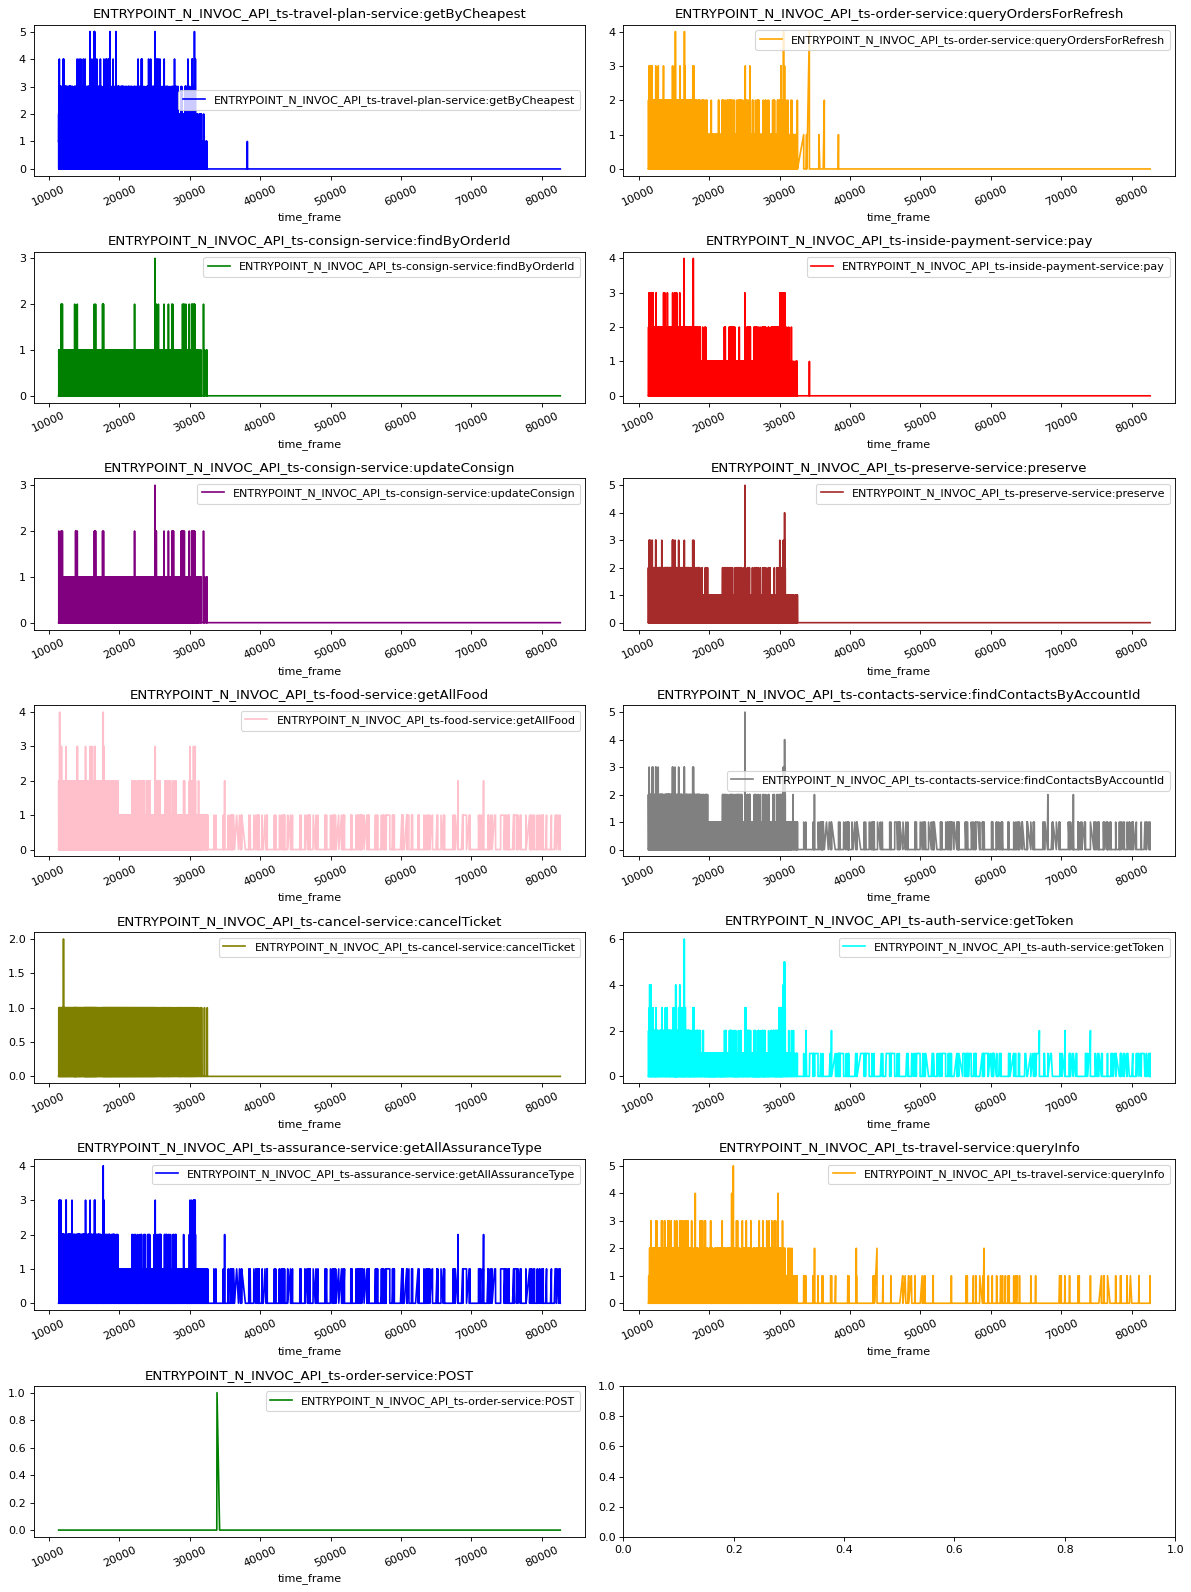

Data normalized
Input size 45 Output size 13
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                2944      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 13)                429       
                                                                 
Total params: 5,453
Trainable params: 5,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
347/347 [==============================] - 1s 2ms/step - loss: 0.3722 - val_loss: 8.9838e-04
Epoch 2/100
347/347 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 8.5813e-04
Epoch 3/100
347/347 [==============================] - 1s 2ms

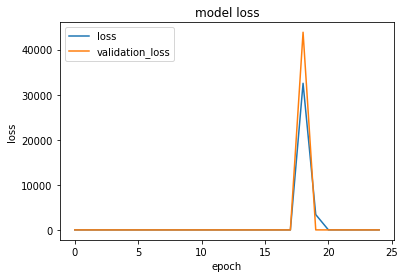

214/214 [==============================] - 0s 1ms/step
TOTAL MSE:  0.33336896666273674
TOTAL MAE:  0.4425331217424126
TOTAL MAPE:  1.08
FIRST 50 predictions
ENTRY ENTRYPOINT_AVG_EXTIME_ts-travel-plan-service:getByCheapest
PRED [274138560.0, 287694080.0, 43568750.0, 177759940.0, 110667650.0, -97101420.0, 424571550.0, -291463260.0, 93809930.0, -214004820.0, -108733580.0, -186923440.0, 128983896.0, -390107140.0, 103901510.0, -300525920.0, -125125176.0, -633042240.0, 86568950.0, -15458515.0, 213234620.0, 355983600.0, -54114148.0, 70883630.0, 165618320.0, -108851640.0, 145622900.0, 72284744.0, -130720150.0, -310186900.0, 165130940.0, 9413085.0, 22339894.0, -509317470.0, -6473629.5, -168605340.0, -59743916.0, -126788190.0, -298958800.0, -48676880.0, 59533140.0, -374643600.0, 6052625.5, -61182084.0, -351544600.0, 22207456.0, 141316720.0, -2966352.5, -237693620.0, -61618144.0]
VALS [0.0, 0.0, 0.0, 206615.0, 0.0, 182572.0, 0.0, 0.0, 0.0, 0.0, 198140.0, 0.0, 0.0, 0.0, 39416.0, 0.0, 0.0, 0.0, 0.0

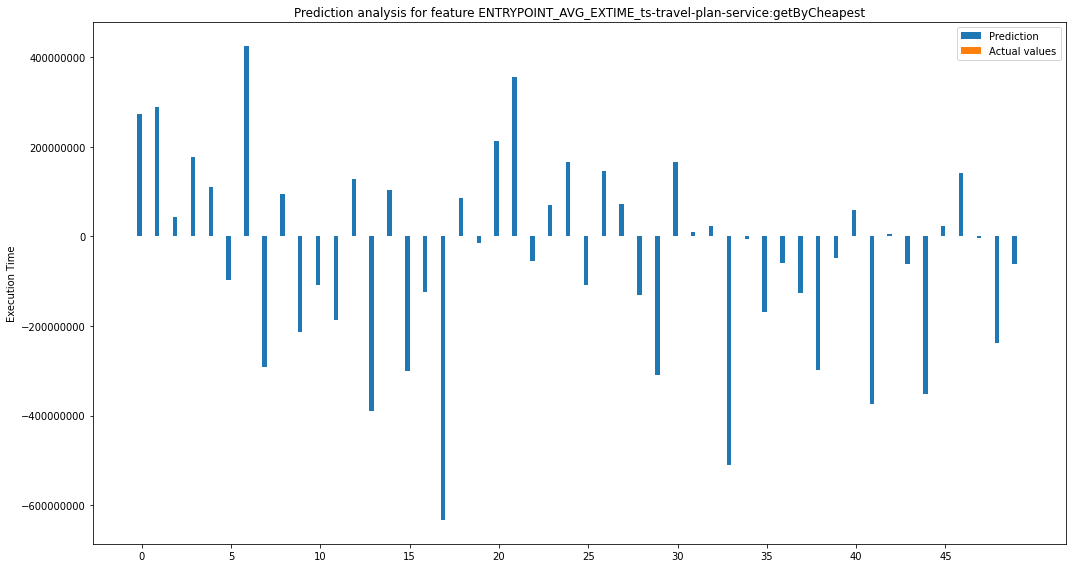

MAE:  169090778.78
MAPE:  99.93  %
MSE:  4.823563998618065e+16
ENTRY ENTRYPOINT_AVG_EXTIME_ts-order-service:queryOrdersForRefresh
PRED [-489625200.0, -276067840.0, -99647050.0, -160750480.0, -47553000.0, 382654750.0, -436366460.0, 649746600.0, 232438670.0, 196284240.0, 367613120.0, 442953060.0, 38887344.0, 883977300.0, 31466136.0, 688782800.0, 474543140.0, 1147198800.0, 413692540.0, -33714970.0, -369544320.0, -601977400.0, 96616400.0, -154621710.0, -174321860.0, 108070264.0, 111480440.0, 151679710.0, 494546300.0, 608469570.0, 28692988.0, -9780939.0, -136362940.0, 672377200.0, 9121330.0, 406689730.0, 452467500.0, 321644670.0, 526724770.0, 58130550.0, -103450344.0, 401076160.0, -251192080.0, 273271100.0, 272775680.0, 20935264.0, -260590400.0, 263651600.0, 688372160.0, 301819680.0]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2447799.0, 0.0, 0.0, 0.0, 0.0, 2880405.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3058963.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 277861

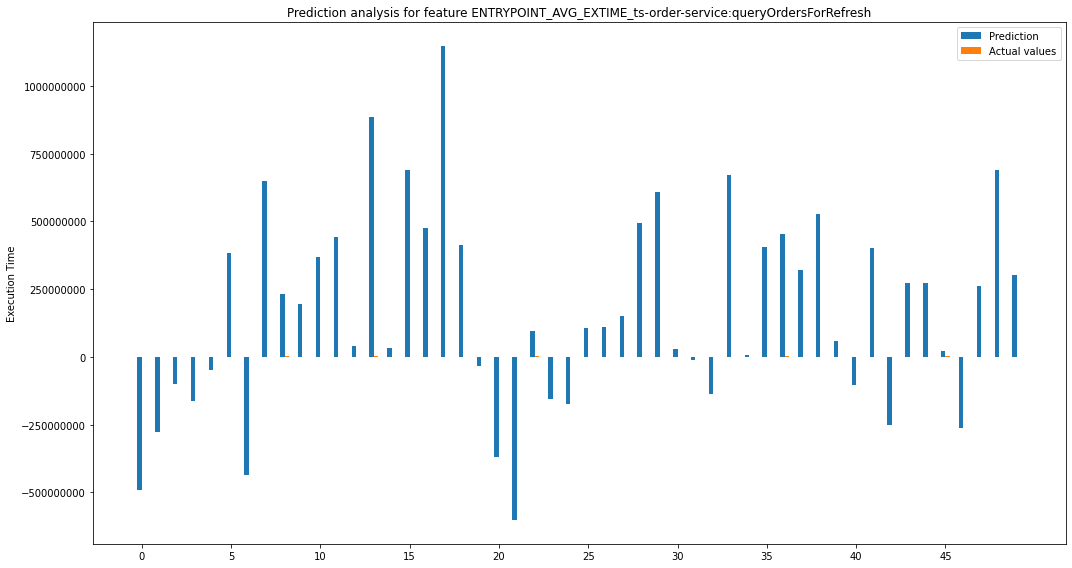

MAE:  316218160.89
MAPE:  99.67  %
MSE:  1.607300611654382e+17
ENTRY ENTRYPOINT_AVG_EXTIME_ts-consign-service:findByOrderId
PRED [-11955.327, 632.6362, -236.13866, -1933.5956, -7928.2524, 10805.058, -15814.821, 4784.6836, 9771.536, 3559.5315, 3700.8772, 1563.9689, 1135.3177, 11151.579, -1551.6494, 6850.605, 3109.03, 3432.4294, 22036.959, -3910.5696, -11289.276, -14186.671, -2228.495, -5453.8164, -1144.335, 882.1639, 1657.9313, 733.3254, 5209.268, 4905.072, -1840.6343, 4616.1216, -10489.417, 15655.587, -4998.2188, 8698.131, 1656.7015, 5894.478, 9378.031, 93.65971, -1796.2091, 1503.1823, -2281.3953, -550.0397, 1808.7866, -1410.7585, -7293.31, 1623.3254, 8638.668, -230.53398]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3142.0, 0.0, 0.0, 0.0, 3218.0, 0.0, 0.0, 0.0, 0.0, 3184.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2593.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


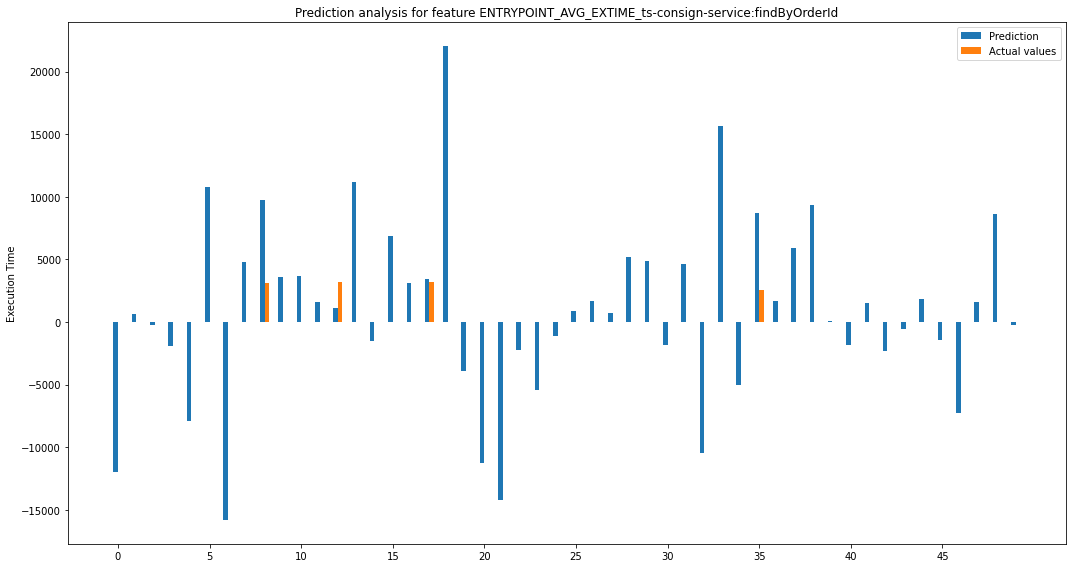

MAE:  5120.809459533692
MAPE:  98.57  %
MSE:  49909058.042129666
ENTRY ENTRYPOINT_AVG_EXTIME_ts-inside-payment-service:pay
PRED [740514.94, 506950.38, 178878.55, 292439.1, 26392.555, -643350.75, 575683.2, -1182808.5, -477293.03, -169560.78, -508325.16, -719618.1, -56554.457, -1526451.2, 13417.552, -1074271.6, -754200.3, -1985152.0, -490554.78, 130777.93, 590115.4, 964549.06, -273388.5, 256388.02, 300154.75, -162803.72, -227101.44, -238630.22, -727056.5, -988780.75, -124851.445, 132058.03, 117299.43, -994289.0, 38477.555, -636606.8, -809729.5, -447413.25, -804099.56, -231.93376, 279593.97, -643911.8, 518253.97, -450942.44, -356535.88, -64595.918, 479094.72, -384376.7, -1056021.4, -502438.38]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4724.0, 0.0, 0.0, 0.0, 4548.0, 0.0, 0.0, 0.0, 0.0, 5256.0, 5884.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4835.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4839.0, 0.0, 0.0, 0.0, 0.0, 0.0]


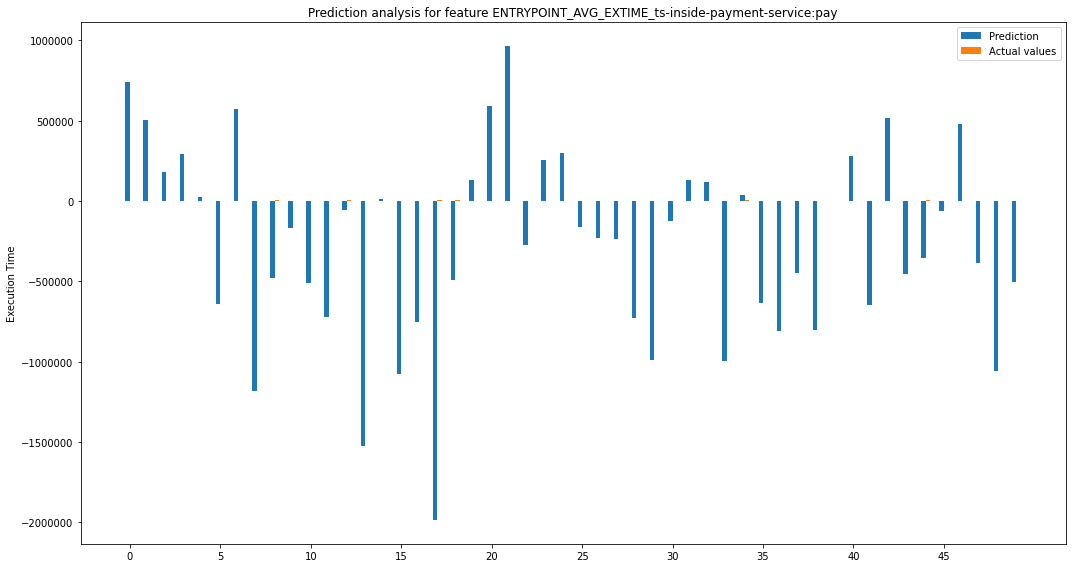

MAE:  512868.0186166382
MAPE:  99.99  %
MSE:  426529544502.7649
ENTRY ENTRYPOINT_AVG_EXTIME_ts-consign-service:updateConsign
PRED [14667.726, 7995.091, -117.033806, 6687.807, -257.93298, -9071.107, 11857.083, -22706.893, 3458.862, -595.6155, -7858.8105, -13070.573, 8818.387, -28098.783, 2102.0852, -19179.977, -13056.651, -32453.053, -8325.046, 4395.029, 12810.32, 19251.135, -1491.749, 6433.9824, 7177.5146, -3201.009, -2198.7378, -3186.8816, -12087.959, -22240.248, -1013.72156, 3366.2969, 1205.5801, -22398.334, 1712.5768, -1299.201, -13784.559, -7491.55, -22094.455, 1525.5458, 8360.221, -14261.642, 12338.591, -6793.4917, -8217.974, 1134.9652, 10608.586, -5799.6343, -18983.828, -8896.824]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9689.0, 0.0, 0.0, 0.0, 10946.0, 0.0, 0.0, 0.0, 0.0, 10625.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9115.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


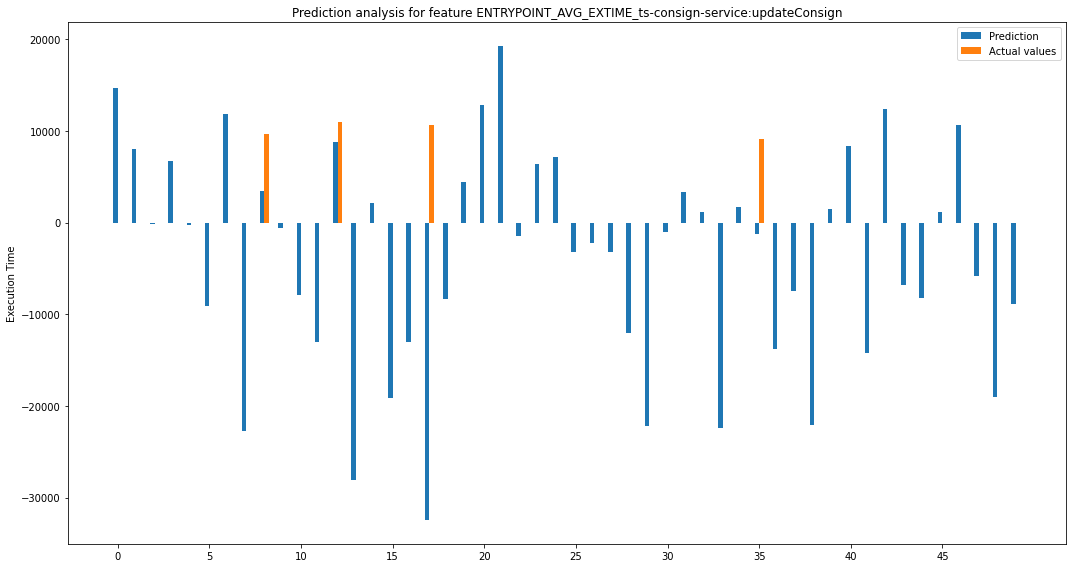

MAE:  9839.223200531005
MAPE:  114.77  %
MSE:  168017305.18940303
ENTRY ENTRYPOINT_AVG_EXTIME_ts-preserve-service:preserve
PRED [546750460.0, 172967890.0, 108707540.0, 142061380.0, 342372380.0, -458968450.0, 728703740.0, -297221600.0, -165256290.0, -352455070.0, -244210990.0, -168370820.0, 149779520.0, -606732700.0, 52534240.0, -430795900.0, -221955360.0, -269231230.0, -653818940.0, 67078160.0, 470975600.0, 656612540.0, -18762438.0, 201683340.0, 121912440.0, -91043080.0, -48207476.0, -14074202.0, -309268860.0, -261854460.0, 126245600.0, -124216984.0, 417495780.0, -716572400.0, 110524480.0, -266945070.0, -106498700.0, -260432720.0, -316123700.0, -103591930.0, 16803150.0, -255734370.0, 375304.22, -58606636.0, -242622990.0, 17446002.0, 274302050.0, -102190470.0, -476104900.0, -40422588.0]
VALS [676331.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 698296.0, 653404.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 699503.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 548271.

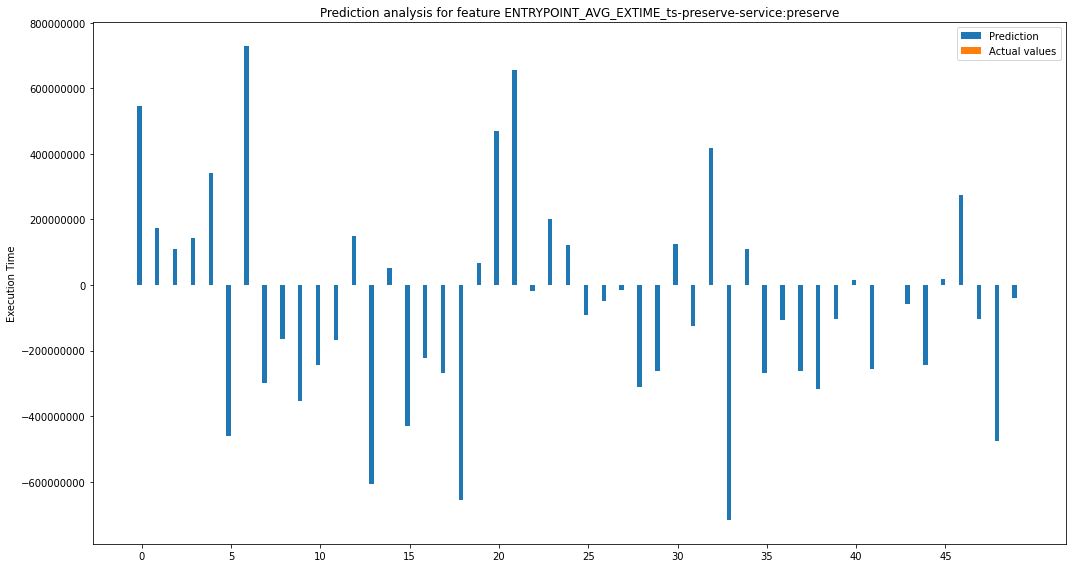

MAE:  248140650.715625
MAPE:  100.14  %
MSE:  9.996474899048402e+16
ENTRY ENTRYPOINT_AVG_EXTIME_ts-food-service:getAllFood
PRED [-27244.066, 38238.38, -734.0413, 16991.395, -11595.204, 45601.934, 4240.6104, 5560.5146, 92727.06, 5252.85, 20436.977, 1012.9581, 29808.797, 32298.646, 21172.736, 13262.921, 24263.186, -60238.438, 132733.03, -21467.242, -29549.314, -26274.363, 12065.45, -19978.41, 12393.163, -14886.841, 54649.81, 30337.324, 31967.5, -6100.7954, 32120.393, 24115.469, -52627.97, 22270.324, -32748.014, 30152.47, 28212.107, 19440.63, -928.7643, 18277.312, -1644.6534, -44524.062, -5018.831, 6208.515, -55091.336, 31032.826, -24981.55, 27589.402, 38171.27, 8581.479]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20501.0, 14677.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16685.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21779.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15714.0, 0.0, 0.0, 18900.0, 0.0, 0.0, 23608.000000000004, 0.0, 0.0, 0.0, 0.0]


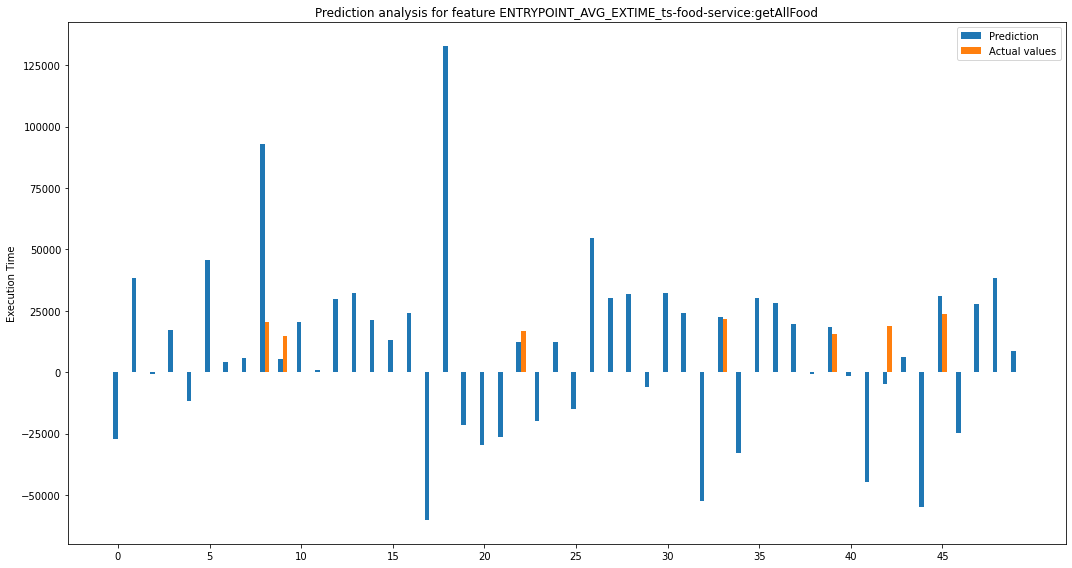

MAE:  25616.894739990235
MAPE:  102.25  %
MSE:  1176123401.179247
ENTRY ENTRYPOINT_AVG_EXTIME_ts-contacts-service:findContactsByAccountId
PRED [-9232.187, -1258.8142, -1484.3572, -2019.6694, -7739.443, 11588.459, -14908.459, 5150.1025, 5333.4424, 9662.438, 4950.406, 2529.6602, -3403.599, 10553.767, -616.8646, 8040.0605, 4158.853, 758.6889, 16829.209, -1418.2842, -9967.4375, -12968.243, 120.41256, -3925.1536, -1336.9407, 2086.8862, 2514.6565, 737.24036, 6183.467, 4324.249, -1575.1075, 2463.2556, -9784.053, 14500.438, -470.73804, 4590.1436, 348.58447, 4999.613, 6353.0376, 2902.029, 2067.7295, 3822.854, 3112.077, 832.35406, 3654.8325, -1210.454, -3371.1562, 2213.1792, 9432.38, 336.38885]
VALS [2196.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2544.0, 2148.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2422.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2050.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2400.0, 0.0, 2465.0, 0.0, 0.0, 0.0, 1977.0, 0.0, 0.0, 0.0]


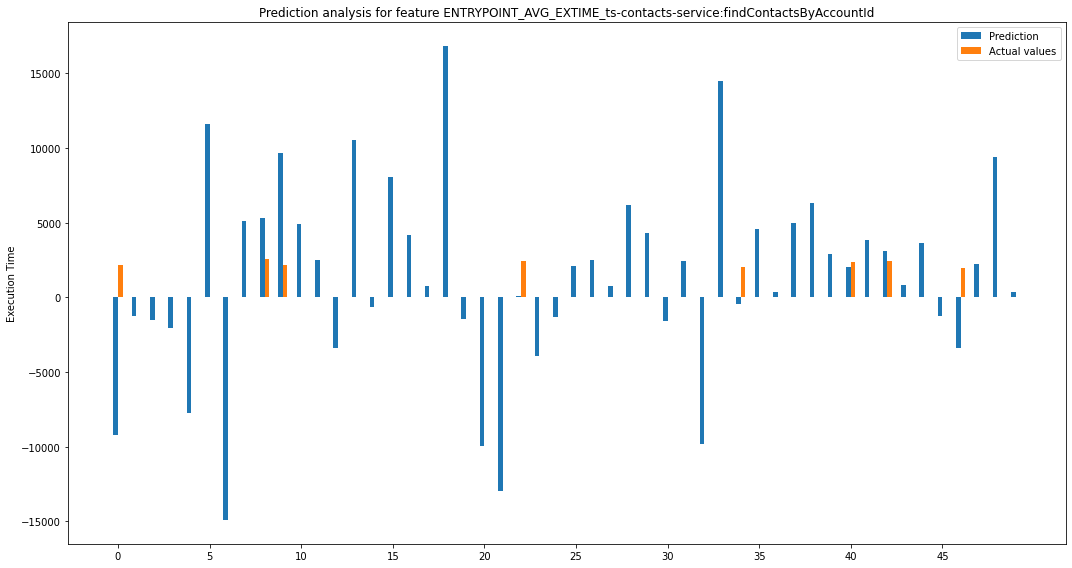

MAE:  4867.071415557862
MAPE:  141.93  %
MSE:  41899505.382916406
ENTRY ENTRYPOINT_AVG_EXTIME_ts-cancel-service:cancelTicket
PRED [-23437.52, -25170.896, 5886.203, -19561.31, 54410.15, 43487.707, 42914.637, 145803.72, 71923.13, -40052.95, 38641.152, 78989.28, 38745.883, 127231.69, 12666.882, 94893.81, 86700.36, 236346.25, 18671.355, -30233.043, -33320.934, -48455.09, -2068.9514, -23151.6, -25456.033, 11466.024, 47355.53, 49584.746, 67434.95, 115344.195, 67297.36, -32362.455, 33932.36, 59147.2, -2524.781, 56287.82, 94580.04, 28656.914, 91872.93, -14189.254, -51001.117, 40248.51, -89928.66, 61393.32, -19781.396, -3577.1455, -36766.035, 46051.008, 96591.85, 75947.19]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


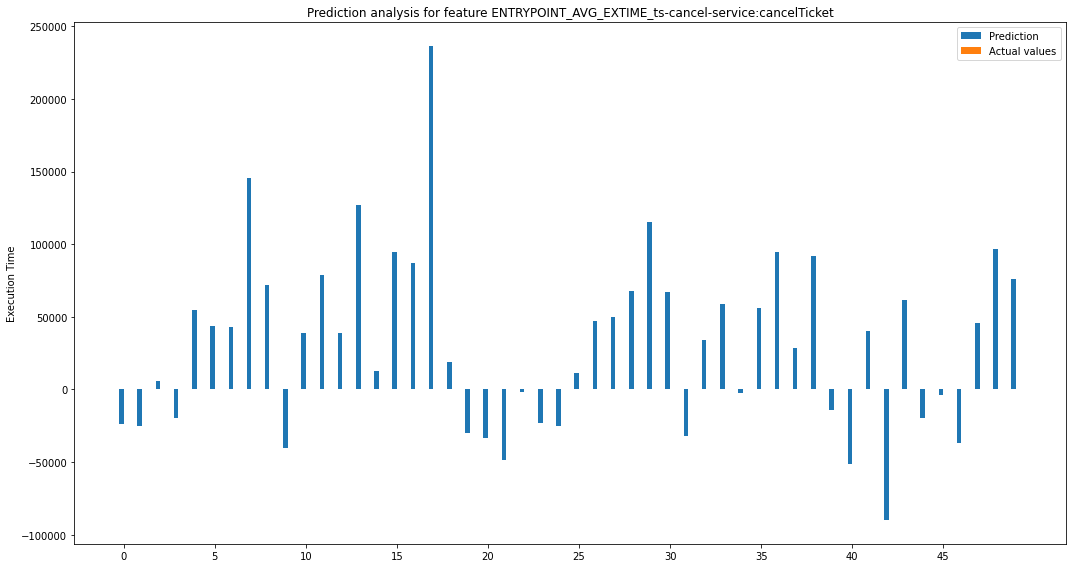

MAE:  53230.86654296875
MAPE:  100.0  %
MSE:  4594949969.757503
ENTRY ENTRYPOINT_AVG_EXTIME_ts-auth-service:getToken
PRED [88269.3, 171929.94, 116727.734, 56469.418, 69522.74, -9486.507, 209503.27, -26835.299, 111108.625, -157555.42, -84116.48, -71331.77, 91680.14, -90516.07, 11097.503, -124310.4, -47425.33, -177236.16, 79938.24, -78998.97, 33858.98, 119826.32, -27589.746, 10154.637, 54632.81, -6208.4204, 88134.8, 40490.793, -73784.82, -46292.164, 120332.69, 5520.023, 36795.633, -97836.37, -65620.59, -50430.004, -7245.13, -43083.977, 14203.693, -31525.902, -70913.055, -134909.61, -61245.902, -34278.934, -148453.84, 32087.998, -17432.838, -7693.7114, -103784.16, -10863.174]
VALS [0.0, 113818.0, 118455.00000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 117269.99999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 114094.0, 0.0, 0.0, 0.0, 115867.99999999999, 0.0, 0.0, 0.0, 0.0, 122582.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


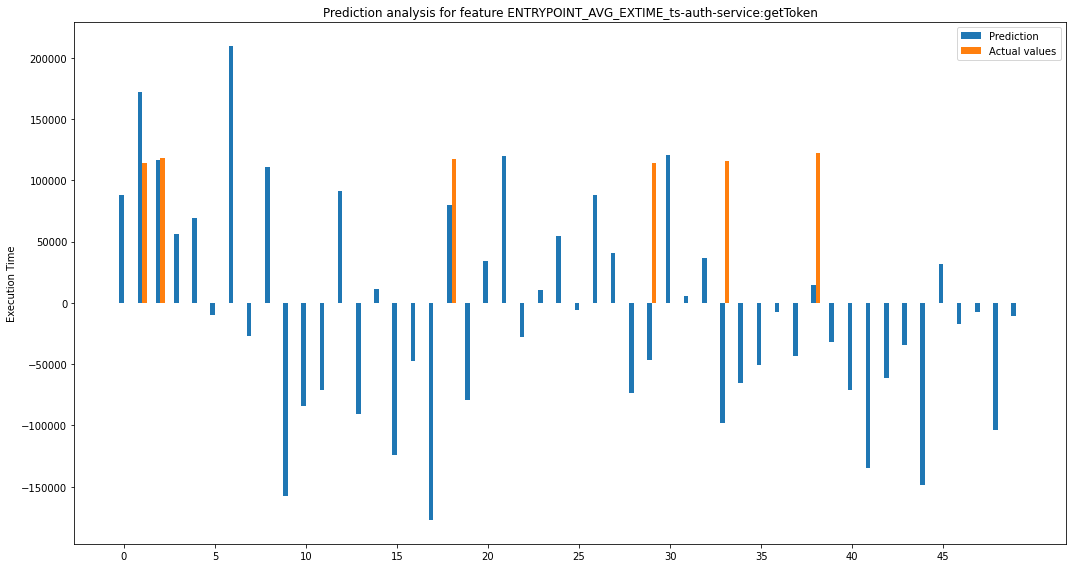

MAE:  70440.03366210937
MAPE:  116.2  %
MSE:  7843479163.152362
ENTRY ENTRYPOINT_AVG_EXTIME_ts-assurance-service:getAllAssuranceType
PRED [-2489.7896, -4205.5938, -1347.3567, -1413.9985, 1459.0182, 661.4662, -1886.2354, 5971.3413, 2317.8357, 2289.4844, 2463.2156, 4178.412, -257.50137, 6852.8555, -24.690195, 5219.4478, 3489.452, 12879.63, -2143.9434, 819.508, -809.63873, -2977.5527, 4263.832, -26.689278, -1571.7499, 655.4743, -818.06976, 719.0069, 3038.7026, 5241.4004, -304.46326, -510.353, 2031.9442, 5705.4526, 747.58, 3156.944, 4388.718, 2177.808, 3352.9783, 1525.9365, -1028.3623, 4550.502, -728.4572, 2699.6165, 3005.2676, 2628.197, -1360.9207, 1739.9019, 4404.175, 2898.0537]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1582.0, 1325.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1526.0000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2151.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1718.0, 0.0, 0.0, 1430.9999999999998, 0.0, 0.0, 1750.0, 0.0, 0.0, 0.0, 0.0]


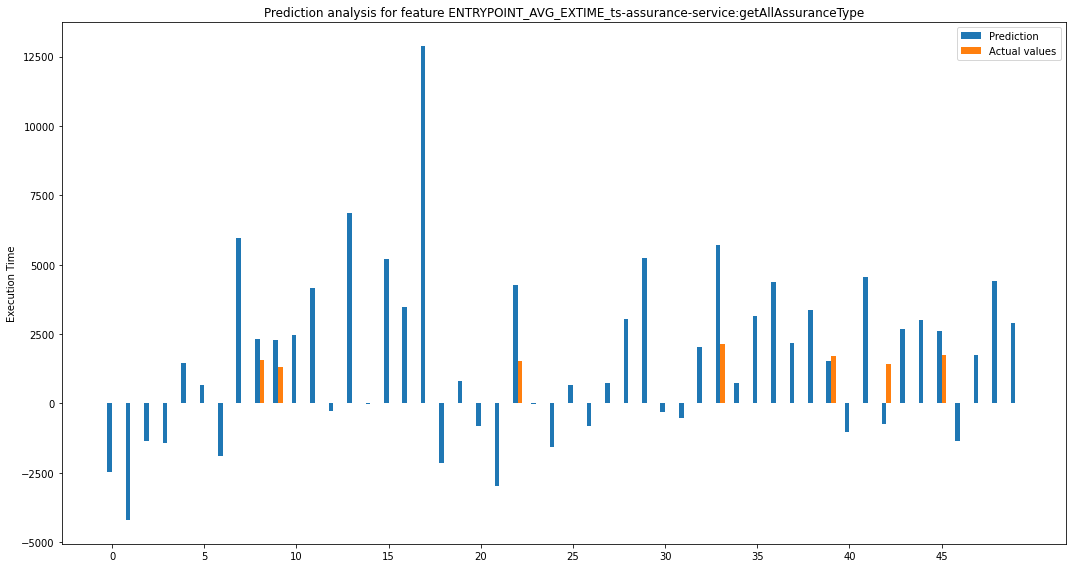

MAE:  2464.0330057144165
MAPE:  96.86  %
MSE:  10980167.098669782
ENTRY ENTRYPOINT_AVG_EXTIME_ts-travel-service:queryInfo
PRED [-281162720.0, -88204696.0, -105904370.0, -19778290.0, -196543280.0, 266456910.0, -400601900.0, 100047040.0, -6019384.0, 339118140.0, 249860660.0, 140037000.0, -93308990.0, 298881570.0, 68199240.0, 303562430.0, 191338640.0, 117386880.0, 370089660.0, 88046000.0, -194317550.0, -310976930.0, -4863182.5, -69123260.0, -25679264.0, 33428084.0, 72094590.0, 46936060.0, 269889280.0, 146529390.0, -79021040.0, 61776060.0, -259770260.0, 325727260.0, 67370090.0, 131501000.0, 68197256.0, 161795020.0, 120408910.0, 158881390.0, 119437460.0, 135267870.0, 117785656.0, 93609090.0, 174167440.0, -3293687.5, -42686804.0, 133299940.0, 332380320.0, 59500936.0]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 95959.0, 0.0, 12684.0, 0.0, 0.0, 0.0, 274268.0, 0.0, 0.0, 0.0, 0.0,

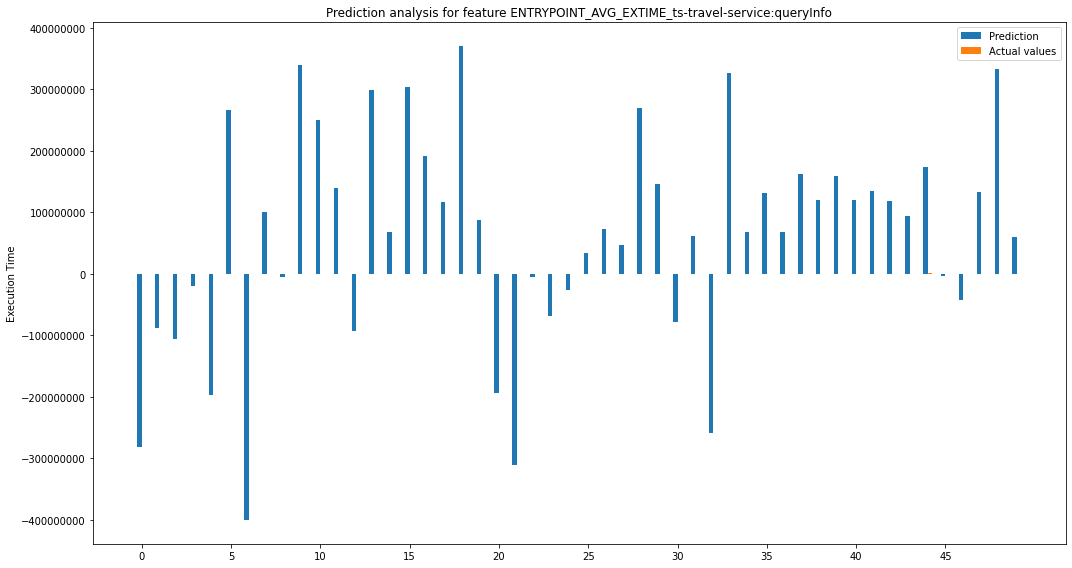

MAE:  150870300.72
MAPE:  99.99  %
MSE:  3.40659454337888e+16
ENTRY ENTRYPOINT_AVG_EXTIME_ts-order-service:POST
PRED [-10398136.0, -6866285.0, -833341.94, -6435291.5, -2584012.8, 6269334.5, -10262209.0, 13253947.0, 5443478.5, -3466963.2, 491118.7, 4747420.5, -1128956.0, 17636566.0, -5330207.0, 8289040.0, 3338985.0, 22772932.0, 2775223.2, -3206333.8, -7415881.5, -12140124.0, 6779781.5, -2363469.8, -4995232.5, 2038017.6, -2659632.8, -1683772.9, 2124316.8, 10785899.0, -2009580.6, -1454164.4, 465049.7, 13598636.0, -4657911.0, 7568992.0, 7855159.5, 3504987.0, 12578142.0, -5764697.5, -7088486.0, 8748150.0, -9951702.0, 1898447.6, 6075705.5, 530433.4, -9376711.0, -758818.25, 6344461.5, 1900257.4]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


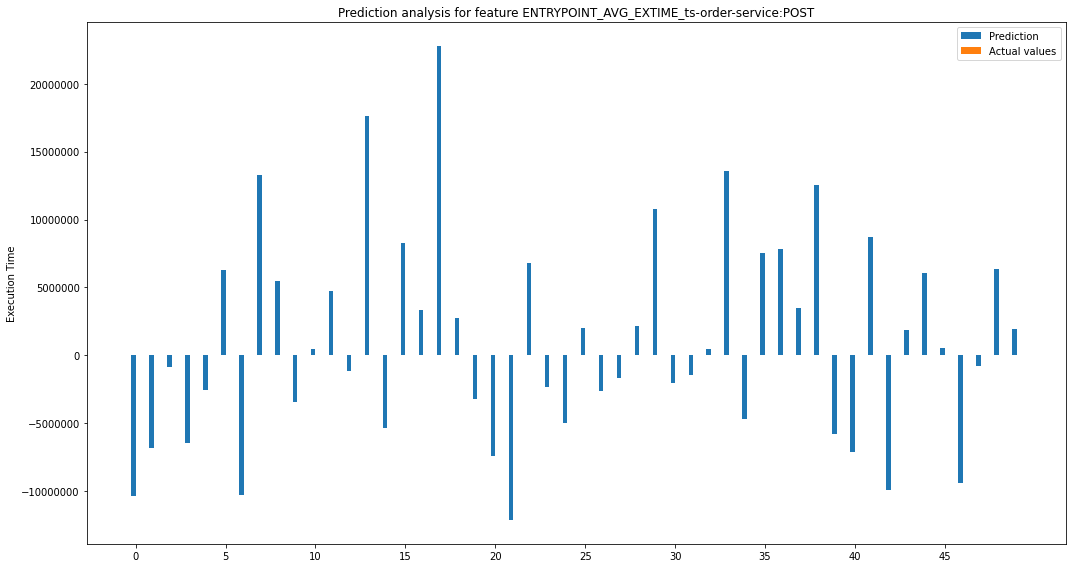

MAE:  6012928.04375
MAPE:  100.0  %
MSE:  57888426085331.36
MAE:  221690514.82052663
MAPE:  1.01
MSE:  7.667391703667747e+16
MAE:  396817775.7277247
MAPE:  1.0
MSE:  2.163564200403145e+17
MAE:  6900.443771374219
MAPE:  1.01
MSE:  83836015.25117952
MAE:  619972.4197694568
MAPE:  1.01
MSE:  531903617799.4239
MAE:  11783.24667207742
MAPE:  1.05
MSE:  197304931.36224842
MAE:  330755584.9879497
MAPE:  1.0
MSE:  1.709937907777972e+17
MAE:  31414.692160054376
MAPE:  1.39
MSE:  2255738706.2914076
MAE:  6768.096783611068
MAPE:  1.09
MSE:  76907748.78453706
MAE:  57616.47646588975
MAPE:  1.0
MSE:  4861506500.216487
MAE:  100853.14770371819
MAPE:  1.44
MSE:  15298087325.914284
MAE:  3114.755307027528
MAPE:  1.09
MSE:  14744121.264195554
MAE:  209863788.04782274
MAPE:  1.0
MSE:  6.693166195177724e+16
MAE:  6158237.994166972
MAPE:  1.0
MSE:  61916867401958.17
Loading datasource from avv_dataset_DT_100.csv
Datasource loaded: len = 10861
Entrypoints size: 13
Entrypoint list
[   'ENTRYPOINT_N_INVOC_AP

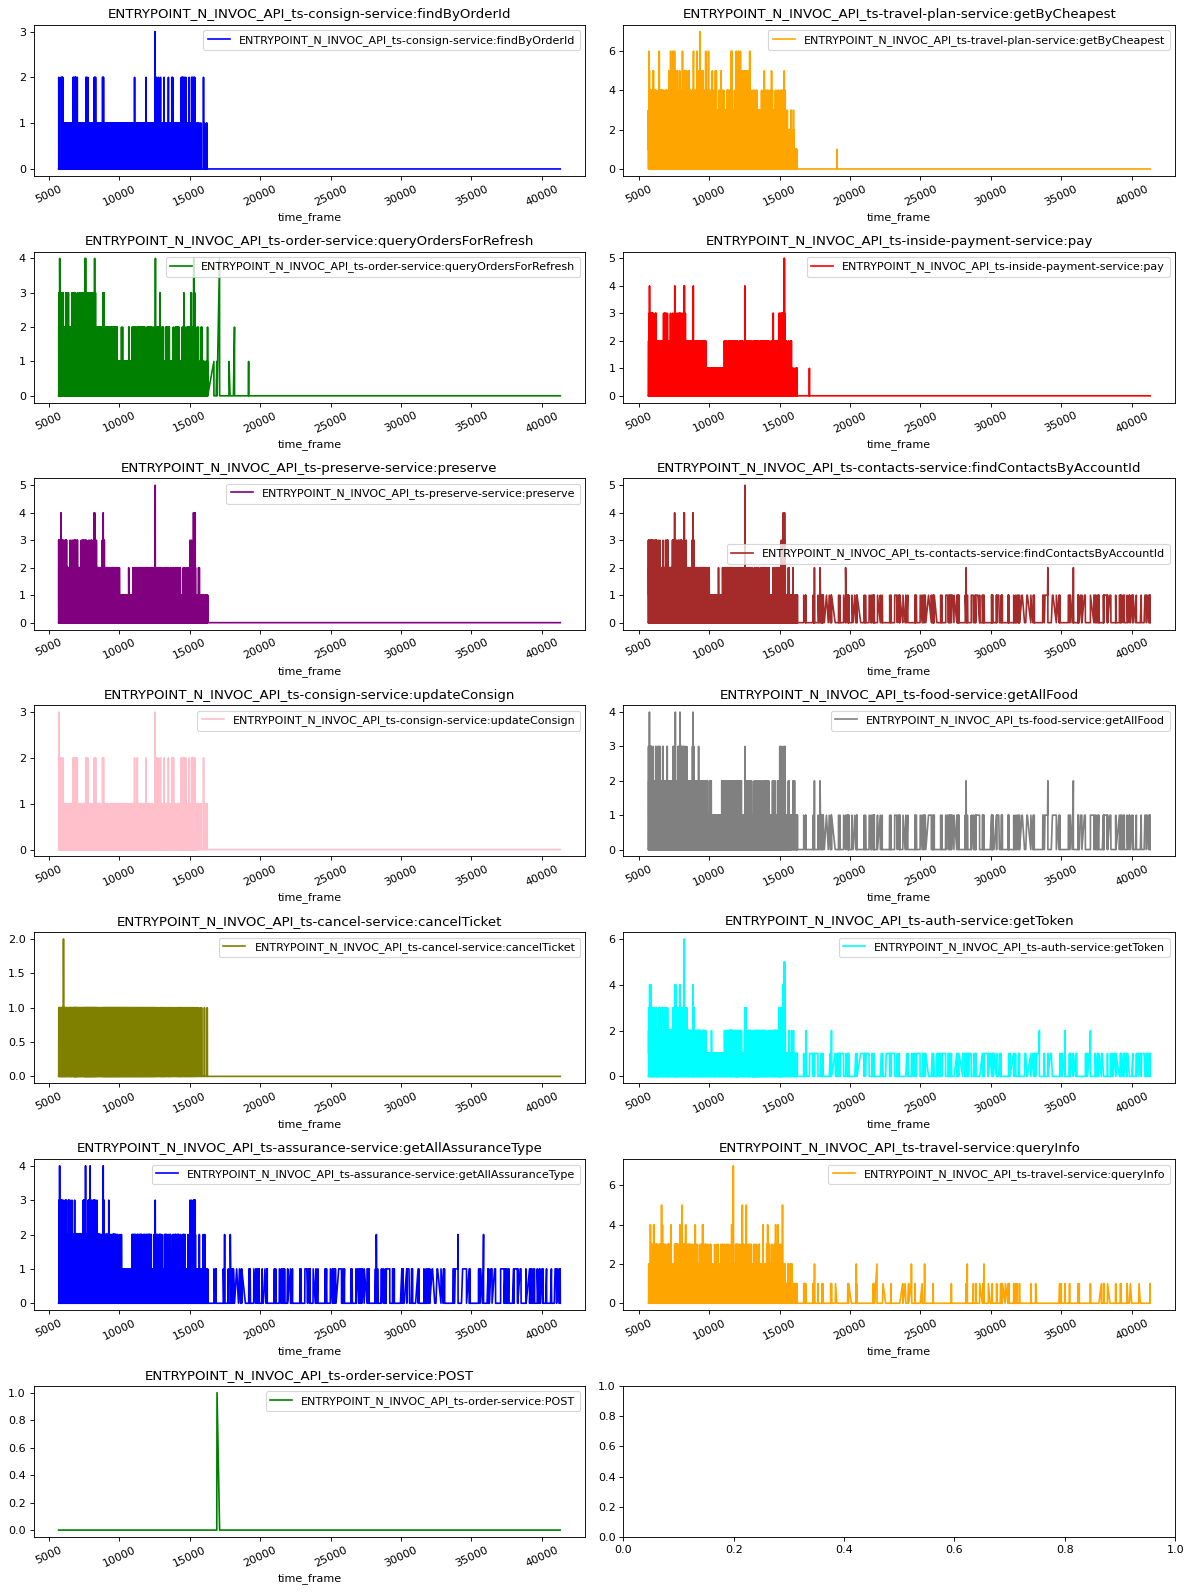

Data normalized
Input size 45 Output size 13
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                2944      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 13)                429       
                                                                 
Total params: 5,453
Trainable params: 5,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
182/182 [==============================] - 1s 3ms/step - loss: 1.9797 - val_loss: 0.0045
Epoch 2/100
182/182 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 3/100
182/182 [==============================] - 0s 2ms/step - 

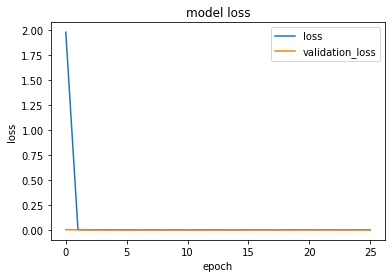

113/113 [==============================] - 0s 971us/step
TOTAL MSE:  0.002430244807534999
TOTAL MAE:  0.02218974770069547
TOTAL MAPE:  1.12
FIRST 50 predictions
ENTRY ENTRYPOINT_AVG_EXTIME_ts-consign-service:findByOrderId
PRED [124.67516, 212.46683, 70.08484, 144.99094, 74.0107, 187.07263, 84.94214, 103.95396, 100.42965, 353.42743, 242.18092, 34.19316, 63.26046, 53.707375, 56.281063, 253.11159, 76.402405, 245.73322, 190.77919, -1.3669488, 192.76648, 60.52423, 154.88051, 241.72285, 72.7534, 77.44816, 96.065414, 210.93733, 4347.567, -45.112423, 205.10324, 112.19168, 96.59608, 179.42363, 210.01419, 212.4046, 4123.6904, 4001.965, 209.79074, 77.005905, 111.36057, 72.742516, 53.647232, 4246.383, 51.24049, 145.74324, 216.35614, 388.12518, 38.399258, 53.088577]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2608.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3079.0, 2889.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2963.0

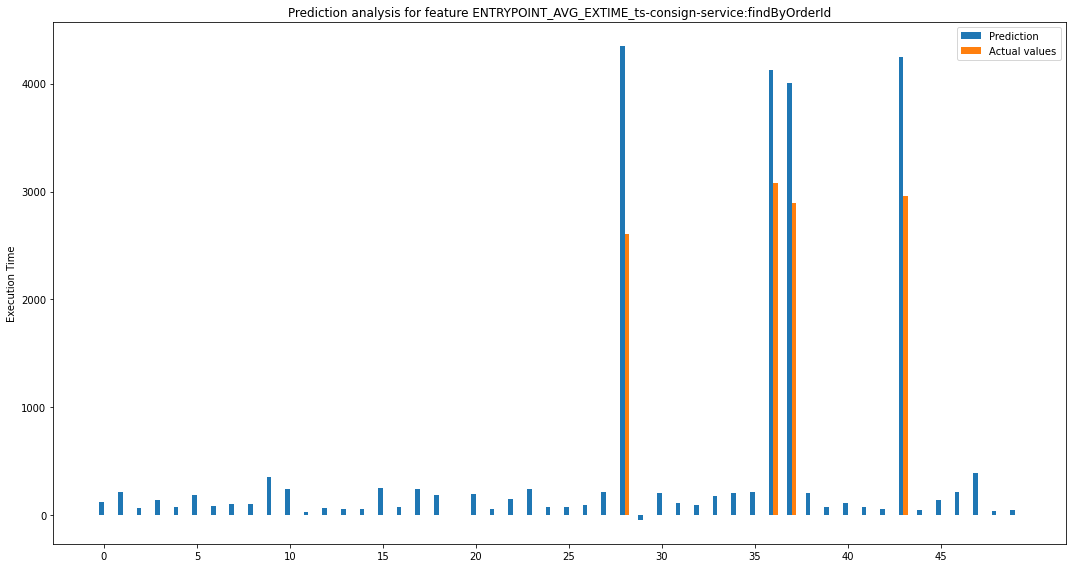

MAE:  228.7823980283737
MAPE:  94.47  %
MSE:  163834.40043585806
ENTRY ENTRYPOINT_AVG_EXTIME_ts-travel-plan-service:getByCheapest
PRED [10980886.0, -10857699.0, 12808176.0, 1313779.5, 7896171.0, 27247528.0, 7801336.0, 4642868.0, -6091867.0, -8396220.0, 11624282.0, 25223774.0, 27783390.0, 6330461.5, 5551369.5, -8488737.0, 14485356.0, 11310791.0, 20738446.0, 7774222.5, -4214318.0, 13701057.0, -5491713.0, 14232030.0, 7009131.5, 21968946.0, 9665297.0, -7622747.0, 11772360.0, 25337214.0, 12092392.0, 6204227.0, 11199225.0, -4730844.5, 6873372.0, 12381309.0, 33025904.0, 16020173.0, -12811637.0, 11779250.0, 9258177.0, 978000.6, 21721462.0, 24980194.0, 1911489.0, 4140374.0, -3114210.0, 3542220.2, 18914996.0, 4527047.0]
VALS [0.0, 198238.0, 125134.0, 43780.0, 0.0, 0.0, 260877.0, 479221.0, 0.0, 187528.5, 114866.5, 0.0, 0.0, 0.0, 283410.0, 47022.0, 118347.5, 570489.0, 0.0, 0.0, 0.0, 99783.33333333331, 272176.5, 209832.0, 197384.0, 0.0, 517099.0, 281687.6666666667, 44462.0, 41505.0, 45152.0, 43336.

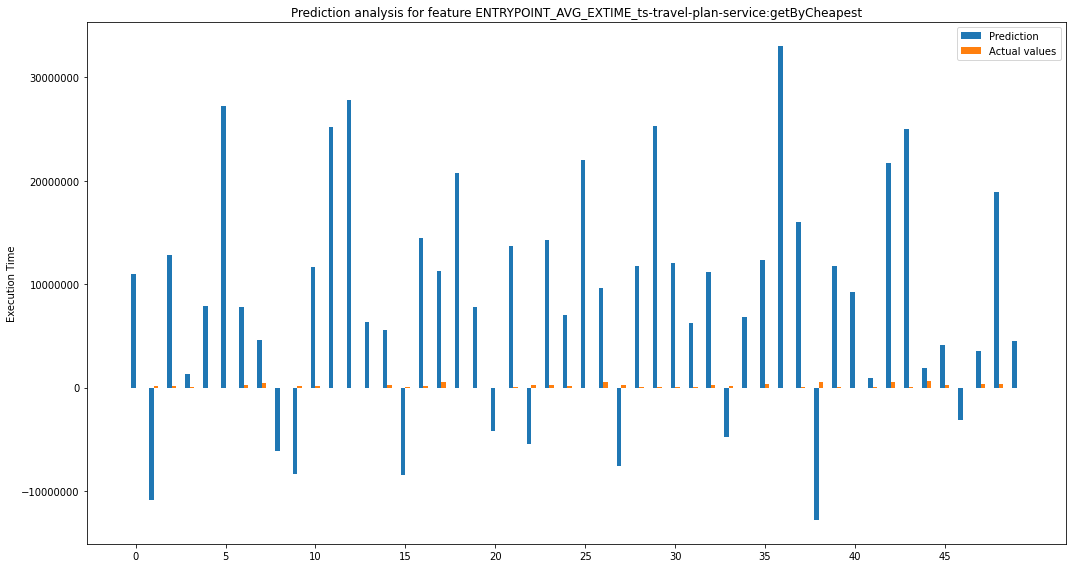

MAE:  11488029.284166666
MAPE:  98.38  %
MSE:  190367068158830.3
ENTRY ENTRYPOINT_AVG_EXTIME_ts-order-service:queryOrdersForRefresh
PRED [6238151.5, -8300630.0, 7114722.5, -3391287.8, 1197965.4, 20856746.0, 1265061.4, -41486.957, -6815934.5, -13218965.0, 4385167.0, 15895353.0, 16969800.0, 1708275.4, 2649191.5, -11395347.0, 6639029.5, 668759.06, 14326552.0, 5088385.5, -6101302.5, 9668128.0, -9150885.0, 5742226.0, 1798433.8, 15307933.0, 4702709.5, -12771852.0, -1236544.0, 17573822.0, 889493.56, 3512824.5, 8652098.0, -8653261.0, 2659771.5, 3396098.2, 17760050.0, 2682755.2, -9383080.0, 8637006.0, 1648599.6, -4063190.8, 10066962.0, 8111557.0, 528624.6, -2008808.2, -6305231.5, -3558320.2, 9121487.0, 5252085.5]
VALS [3056972.0, 0.0, 0.0, 0.0, 0.0, 3066999.0, 0.0, 0.0, 0.0, 2741712.0, 0.0, 3186865.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2963586.0, 3137578.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2932558.0, 0.0, 0.0, 2773551.0, 0.0, 0.0, 0.0, 0.0, 2842649.0, 0.0, 0.0, 3170787.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30248

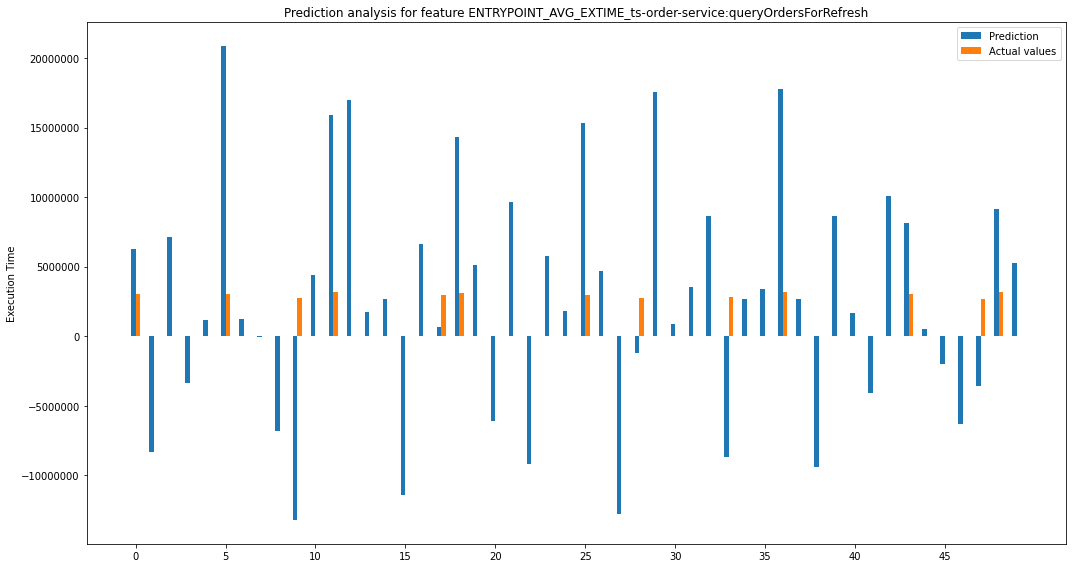

MAE:  6740460.611640625
MAPE:  107.64  %
MSE:  67970775983344.58
ENTRY ENTRYPOINT_AVG_EXTIME_ts-inside-payment-service:pay
PRED [-7051.4053, 18750.246, -15949.111, -503.46738, -10890.022, -32875.137, -4292.381, -1657.2955, 2161.2302, 23364.684, -12028.373, -37668.766, -32833.082, -3256.476, -4166.689, 12403.404, -19494.643, -3966.1782, -27458.54, -884.2219, 7926.925, -21037.578, 10218.869, -10212.912, -7981.5933, -32132.668, -3220.0303, 6984.6465, -16806.875, -32450.4, -6692.32, -2297.7854, -12812.019, 3545.3567, -5837.827, -8977.489, -42803.37, -17637.83, 20968.424, -14009.185, -9882.621, 3084.7598, -36135.816, -24090.682, -2146.1611, 4464.9146, 307.6291, 793.4576, -26738.791, -896.6042]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 3843.0, 0.0, 0.0, 0.0, 4658.0, 0.0, 0.0, 5353.0, 0.0, 0.0, 0.0, 0.0, 4631.0, 4833.0, 0.0, 0.0, 0.0, 0.0, 5199.0, 0.0, 0.0, 0.0, 0.0, 4514.0, 0.0, 5307.0, 0.0, 0.0, 0.0, 0.0, 3950.9999999999995, 4682.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4749.0, 0.0, 0.0, 0.0, 5059.0, 0.0, 0.0

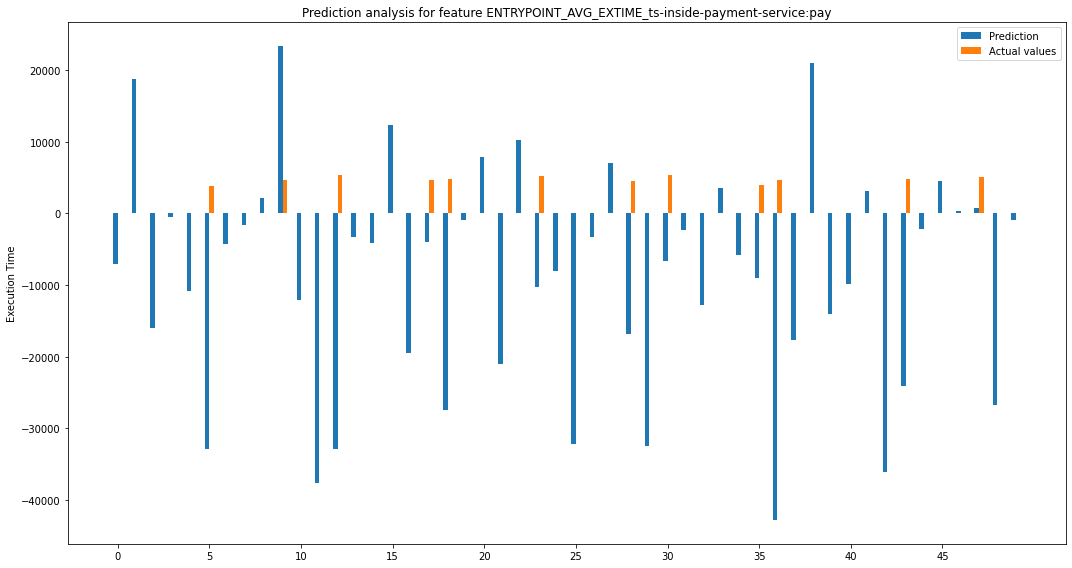

MAE:  14212.539531860351
MAPE:  116.23  %
MSE:  348846836.68842024
ENTRY ENTRYPOINT_AVG_EXTIME_ts-preserve-service:preserve
PRED [-2799415.8, 9882728.0, -7932477.5, 129679.62, -327934.47, -23558756.0, -599886.5, -1490940.4, 2533662.2, 14002593.0, -3128198.5, -17960676.0, -19864014.0, -1047517.7, -1488917.8, 8046302.0, -8339785.5, -3131656.8, -10757731.0, -6930209.0, 6679984.5, -8535887.0, 5229530.0, -7159880.5, -4365489.0, -12782593.0, -6753355.5, 11418820.0, -7408898.0, -16883568.0, -6497780.5, -1419070.1, -7211654.5, 5698269.0, -2986513.2, -4683408.0, -23780860.0, -6439840.5, 12756755.0, -8537486.0, -3897076.2, 1756432.9, -14886437.0, -12570049.0, -381828.97, 3084939.2, 2279131.5, 2885803.8, -12838967.0, -2173528.2]
VALS [0.0, 0.0, 0.0, 575618.0, 0.0, 557861.0, 0.0, 0.0, 0.0, 0.0, 0.0, 568935.0, 595358.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 637556.0, 0.0, 0.0, 584725.0, 0.0, 0.0, 0.0, 712568.0, 0.0, 0.0, 668897.0, 654966.0, 0.0, 0.0, 0.0, 0.0, 0.0, 653748.0, 0.0, 0.0, 0.0, 0.0, 603924.0, 5

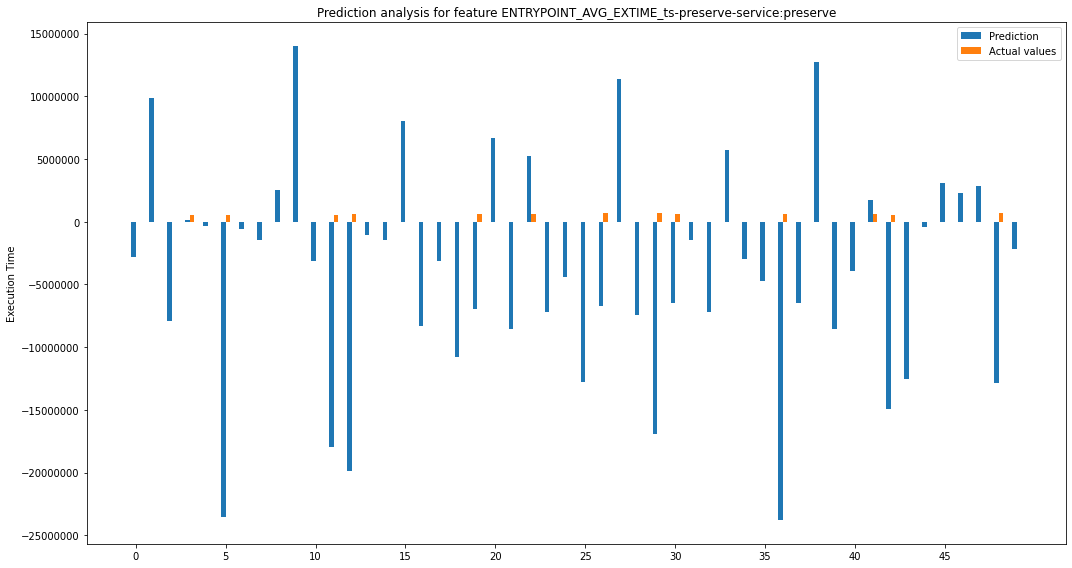

MAE:  7467700.69265625
MAPE:  105.05  %
MSE:  92735374379646.27
ENTRY ENTRYPOINT_AVG_EXTIME_ts-contacts-service:findContactsByAccountId
PRED [262.96, 373.24194, 404.09277, 2838.0188, 471.4674, 2290.072, 482.18735, 468.842, 381.7019, 632.0234, 440.3821, 2657.9397, 2322.6345, 383.16556, 494.72925, 584.28186, 204.35246, 631.61945, 176.18881, 2610.313, 333.9653, 373.15073, 2862.1204, 278.4026, 409.3257, 281.961, 2742.6519, 630.4961, 258.71417, 2335.505, 2972.5073, 288.4558, 169.39487, 693.4425, 419.0372, 300.8294, 2431.7751, 335.4825, 255.26613, 228.23848, 571.02814, 2710.5503, 2778.2, 275.2017, 358.47098, 436.42505, 529.8352, 473.17648, 2748.7817, 269.95032]
VALS [0.0, 0.0, 0.0, 2807.0, 0.0, 3137.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3153.0, 4291.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3292.0, 0.0, 0.0, 2533.0, 0.0, 0.0, 0.0, 2426.0, 0.0, 0.0, 1887.0, 2492.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1852.0, 0.0, 0.0, 0.0, 0.0, 2000.0, 2733.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1872.0, 0.0]


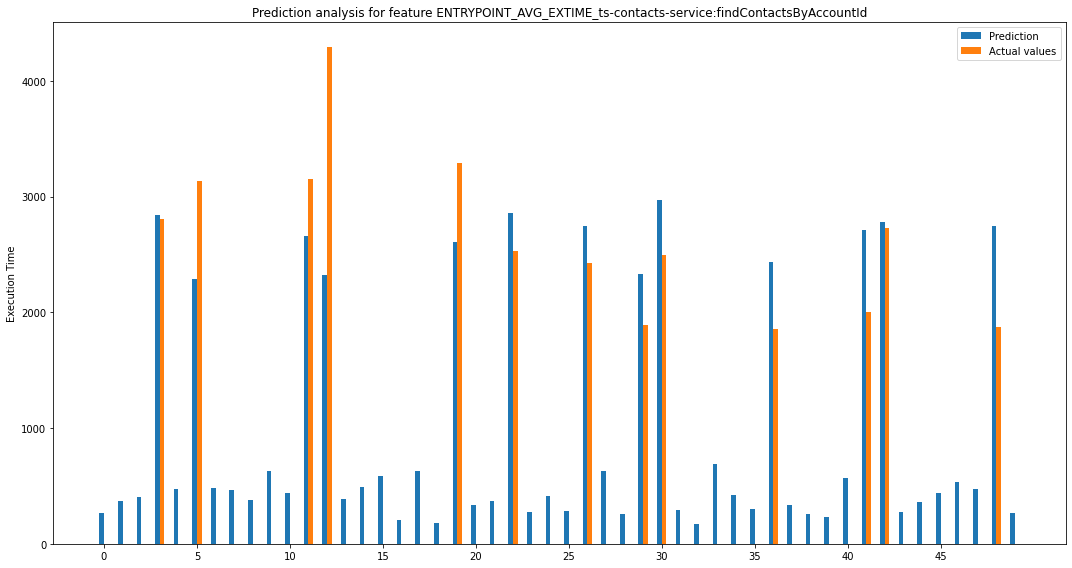

MAE:  447.43275482177734
MAPE:  80.19  %
MSE:  279435.84921338665
ENTRY ENTRYPOINT_AVG_EXTIME_ts-consign-service:updateConsign
PRED [-257.79126, 439.53314, -275.02664, -478.3518, -78.41318, -1038.4708, -182.1943, -5.8523264, 68.643555, 635.0201, -86.22597, -1251.1932, -996.46893, -133.16814, -85.975235, 294.47504, -298.97375, -215.47862, -237.84502, -714.88135, 330.85175, -437.7035, 173.94363, -300.9324, -308.10925, -608.2513, -646.1942, 413.02597, 11763.776, -1223.9557, -272.00873, -44.80727, -310.6875, 148.44669, -14.593569, -119.52119, 10700.819, 11500.11, 602.09375, -341.6116, -462.11575, -401.06696, -1067.7325, 11491.891, -49.075237, 65.91816, 36.752827, 322.94086, -1080.8108, -121.73057]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10009.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8678.0, 9838.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8584.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


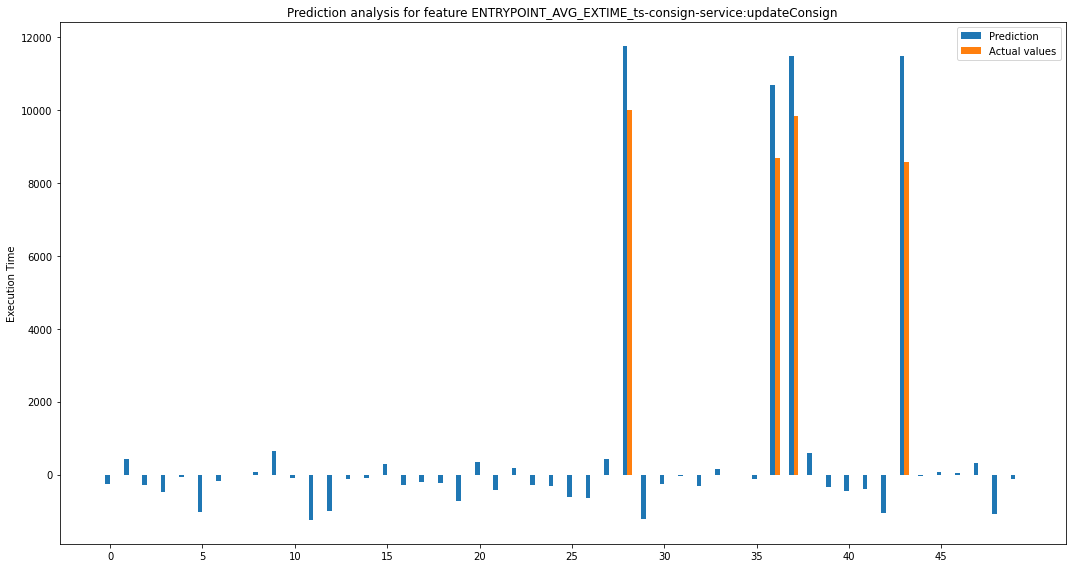

MAE:  520.5292150688172
MAPE:  93.47  %
MSE:  606631.6823360501
ENTRY ENTRYPOINT_AVG_EXTIME_ts-food-service:getAllFood
PRED [3179.3853, 6931.8833, 4114.4634, 20512.775, 5264.0503, 13488.685, 4319.527, 4172.8906, 6687.0327, 11296.482, 5040.951, 16164.897, 13348.532, 3229.6487, 5383.4614, 8914.125, 2567.478, 5618.2515, 17333.53, 2986.5562, 5824.346, 17930.18, 6014.9126, 4922.8438, 3362.237, 16874.037, 3173.7393, 10176.955, 2441.678, 29044.865, 2743.2585, 3072.8464, 2955.8757, 9425.622, 4071.8926, 5224.38, 12404.108, -392.79572, 7644.273, 2379.7512, 4984.8037, 21174.314, 17029.914, -655.9979, 4181.8086, 5378.664, 7555.8477, 8963.65, 17085.75, 3870.6833]
VALS [0.0, 0.0, 0.0, 17073.0, 0.0, 18719.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18260.0, 18824.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21081.0, 0.0, 0.0, 18163.0, 0.0, 0.0, 0.0, 23065.0, 0.0, 0.0, 0.0, 21214.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18761.0, 0.0, 0.0, 0.0, 0.0, 17800.0, 16284.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16503.0, 0.0]


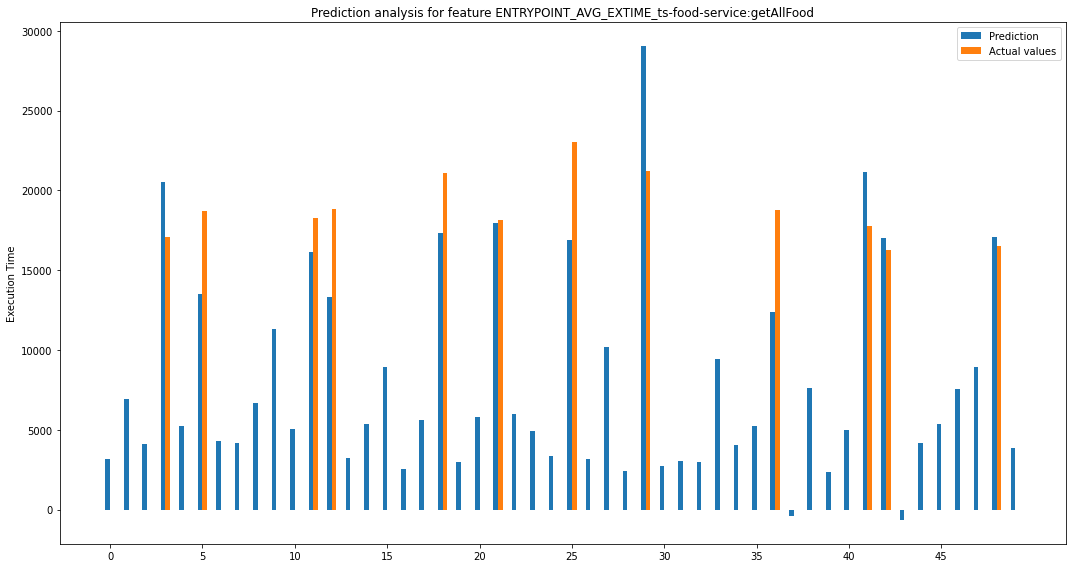

MAE:  4688.543997802734
MAPE:  81.42  %
MSE:  28291710.000267144
ENTRY ENTRYPOINT_AVG_EXTIME_ts-cancel-service:cancelTicket
PRED [-187.25777, 275.4764, 1330.5422, 679.4165, 1726.58, 236.63757, 662.11084, 540.84064, 1890.4856, 1885.5071, 959.62964, -3.2814522, 11290.069, 933.82935, -272.18555, 1987.1857, 1328.5192, 1051.7443, 9865.026, 3.4392772, 2075.7883, 385.7595, 1103.0637, 1118.31, 457.28625, 1295.643, -717.9316, 3188.8572, 3178.5945, -1.5014808, 1391.457, 189.78644, 285.36118, 1719.2212, 843.3816, 1180.8297, 1995.4138, 2090.3247, 794.0266, 425.98056, 253.25717, 1448.1401, 1807.5955, 2558.1428, 48.421837, 175.97604, 2256.1738, 2410.4246, 392.64865, -349.06775]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14383.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


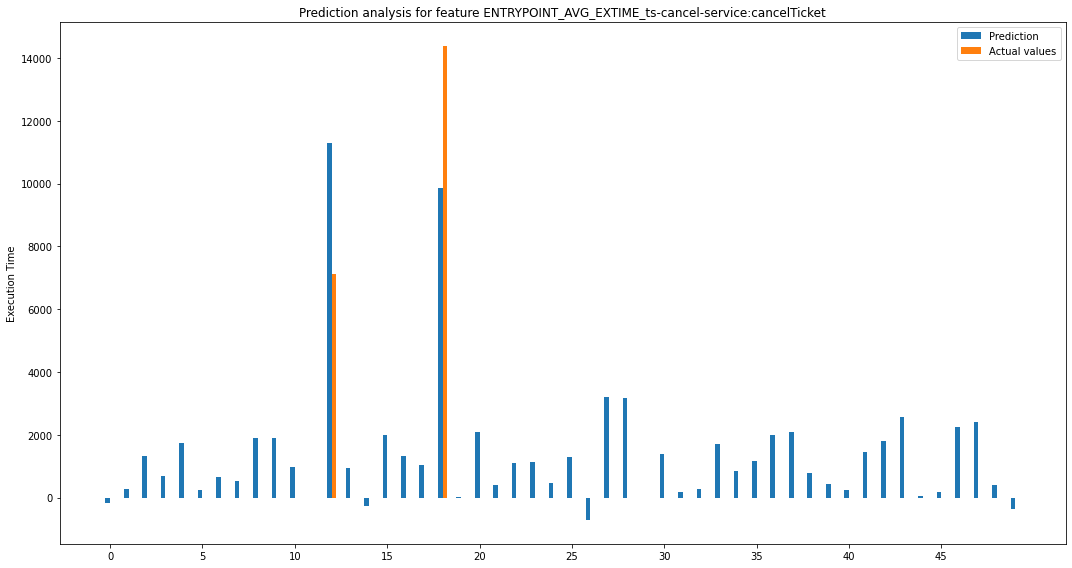

MAE:  1215.3615708208083
MAPE:  97.65  %
MSE:  2573630.0040530413
ENTRY ENTRYPOINT_AVG_EXTIME_ts-auth-service:getToken
PRED [7665.782, 66180.8, 7835.46, 68687.23, 10758.159, -1688.8483, 10240.779, 11254.045, 73580.375, 67560.22, 2369.0605, 5014.6616, 6156.5825, 11132.452, 5541.6187, 74857.18, 8474.279, 476.09283, 6063.306, 5821.4185, 71793.55, 6788.094, 66170.64, 6313.194, 10733.65, 3302.9006, 7468.9316, 74276.484, 60362.242, 5447.0347, 6264.4355, 6514.1885, 4687.796, 69719.28, 10634.086, 2135.4612, -2134.2688, 5137.3506, 72772.33, 5788.102, 9326.996, 72387.02, 8923.565, -811.86255, 11328.678, 10221.981, 70321.164, 61180.22, 10996.394, 6023.4517]
VALS [0.0, 118913.0, 0.0, 113854.00000000001, 0.0, 0.0, 0.0, 0.0, 119022.0, 117630.0, 0.0, 0.0, 0.0, 0.0, 0.0, 115062.0, 0.0, 0.0, 0.0, 0.0, 112623.0, 0.0, 115495.0, 0.0, 0.0, 0.0, 0.0, 121440.0, 116070.00000000001, 0.0, 0.0, 0.0, 0.0, 118055.99999999999, 0.0, 0.0, 0.0, 0.0, 114245.0, 0.0, 0.0, 114350.0, 0.0, 0.0, 0.0, 0.0, 114709.0, 114799.0,

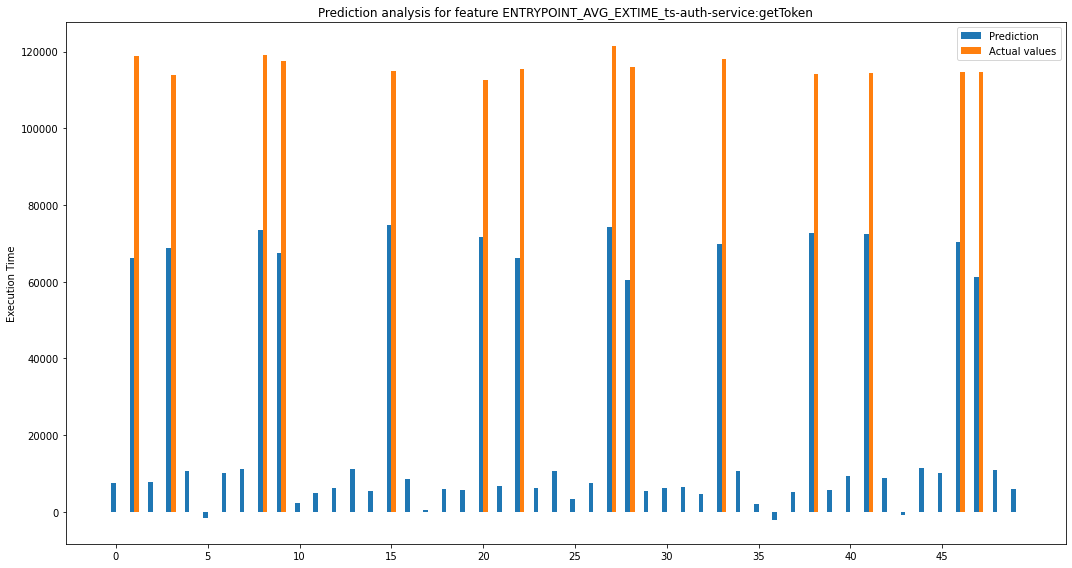

MAE:  17957.884837646485
MAPE:  91.15  %
MSE:  661523410.768265
ENTRY ENTRYPOINT_AVG_EXTIME_ts-assurance-service:getAllAssuranceType
PRED [-41.314537, 55.367767, -28.074493, 1504.3895, 58.611225, 1319.6075, 37.410183, 10.360458, -120.3636, 304.27338, 92.42745, 1426.3353, 1288.8691, -16.747393, 174.50897, 66.95934, -241.13234, 189.07953, 1486.5627, 82.25358, -105.40999, 1431.2319, 111.886444, 49.426083, -129.85274, 1383.4816, 87.63841, 67.291824, -196.30756, 2810.0425, 160.45457, -65.90435, -53.32288, 114.1865, 56.506466, 72.194214, 1296.2327, -80.55686, 17.396666, -123.053116, 77.59881, 1516.7039, 1417.9438, -112.40376, 35.03223, 142.00002, -7.0466695, 86.14514, 1355.8866, 104.20096]
VALS [0.0, 0.0, 0.0, 1622.0, 0.0, 1977.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1515.0, 1915.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1512.0, 0.0, 0.0, 2037.0, 0.0, 0.0, 0.0, 1117.0, 0.0, 0.0, 0.0, 1391.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2027.0, 0.0, 0.0, 0.0, 0.0, 1747.9999999999998, 2074.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1249.0, 0.0]


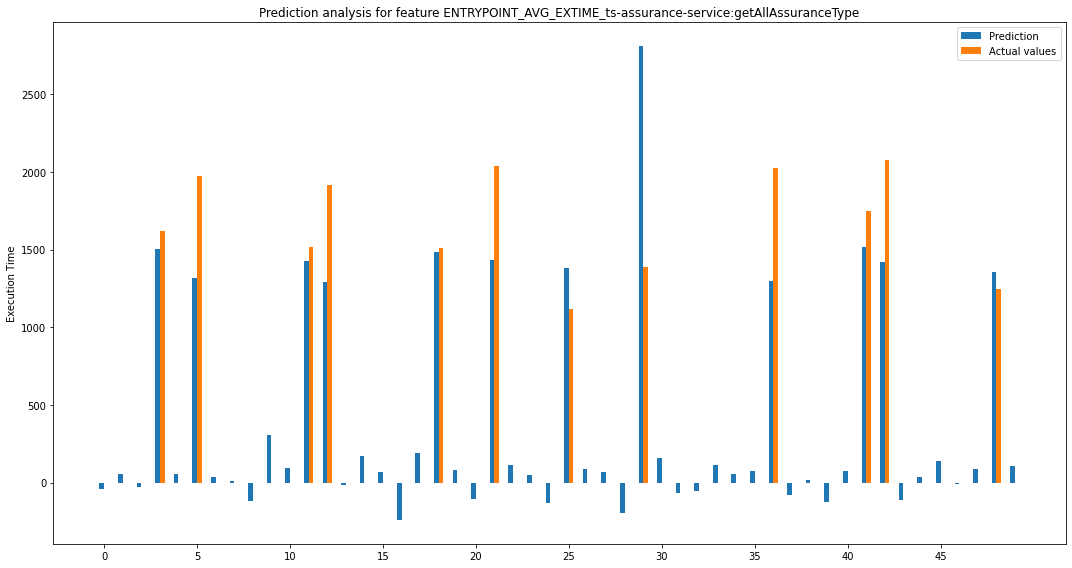

MAE:  182.12469132423402
MAPE:  83.04  %
MSE:  96358.1524550264
ENTRY ENTRYPOINT_AVG_EXTIME_ts-travel-service:queryInfo
PRED [-4364755.0, -6999472.5, -4423824.5, -3783675.8, -5675487.5, -870344.9, -5497045.5, -4764903.5, -1840863.2, -6298366.5, -5682591.0, -3218023.5, -2372270.2, -5126335.5, -5092342.0, -3901527.8, -3707665.5, -4208788.0, -6448429.5, -3319085.0, -5747197.5, -4451920.5, -5137092.5, -3883964.5, -2963253.2, -4677584.5, -4266466.0, -5804676.5, -1215033.5, -1623827.1, -5339379.5, -5837607.0, -5267791.5, -3765714.0, -6426692.0, -2584279.2, -779835.7, -4221645.5, -6898103.5, -4219034.5, -3074218.5, -2132130.0, -1027100.3, -3784738.5, -5055045.0, -5901207.0, -3794750.5, -4696881.5, -1136219.6, -6347504.0]
VALS [0.0, 0.0, 0.0, 0.0, 17683.5, 107856.0, 0.0, 0.0, 0.0, 0.0, 20124.0, 271214.0, 0.0, 0.0, 148761.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20620.0, 12831.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21126.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58730.0, 0.0, 0.0, 0.0, 0.0, 179298.5, 98392.0, 14597.5, 0.0

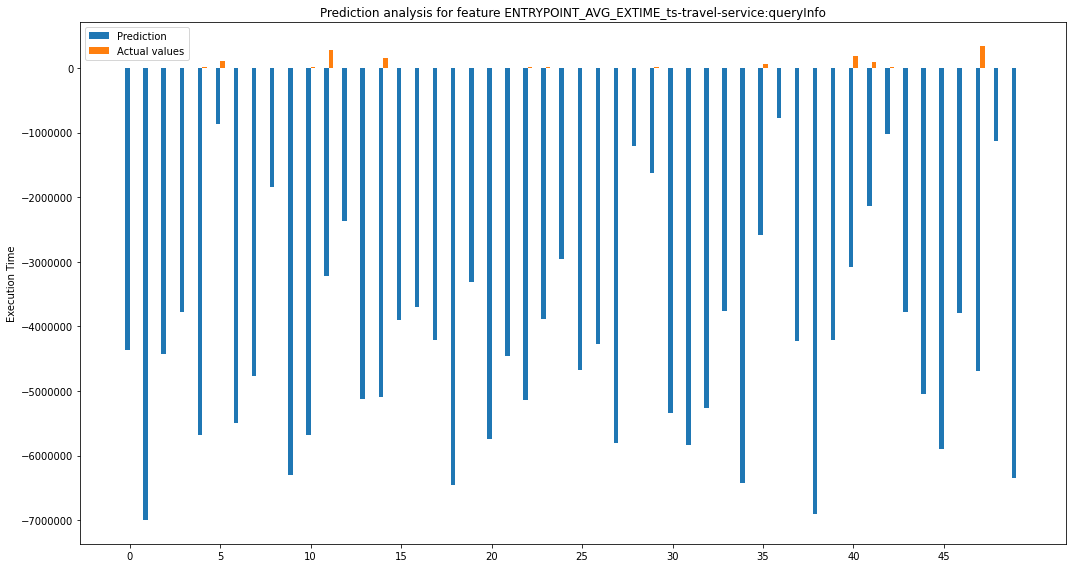

MAE:  4219324.0625
MAPE:  100.96  %
MSE:  20506214440185.562
ENTRY ENTRYPOINT_AVG_EXTIME_ts-order-service:POST
PRED [305627.25, -227961.84, 431406.34, 36100.44, 348993.3, 766080.56, 201113.6, 227748.11, -55677.766, -127148.94, 436516.94, 698750.44, 781230.6, 204260.02, 230081.14, -156553.58, 512340.25, 345458.3, 777988.8, 93302.65, -38954.234, 461589.2, -120327.336, 426590.5, 243491.42, 746324.2, 191856.61, -67703.78, 404440.28, 736194.1, 350131.3, 215996.06, 310923.9, 728.10657, 267531.2, 429457.62, 978372.7, 494084.8, -275980.1, 351553.4, 279838.12, 71874.14, 738575.6, 679190.2, 141878.44, 155935.27, -13887.327, 218628.66, 596426.44, 132072.45]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


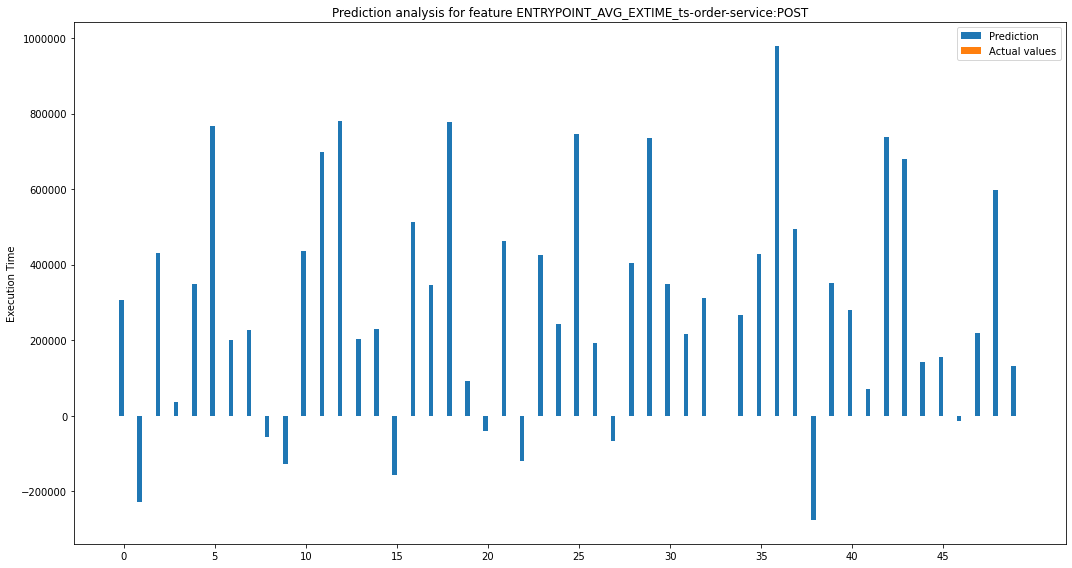

MAE:  342097.5687524414
MAPE:  100.0  %
MSE:  176206100252.16266
MAE:  196.40152888188302
MAPE:  0.96
MSE:  269206.01858195075
MAE:  11586368.206256537
MAPE:  1.05
MSE:  353473868712112.94
MAE:  7671464.834367918
MAPE:  1.19
MSE:  316885590342669.56
MAE:  15920.869250367634
MAPE:  2.72
MSE:  945133507.7486231
MAE:  8671437.254719917
MAPE:  1.17
MSE:  468067003473627.44
MAE:  386.4468764290595
MAPE:  0.83
MSE:  309832.336109898
MAE:  606.4104786682328
MAPE:  0.96
MSE:  1930806.5421139032
MAE:  4653.724702681014
MAPE:  0.86
MSE:  32912586.99962821
MAE:  1136.221189880026
MAPE:  1.0
MSE:  27290835.289132055
MAE:  14287.45968466526
MAPE:  0.91
MSE:  473144450.02958983
MAE:  178.47943744796868
MAPE:  0.86
MSE:  130309.22866968597
MAE:  4908285.291475449
MAPE:  1.09
MSE:  184957268001124.78
MAE:  331736.9887644067
MAPE:  1.0
MSE:  224729911239.14883
Loading datasource from avv_dataset_DT_500.csv
Datasource loaded: len = 2589
Entrypoints size: 13
Entrypoint list
[   'ENTRYPOINT_N_INVOC_API_ts

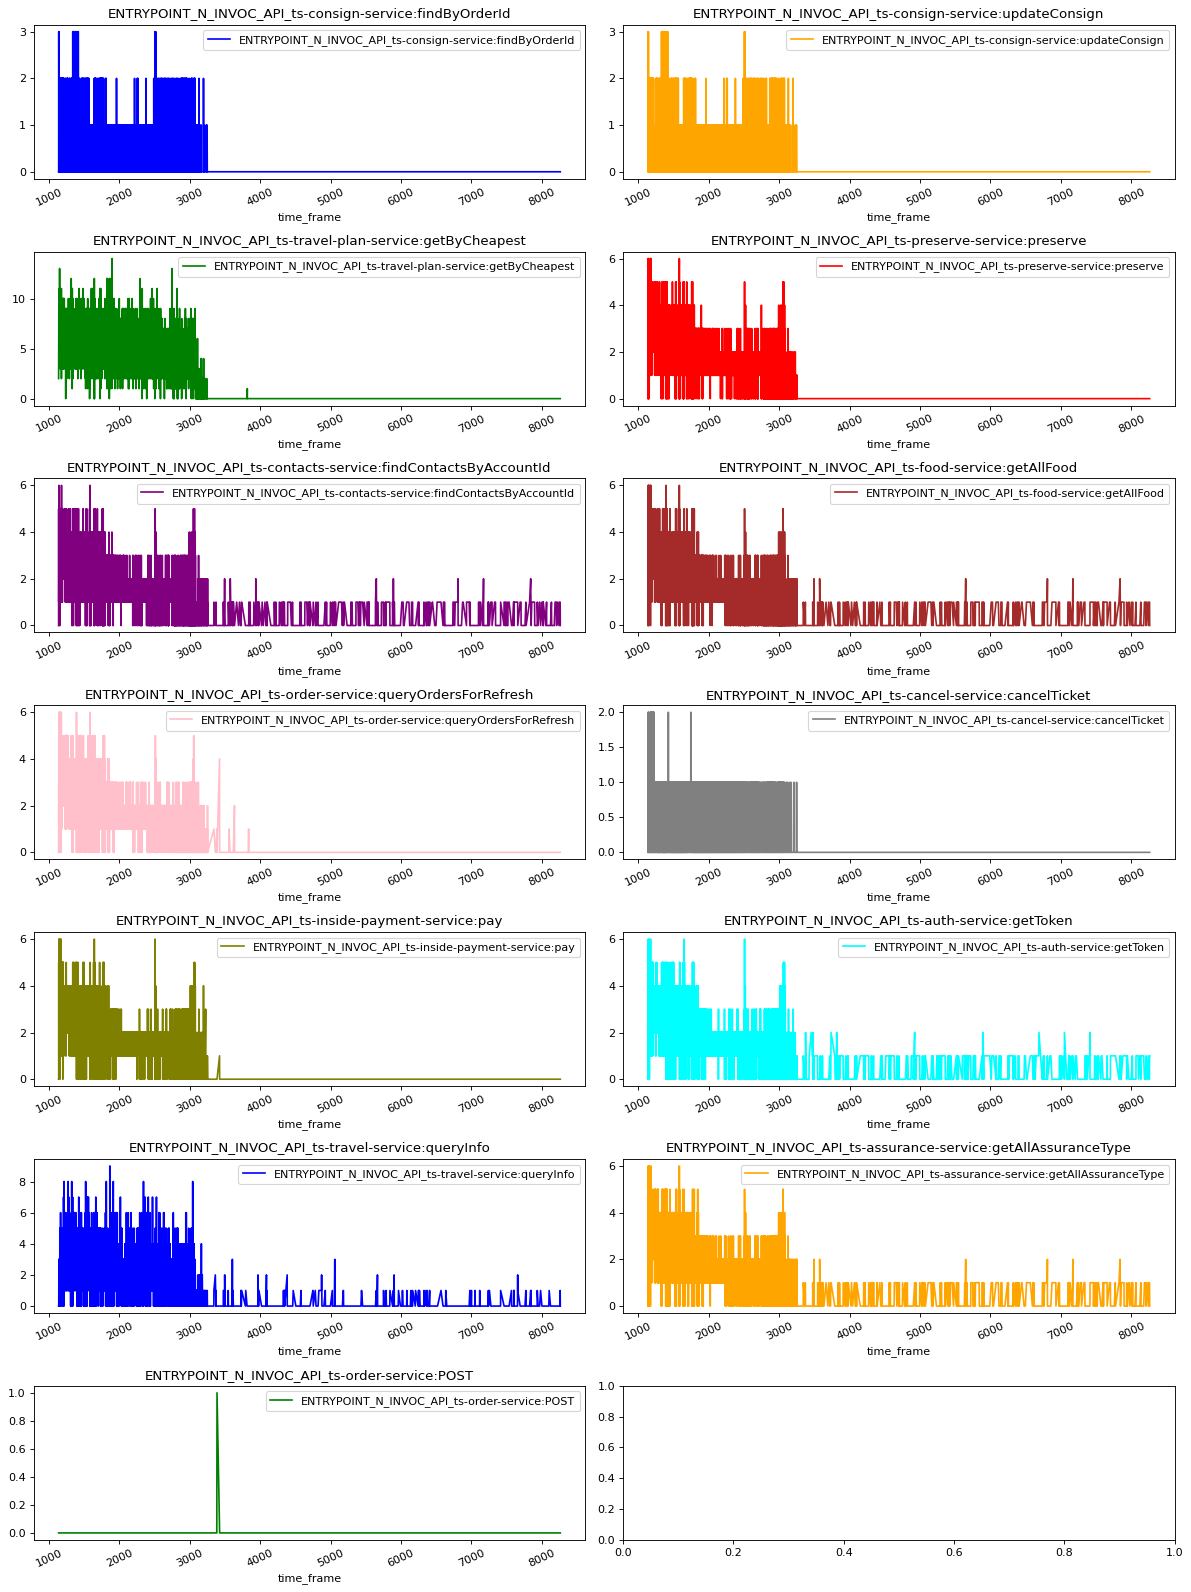

Data normalized
Input size 45 Output size 13
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                2944      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 13)                429       
                                                                 
Total params: 5,453
Trainable params: 5,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
44/44 [==============================] - 1s 5ms/step - loss: 58.0595 - val_loss: 0.8754
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 0.3780 - val_loss: 0.0360
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss:

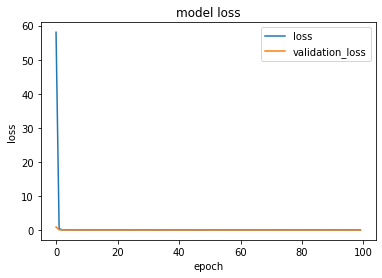

27/27 [==============================] - 0s 973us/step
TOTAL MSE:  0.017002377528425306
TOTAL MAE:  0.06039271799870592
TOTAL MAPE:  1.23
FIRST 50 predictions
ENTRY ENTRYPOINT_AVG_EXTIME_ts-consign-service:findByOrderId
PRED [353.52307, 640.0592, 697.67065, 3818.3875, 345.4733, 1205.0236, 3651.2947, 6003.3477, 615.7211, 791.2894, 686.3141, 6038.02, 559.70135, 1253.511, 1313.1714, -175.14313, 3861.7327, 248.4482, 1042.1085, 359.597, 6087.254, 3237.281, 557.09344, 817.9295, 6010.1045, 825.845, 1120.6921, 1026.3683, 298.40857, 779.2666, 4131.15, 213.78893, 293.48102, 6273.4336, 3266.0852, 851.48596, 627.6211, 5811.5195, 432.21143, 235.49265, 596.4008, 938.389, 525.52893, 835.73065, 3320.06, 267.15567, 3717.0535, 3433.3325, 619.01184, 3426.6816]
VALS [0.0, 0.0, 0.0, 2606.0, 0.0, 0.0, 10929.0, 2662.5, 0.0, 0.0, 0.0, 3108.0, 0.0, 0.0, 0.0, 0.0, 2995.0, 0.0, 0.0, 0.0, 2638.0, 2520.0, 0.0, 0.0, 2542.5, 0.0, 0.0, 0.0, 0.0, 0.0, 2866.0, 0.0, 0.0, 2637.0, 3089.0, 0.0, 0.0, 2459.0, 0.0, 0.0, 0.0, 

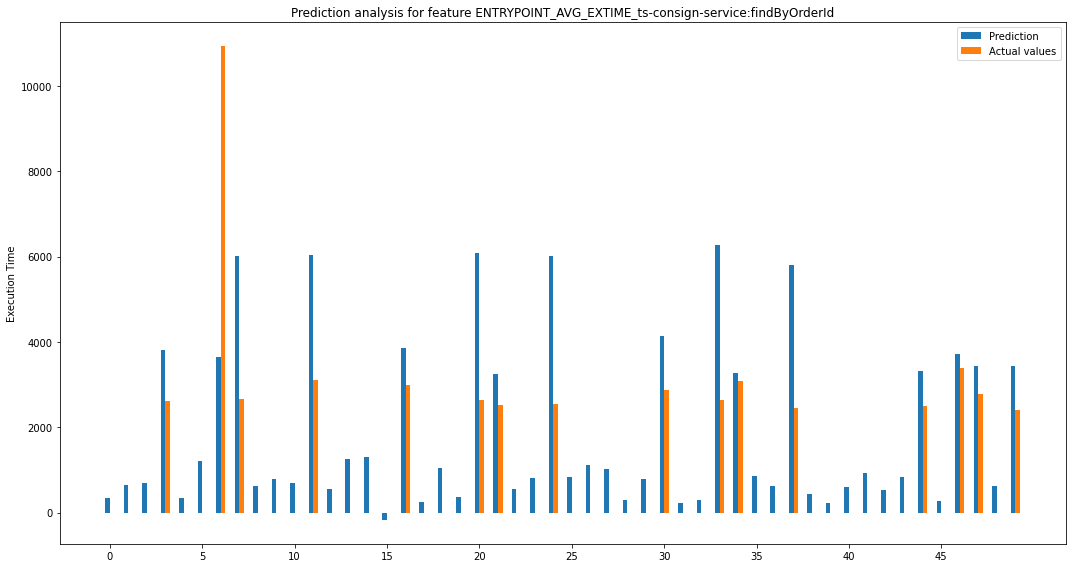

MAE:  1133.916098022461
MAPE:  82.58  %
MSE:  2911377.144926976
ENTRY ENTRYPOINT_AVG_EXTIME_ts-consign-service:updateConsign
PRED [-67.13187, -1387.0594, -299.90402, 8643.422, -703.382, -97.66898, 7847.765, 16367.723, -235.15414, -461.74146, -530.3741, 13835.286, 1469.061, 324.79776, -242.64716, -1295.1538, 8300.499, -992.29, -80.72976, -910.4919, 15818.931, 8424.453, -213.36917, -764.8487, 15831.996, 30.925938, -83.70407, -464.7939, -1353.29, -86.298645, 8740.492, -922.69073, -1213.6046, 17155.305, 7930.5317, -912.20526, -759.80493, 16643.98, -1136.3488, -169.45764, -1237.2683, -93.373764, -742.22614, 168.06406, 7423.1646, -669.053, 8266.77, 8407.902, -1397.7721, 7967.2974]
VALS [0.0, 0.0, 0.0, 11405.0, 0.0, 0.0, 7794.999999999999, 8791.5, 0.0, 0.0, 0.0, 8275.5, 0.0, 0.0, 0.0, 0.0, 9774.0, 0.0, 0.0, 0.0, 8226.0, 8238.0, 0.0, 0.0, 7240.5, 0.0, 0.0, 0.0, 0.0, 0.0, 9400.0, 0.0, 0.0, 8601.0, 6362.0, 0.0, 0.0, 8243.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8543.0, 0.0, 7161.0, 7105.0, 0.0, 7876.0]


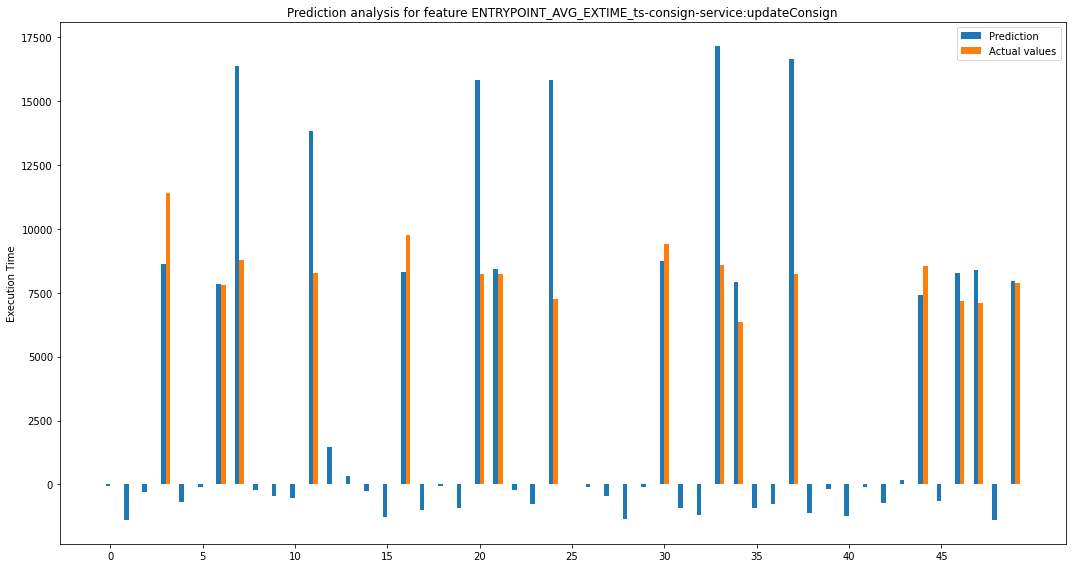

MAE:  1562.290989151001
MAPE:  76.28  %
MSE:  8032039.208344131
ENTRY ENTRYPOINT_AVG_EXTIME_ts-travel-plan-service:getByCheapest
PRED [-13113317.0, -6823129.0, -9650581.0, -7770325.0, -7509648.5, -7365079.0, -8377210.0, -3953347.8, -12713365.0, -4020489.2, -103907.01, -9245152.0, -13044302.0, -8990310.0, -4463739.0, -4085575.0, -12578241.0, -7213032.5, 3154396.5, -11892618.0, -6539831.5, -12211221.0, -6050752.0, -2695938.8, -15356823.0, -3146014.8, -10947248.0, -9683409.0, -10162568.0, -7229311.5, -7138398.0, -4495551.5, -8525066.0, -8738817.0, -7162551.0, -3946505.8, -7514578.0, -7709994.0, -7459310.5, -6038877.5, -6307483.5, -8707465.0, -896691.06, -9560397.0, -11595819.0, -4779913.0, -3541236.0, -13633662.0, 2477488.8, -19744530.0]
VALS [404106.0, 176877.75, 200708.25, 185580.0, 171333.4, 201230.0, 503628.75, 425051.75, 315618.0, 293970.6, 317892.3333333333, 287759.8571428572, 0.0, 204176.625, 69653.14285714286, 425364.0, 205616.2857142857, 261350.0, 248010.8, 344701.75, 45157.33333

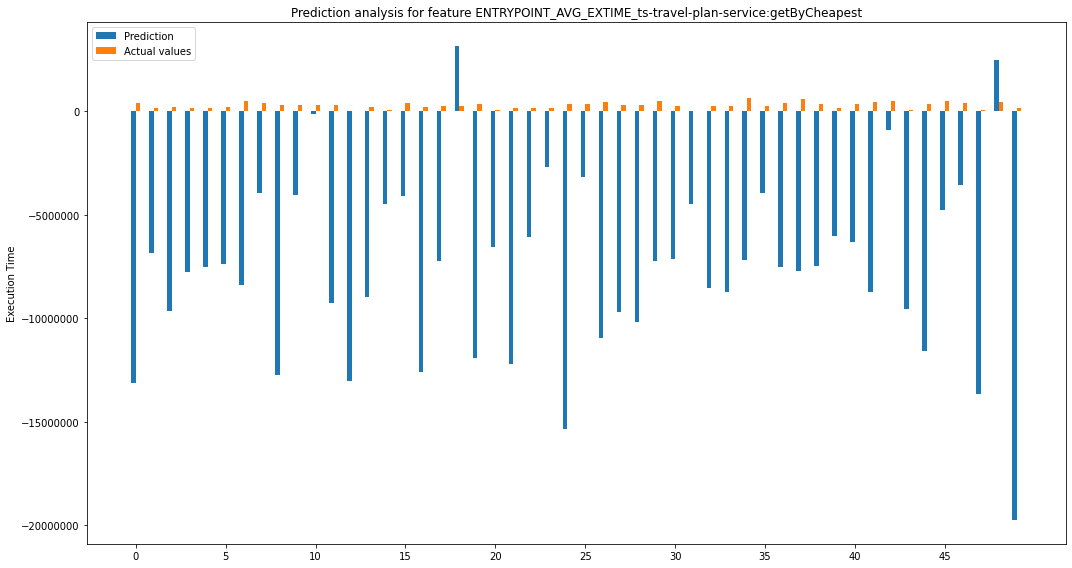

MAE:  8065568.84085863
MAPE:  110.62  %
MSE:  80004205903152.58
ENTRY ENTRYPOINT_AVG_EXTIME_ts-preserve-service:preserve
PRED [-11511925.0, -7031831.5, -10856461.0, -9449326.0, -7743812.0, -9099103.0, -15610632.0, -11487961.0, -11371263.0, -3038789.0, -12960701.0, -12331677.0, -5423654.0, -5343378.0, -12736885.0, -3280152.0, -11277935.0, -6865466.0, -4684179.5, -10482809.0, -8609510.0, -12827299.0, -8044006.5, -10018355.0, -11877354.0, -12190556.0, -10305524.0, -6141407.0, -10665383.0, -4671568.0, -14264534.0, -8101955.5, -4067793.5, -13692255.0, -8760202.0, -9152901.0, -8361737.5, -10578153.0, -10238236.0, -4454479.0, -9087091.0, -6531871.5, -4466631.5, -11325761.0, -10402517.0, -5699832.0, -8459487.0, -12309298.0, -3803209.5, -15045123.0]
VALS [0.0, 793143.3333333334, 840598.0, 753645.0, 0.0, 566403.0, 1150030.6666666667, 1030009.0000000001, 0.0, 894302.0, 1071079.0, 883376.5, 0.0, 610853.0, 977024.0, 1196106.0, 837676.0, 755736.0, 1028131.0, 1129953.0, 1047607.9999999999, 0.0, 63678

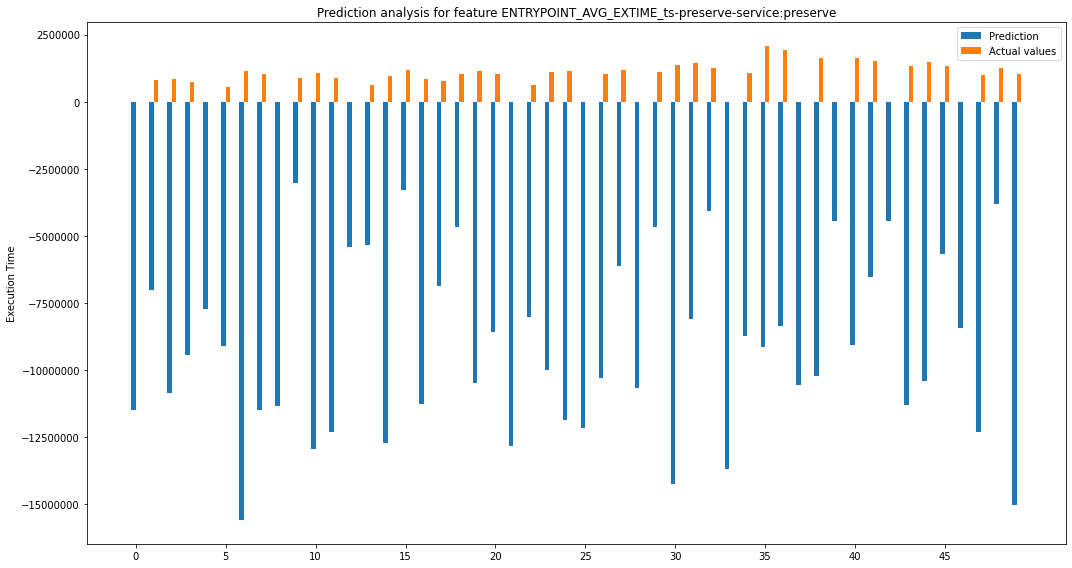

MAE:  9998087.566666666
MAPE:  111.32  %
MSE:  110565458609965.84
ENTRY ENTRYPOINT_AVG_EXTIME_ts-contacts-service:findContactsByAccountId
PRED [1997.1763, 2699.8428, 2262.1292, 2116.5503, 1872.5936, 2144.6504, 2928.3809, 1980.3395, 1950.4193, 2153.0579, 2383.4375, 2780.612, 1621.8392, 2199.551, 2494.4153, 2174.9775, 2300.3528, 2013.1584, 2212.3252, 2659.7234, 2414.3032, 1674.8007, 2123.9714, 3103.0557, 1984.7133, 1800.0889, 2268.6428, 2797.2927, 1636.9598, 2736.2268, 1938.3662, 2551.2798, 2203.224, 1811.6252, 2506.8745, 2193.6995, 2730.53, 1899.9349, 2111.34, 1863.1722, 2768.0823, 2106.0413, 2172.4365, 2394.5112, 2488.712, 2196.538, 2031.3981, 1911.201, 3085.7134, 2053.0237]
VALS [0.0, 2516.6666666666665, 2113.0, 3125.0, 0.0, 2200.0, 2359.6666666666665, 2360.0, 0.0, 2518.0, 2273.0, 2176.0, 0.0, 3013.0, 2685.0, 2567.0, 2384.0, 2466.0, 2809.0, 2323.5, 2384.0, 0.0, 3311.0, 2286.6666666666665, 2232.0, 0.0, 2367.0, 2385.6666666666665, 0.0, 2750.5, 2333.0, 2297.5, 2300.0, 0.0, 2045.0, 2472.0

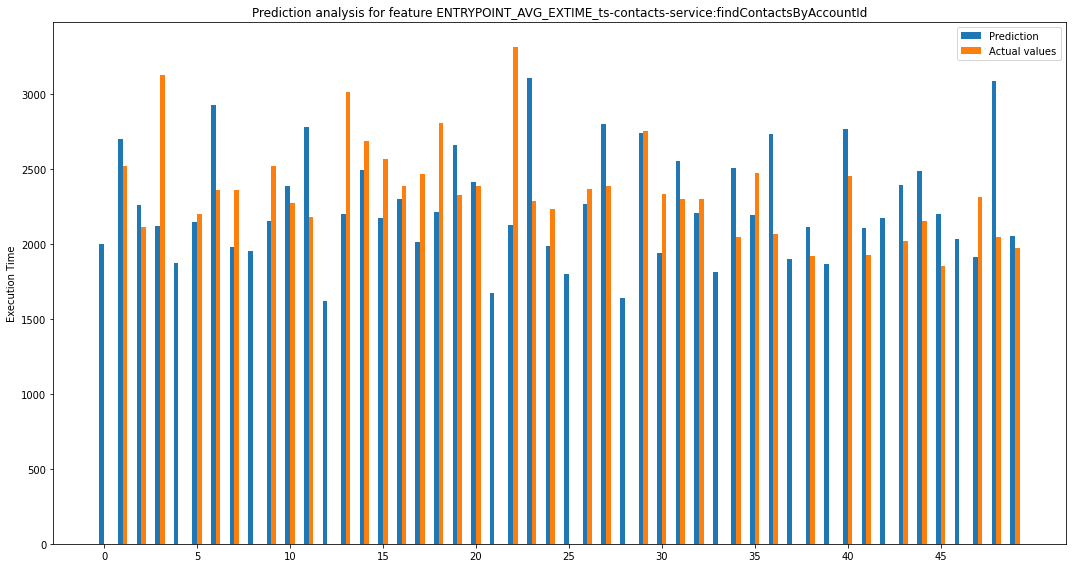

MAE:  736.9922322591146
MAPE:  36.25  %
MSE:  1010459.0782903726
ENTRY ENTRYPOINT_AVG_EXTIME_ts-food-service:getAllFood
PRED [15293.62, 22168.926, 17053.783, 18345.02, 15203.52, 17470.39, 22469.574, 18288.582, 14891.058, 18901.154, 19773.982, 21694.07, 13551.65, 16825.703, 21178.824, 16939.592, 16993.748, 18155.008, 18053.818, 19539.014, 18470.896, 16283.049, 18828.607, 23176.027, 16616.123, 14422.223, 18204.666, 21187.027, 16403.004, 18497.4, 17891.598, 19446.629, 18353.379, 15676.629, 17072.94, 20996.805, 20981.244, 16541.562, 15929.509, 14661.617, 23821.21, 16065.457, 14371.803, 20381.652, 19773.229, 17173.424, 15514.27, 18259.762, 22452.5, 17503.564]
VALS [0.0, 15441.333333333334, 16447.0, 19268.0, 0.0, 15625.000000000002, 20642.33333333333, 17183.0, 0.0, 16268.000000000002, 23310.5, 16448.0, 0.0, 18637.0, 19046.0, 17546.0, 19908.0, 18524.0, 21914.0, 16979.0, 16936.0, 0.0, 15893.000000000002, 17585.0, 19429.0, 0.0, 17269.0, 16972.666666666668, 18283.0, 20708.0, 15886.0, 19549.5, 24

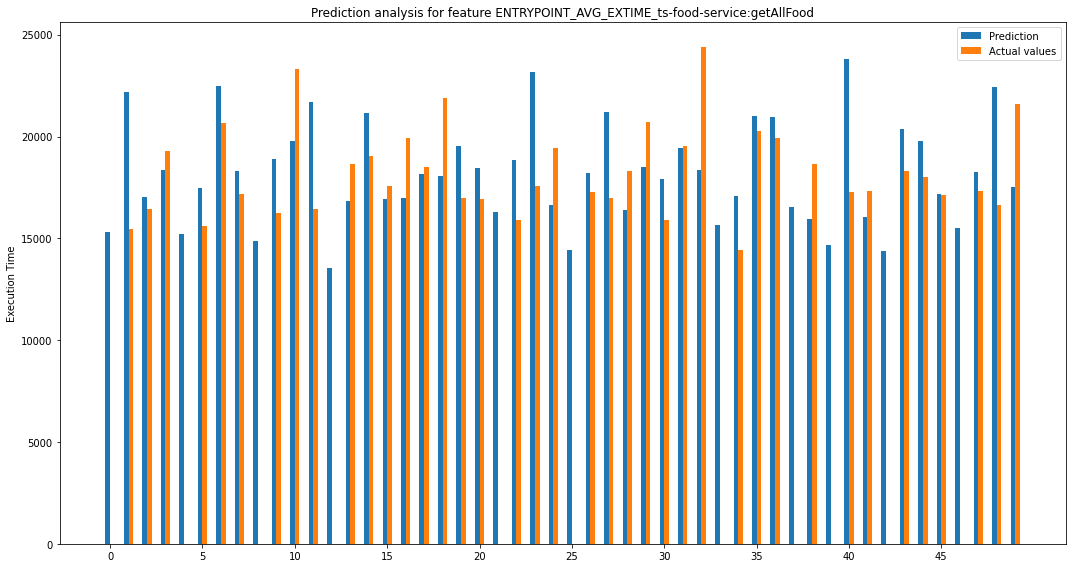

MAE:  5302.77939453125
MAPE:  32.13  %
MSE:  58047807.25762888
ENTRY ENTRYPOINT_AVG_EXTIME_ts-order-service:queryOrdersForRefresh
PRED [9561714.0, 11448483.0, 7863405.5, 1815239.1, 11664501.0, 4406374.0, 4674978.0, 487090.53, 6325543.0, 9591253.0, 3941496.8, 4347390.0, 7287178.5, 4637531.5, 13207772.0, 4853424.0, 1507427.6, 12373065.0, 16028036.0, 2798837.0, -4740345.0, 6897242.0, 5113177.0, 16971404.0, -2263248.0, 7397239.5, 6624095.0, 5694325.0, 17573964.0, 5574265.5, -2747886.0, 10517030.0, 10991560.0, -4324909.5, 2695567.5, 11853637.0, 9729674.0, -480723.66, 8221586.5, -545241.44, 20403346.0, 5057541.5, 3051563.0, 4652702.0, 12261778.0, 8406320.0, -989351.56, 5617545.0, 7437390.0, 9381649.0]
VALS [4048675.0, 4780592.0, 4602167.5, 4420321.0, 4737215.5, 0.0, 4949888.0, 0.0, 4001117.5, 4633511.0, 0.0, 4475536.0, 4082519.5, 4649189.5, 0.0, 4693822.0, 4104099.5, 4233502.0, 4636355.0, 4508550.0, 3804275.0, 3908553.5, 4616744.0, 4599052.0, 0.0, 3725475.5, 4359635.5, 0.0, 4687071.0, 418957

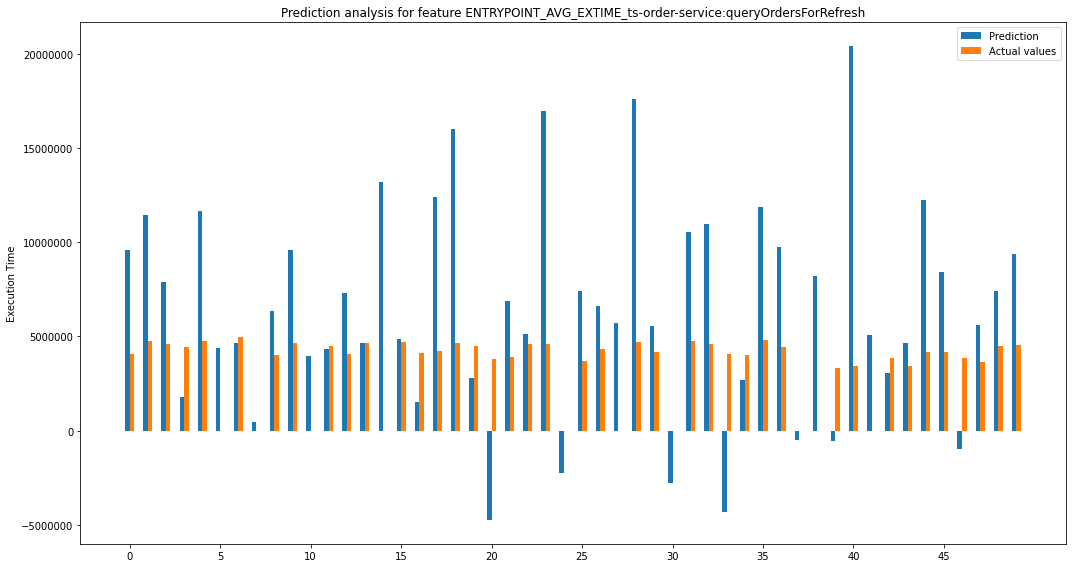

MAE:  4697925.737083334
MAPE:  88.22  %
MSE:  36542066870801.734
ENTRY ENTRYPOINT_AVG_EXTIME_ts-cancel-service:cancelTicket
PRED [-1729.2877, 3513.3784, 2821.1406, 15020.453, 3690.469, 4579.6987, 3484.1934, 4661.7856, 4895.169, 3537.1475, 3091.3142, 4241.0015, 3496.1104, 14391.786, 1642.477, 3792.222, 14221.517, 1839.0049, 1357.747, 4024.4878, 9056.657, -371.8478, 2984.7332, 3622.991, 4290.3037, 2831.6987, 6018.2847, 14412.654, 1827.5647, 12404.712, 6715.0825, 1534.4064, 2031.5276, 6785.396, 3262.923, 2336.2568, 3381.271, 2927.715, 1693.2358, 3851.7747, 770.6268, 11871.304, 10372.453, 8970.3955, 400.20322, 2477.093, 11085.951, -820.5819, 7929.132, 54.62662]
VALS [0.0, 0.0, 0.0, 5733.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6846.0, 0.0, 0.0, 5515.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6044.0, 0.0, 4973.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6843.0, 0.0, 10273.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


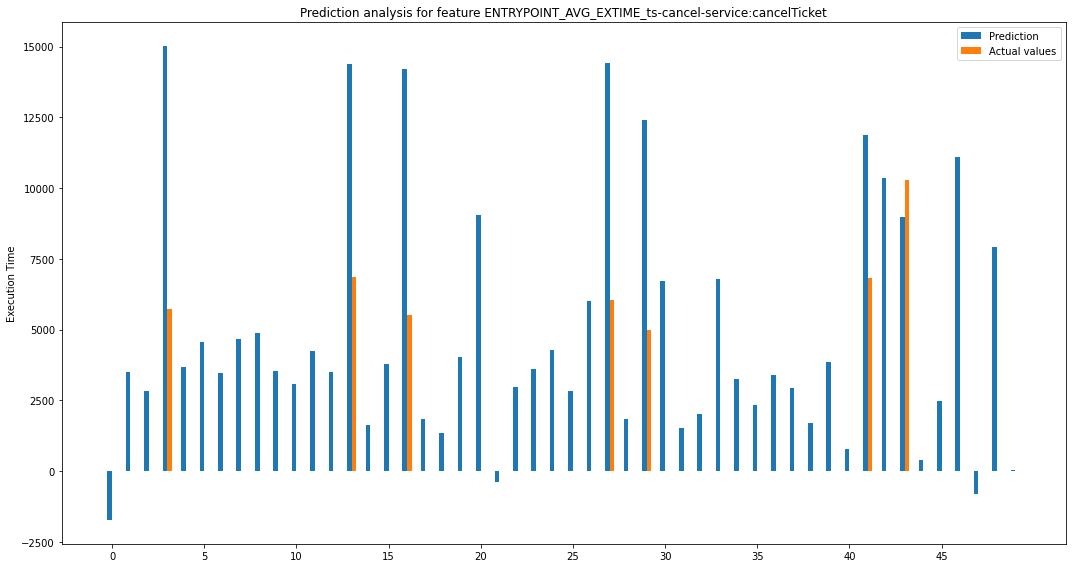

MAE:  4070.040048294067
MAPE:  93.01  %
MSE:  24005497.30267776
ENTRY ENTRYPOINT_AVG_EXTIME_ts-inside-payment-service:pay
PRED [18831.477, 17962.148, 19998.781, 20341.047, 11075.173, 24647.064, 25121.883, 20646.281, 18488.293, 15833.903, 28029.584, 35173.68, 605.037, 22179.402, 23469.057, 16891.842, 27681.887, 12318.86, 30840.648, 6736.8403, 26876.543, 13821.859, 46.156044, 56251.383, 4306.559, 22797.523, 21854.428, 16924.023, 17746.568, 21328.62, 30189.295, 12928.204, 21396.078, 24506.918, 8700.217, 40151.117, 14237.438, 13606.79, 28025.027, -6055.042, 44643.57, 20247.361, 19789.582, 21886.814, 16587.162, 18238.719, 22671.54, 13832.051, 27169.863, 17392.637]
VALS [5158.0, 0.0, 13670.0, 4436.0, 5046.5, 0.0, 4495.0, 4899.0, 8261.5, 0.0, 5693.0, 16478.0, 4728.0, 4711.0, 0.0, 5169.0, 7327.333333333333, 6884.0, 0.0, 5169.0, 63561.666666666664, 4313.0, 0.0, 4283.0, 39560.0, 0.0, 3830.0000000000005, 11292.0, 4382.0, 10618.0, 0.0, 21112.0, 0.0, 10347.666666666666, 4488.0, 0.0, 4440.0, 5683.66

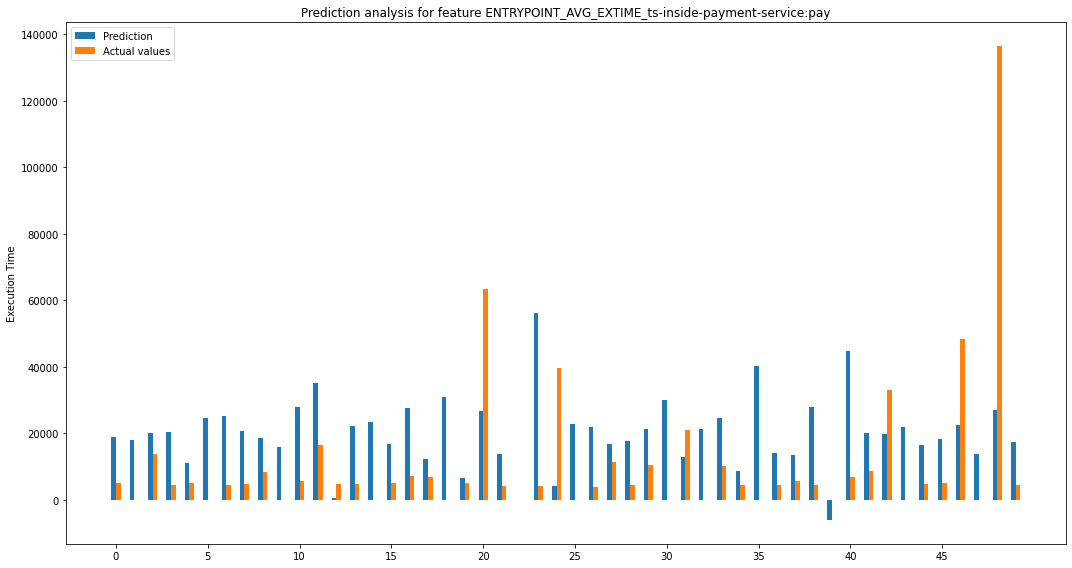

MAE:  18869.973090769447
MAPE:  110.66  %
MSE:  635335940.5060842
ENTRY ENTRYPOINT_AVG_EXTIME_ts-auth-service:getToken
PRED [101650.5, 97235.34, 108925.13, 93424.05, 97774.65, 108076.99, 112395.5, 91382.22, 100151.84, 110103.69, 107110.086, 89283.32, 90204.67, 99744.25, 119766.61, 93363.57, 93950.695, 98437.625, 120764.06, 91211.28, 97298.87, 100061.3, 109638.305, 108311.89, 91289.695, 95822.22, 113038.234, 95388.016, 101354.445, 97386.15, 114478.766, 94177.805, 95195.336, 107198.28, 89294.71, 118986.375, 95980.1, 92661.87, 93807.17, 97696.555, 121065.33, 88728.664, 94748.664, 99702.21, 111359.83, 93704.17, 104795.1, 102111.85, 109888.79, 92803.875]
VALS [114700.00000000001, 115079.0, 118258.0, 0.0, 112827.0, 114467.5, 116908.5, 0.0, 115700.0, 115404.5, 117454.0, 0.0, 0.0, 112751.0, 116350.0, 115500.0, 0.0, 117389.0, 113213.66666666669, 114614.99999999999, 0.0, 116551.0, 125459.49999999999, 117887.00000000001, 0.0, 118074.0, 115984.99999999999, 117248.0, 118651.99999999999, 116006.0, 1

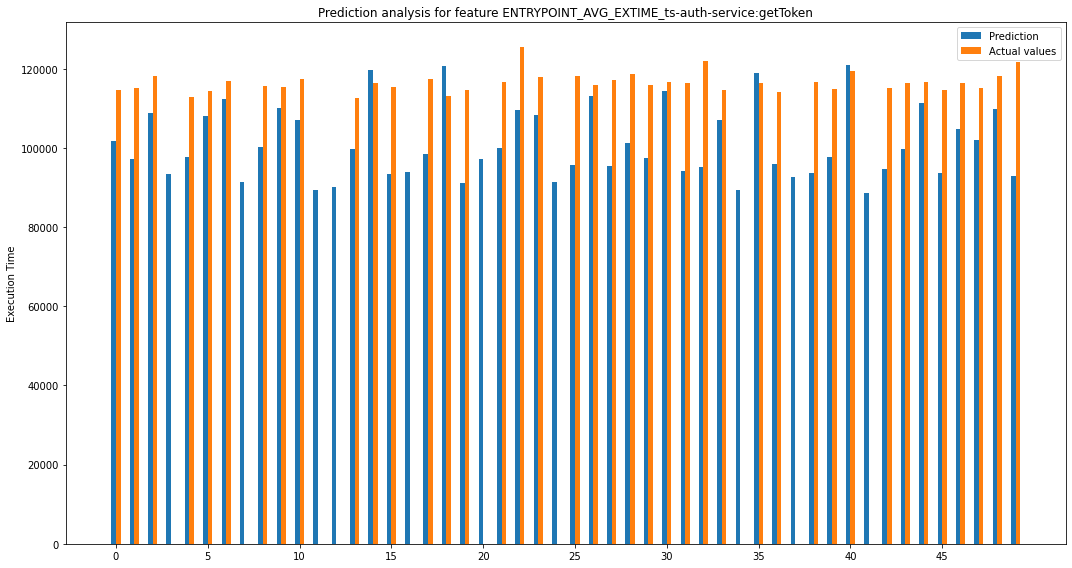

MAE:  29487.21552083333
MAPE:  31.27  %
MSE:  1883317664.9856458
ENTRY ENTRYPOINT_AVG_EXTIME_ts-travel-service:queryInfo
PRED [1483077.4, -4934917.0, 2580409.2, -4892855.0, -579317.5, 303761.0, -78055.234, -3858378.5, 5450624.0, -2223273.8, -2143316.8, 587595.7, 1913597.8, -5454120.0, 1180407.1, -2118258.5, -1711076.5, 765562.2, 2565139.5, -11457018.0, 7048575.0, 803680.9, -8951238.0, 5276447.0, -2291974.0, -1335063.4, 3443295.8, -5554325.0, 769421.56, -4035589.8, 2336693.0, -3457419.0, -371468.53, 713250.3, 5201999.5, -4972169.0, -1988199.1, -892699.06, 1039538.56, -2325464.2, 4479170.5, -6129923.0, -440546.44, 739119.56, 175002.02, -3966847.5, 994973.5, 3600483.0, -4595652.0, -2665903.8]
VALS [106259.0, 37812.25, 332183.0, 105566.0, 103241.0, 115018.0, 100369.0, 294190.5, 0.0, 22203.0, 0.0, 50465.75, 0.0, 262793.0, 115228.49999999999, 0.0, 100112.75, 45840.0, 240488.0, 173603.0, 0.0, 12901.5, 142066.0, 143065.0, 354467.0, 369788.0, 0.0, 87801.0, 67064.5, 21849.0, 108610.0, 363599.0, 

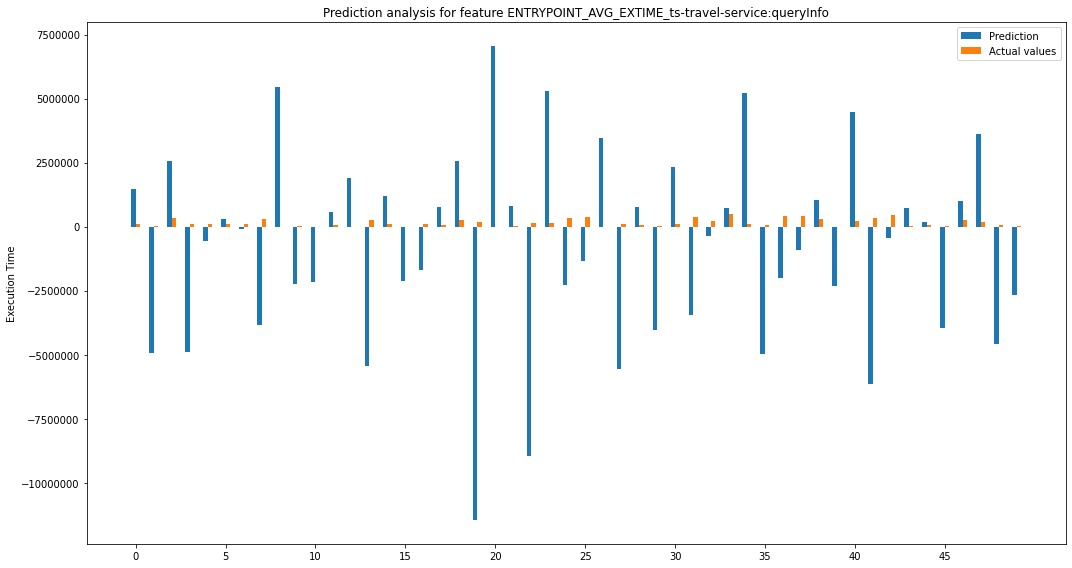

MAE:  2968914.200625
MAPE:  103.72  %
MSE:  14667443877585.37
ENTRY ENTRYPOINT_AVG_EXTIME_ts-assurance-service:getAllAssuranceType
PRED [1376.5363, 1860.9403, 1607.2671, 1508.2988, 1253.1237, 1520.2343, 2027.6132, 1438.0647, 1394.4567, 1448.2667, 1970.7944, 1701.8944, 1070.5718, 1553.2004, 1647.2749, 1502.672, 1663.6321, 1427.965, 1755.7689, 1474.8159, 1621.9072, 1256.6368, 1394.8859, 1987.6274, 1637.9633, 1141.6309, 1667.9089, 2013.6758, 1464.8013, 1591.4664, 1569.3081, 1623.0334, 1432.705, 1397.8464, 1581.4022, 1670.3724, 1807.0264, 1212.5592, 1452.2158, 1166.8143, 2080.9065, 1448.436, 1389.7075, 1823.7413, 1692.8688, 1421.8706, 1439.9105, 1519.0162, 1983.8151, 1517.7167]
VALS [0.0, 1553.6666666666667, 1266.0, 1881.0, 0.0, 1788.0, 1756.6666666666667, 4494.0, 0.0, 2036.9999999999998, 4398.0, 1750.0, 0.0, 2343.0, 1695.0, 1572.0, 2186.0, 2017.0, 1474.0, 1780.0, 1907.0, 0.0, 1636.0, 1883.6666666666667, 1605.0, 0.0, 1684.0, 1824.3333333333333, 1554.0, 1618.0, 2033.0, 1677.5, 1687.0, 0.0, 

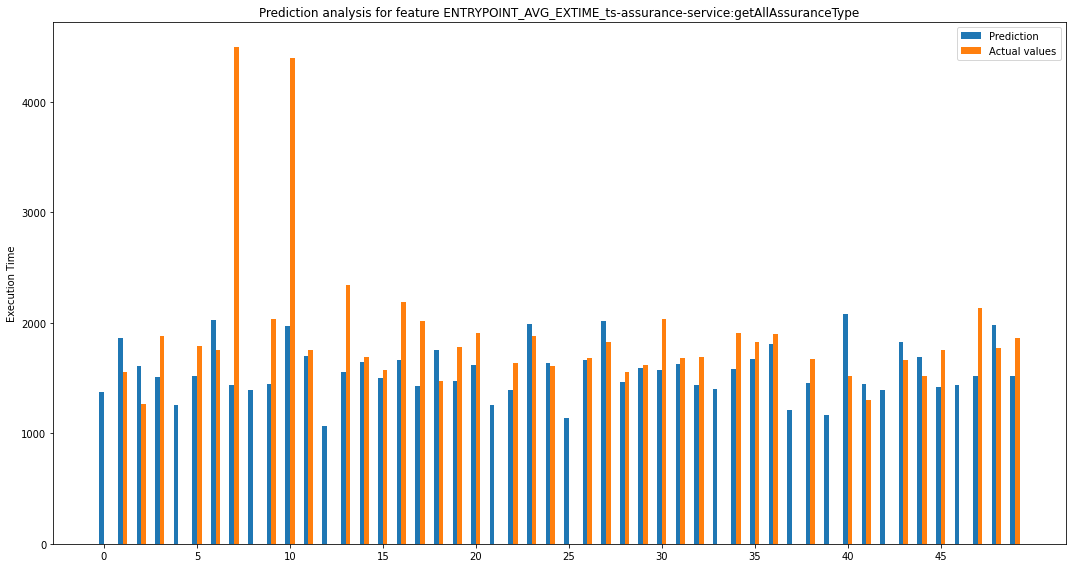

MAE:  589.6200162760416
MAPE:  41.1  %
MSE:  748700.9286907304
ENTRY ENTRYPOINT_AVG_EXTIME_ts-order-service:POST
PRED [-80204.73, -50056.527, -183159.31, -272990.4, -268305.66, -296221.03, -112854.92, -348145.8, -240286.36, -260952.11, -74899.03, -150183.44, -373501.1, -250387.11, -209043.88, -133270.16, -254678.45, -143876.2, -161011.77, -81939.7, -465018.62, -30623.65, -201231.92, 144989.16, -466990.28, -252565.03, -352723.4, -235909.72, -237804.08, -158934.05, -333769.16, -83039.33, -57840.23, -375785.6, -73162.984, -298672.4, -116586.6, -167397.34, -142505.27, -198452.75, 108393.53, -211348.12, -564650.4, -213885.3, 196156.5, -177969.81, -619280.75, 5565.804, -253861.88, -286690.62]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


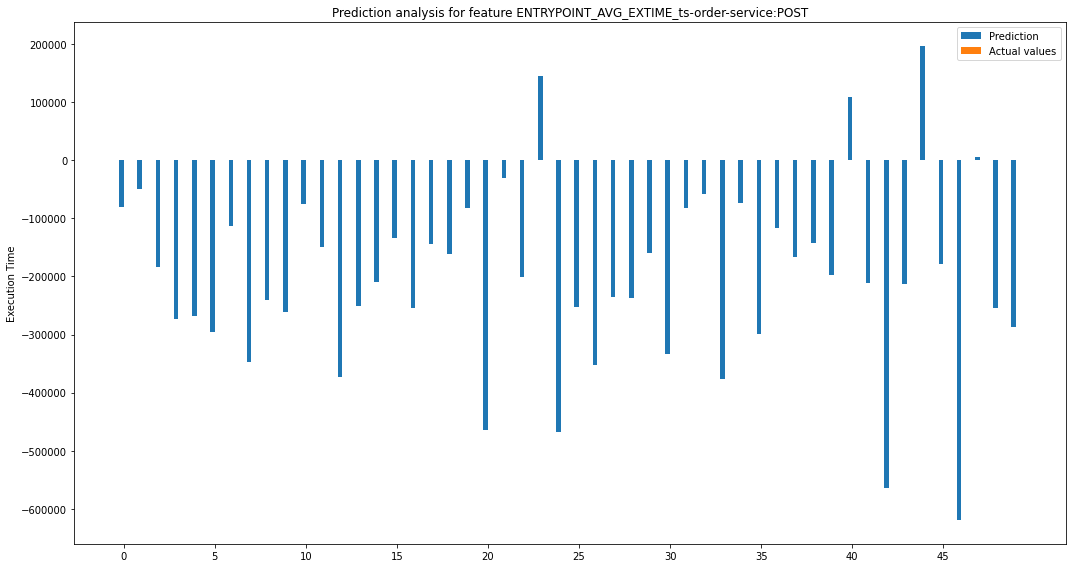

MAE:  219555.43924804687
MAPE:  100.0  %
MSE:  64980566850.36552
MAE:  420.9948917298986
MAPE:  0.93
MSE:  554155.8399360359
MAE:  1145.89707038779
MAPE:  0.93
MSE:  2928478.5026099333
MAE:  5738287.816135346
MAPE:  1.52
MSE:  775849392215466.2
MAE:  7049708.463060428
MAPE:  2.24
MSE:  1025312250253658.4
MAE:  1239.8551363358674
MAPE:  0.68
MSE:  1993782.543174631
MAE:  11395.781177433602
MAPE:  0.7
MSE:  163619190.1603099
MAE:  9422396.692908747
MAPE:  1.37
MSE:  1099965708215307.1
MAE:  1990.3127261743211
MAPE:  1.02
MSE:  57922832.6920631
MAE:  21774.00577185975
MAPE:  1.57
MSE:  2182340756.341364
MAE:  54368.1243128655
MAPE:  0.64
MSE:  4148797397.514556
MAE:  3086129.488653029
MAPE:  2.61
MSE:  640545551997631.5
MAE:  800.4608850752029
MAPE:  0.72
MSE:  834759.4594988194
MAE:  155419.57792777792
MAPE:  1.05
MSE:  394229717992.64557
Loading datasource from avv_dataset_DT_1000.csv
Datasource loaded: len = 1497
Entrypoints size: 13
Entrypoint list
[   'ENTRYPOINT_N_INVOC_API_ts-consi

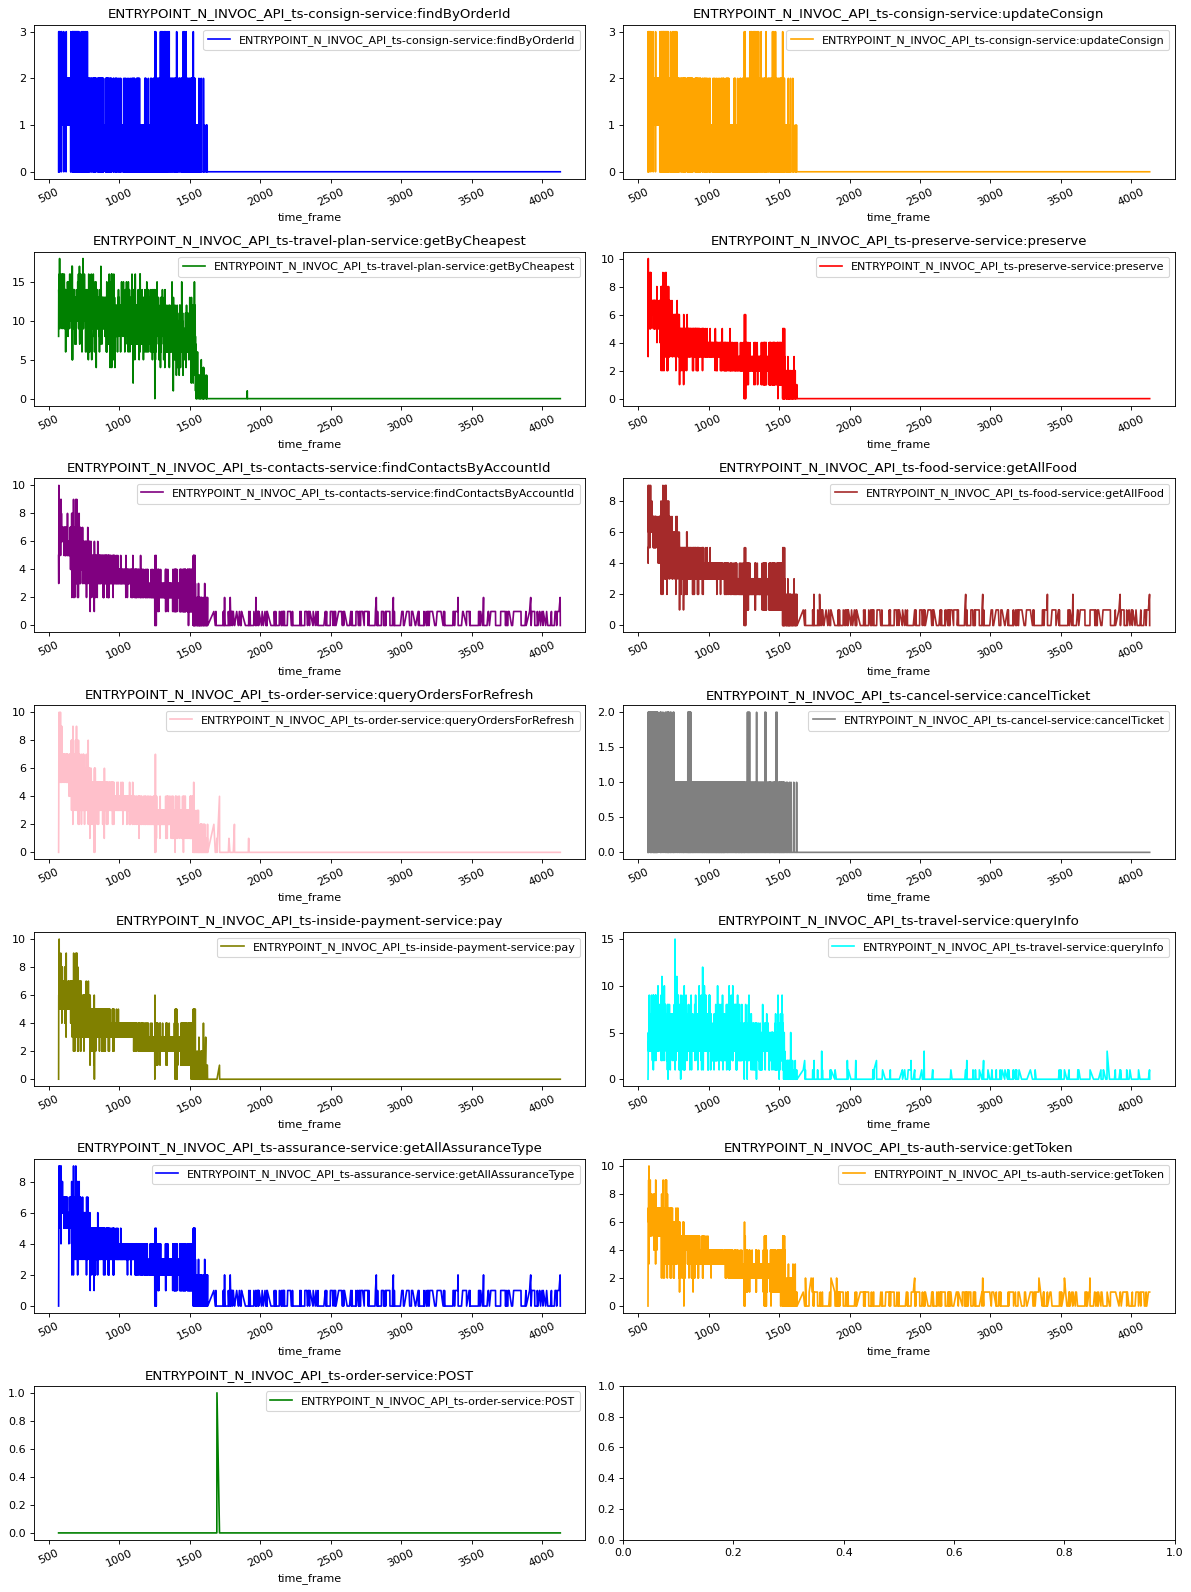

Data normalized
Input size 45 Output size 13
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                2944      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 13)                429       
                                                                 
Total params: 5,453
Trainable params: 5,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
26/26 [==============================] - 0s 7ms/step - loss: 41.3776 - val_loss: 3.9224
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 2.1301 - val_loss: 0.2022
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss:

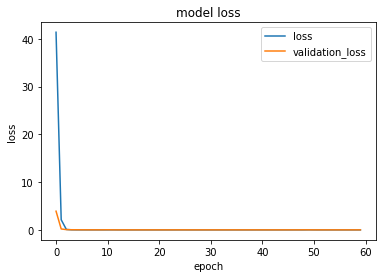

16/16 [==============================] - 0s 1ms/step
TOTAL MSE:  0.037911585207940045
TOTAL MAE:  0.09293037795564961
TOTAL MAPE:  1.45
FIRST 50 predictions
ENTRY ENTRYPOINT_AVG_EXTIME_ts-consign-service:findByOrderId
PRED [-624.1551, -697.5913, 717.76917, -655.955, -310.9172, -749.3378, -579.2016, -700.48645, -1107.5028, -428.2581, 2828.517, -155.22815, -566.0822, -1011.6759, -268.68826, -675.7139, -931.89044, -460.74704, -552.6403, -460.30997, -328.28598, -796.87854, -1018.6224, -414.89398, -331.1547, 2453.449, 1095.9072, -7.1326056, -881.0948, -877.1326, 762.3665, -270.2105, -867.5637, -448.6874, -377.7082, -362.59476, -661.1148, -776.6322, 819.1002, -559.3224, -746.4873, -1003.0537, -547.4048, -771.3874, 891.9822, -560.9939, -615.19073, -963.2092, -699.42566, -26.962566]
VALS [0.0, 0.0, 2135.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2964.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3367.5, 3974.0, 0.0, 0.0, 0.0, 2443.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 271

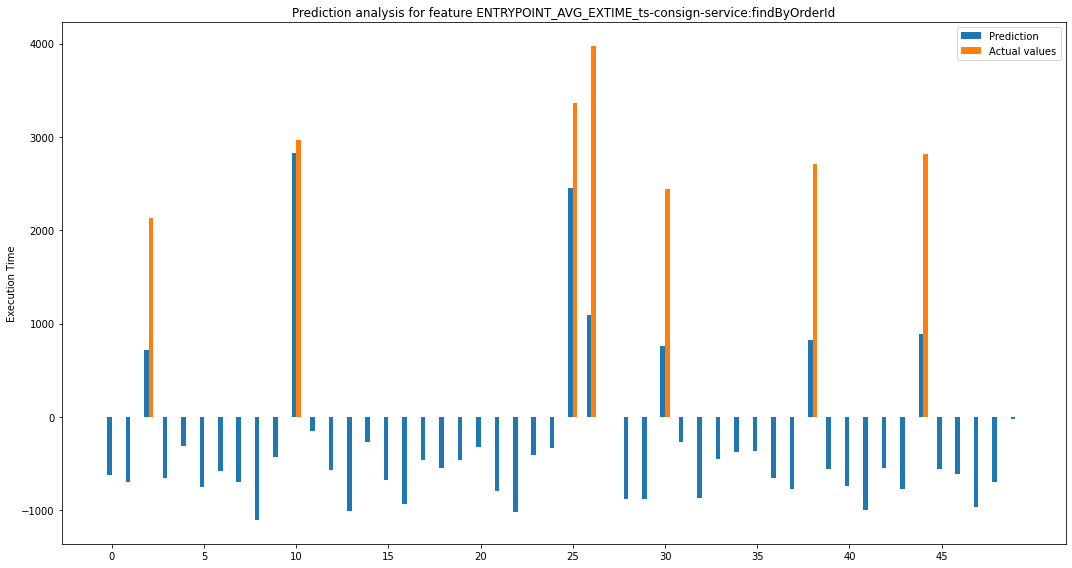

MAE:  733.8487021446228
MAPE:  109.39  %
MSE:  795640.7085416594
ENTRY ENTRYPOINT_AVG_EXTIME_ts-consign-service:updateConsign
PRED [-1486.5914, -1488.3947, 4183.1245, -934.9973, -1180.5643, -1719.9269, -1979.6416, -912.7396, -896.47955, -863.5141, 11342.965, 615.7158, -1447.7155, -776.63055, -231.98012, -1274.525, -476.9932, -1409.6763, -2124.6394, -1009.5342, -545.7342, -1920.9137, -1108.3164, -1588.9059, -1541.7817, 9397.143, 6416.9077, -1638.7926, -2887.8523, -977.2275, 3966.2798, 210.2911, -1012.37854, -1535.4105, -809.66504, -208.64586, -1747.2805, -2038.2814, 4171.114, -800.7752, -2010.6317, -1002.6734, -1594.4734, -1882.8771, 3564.3062, -514.4245, -1061.2708, -377.38028, -1822.5311, -2824.5928]
VALS [0.0, 0.0, 9051.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8613.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9223.5, 8318.0, 0.0, 0.0, 0.0, 9070.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10064.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10286.0, 0.0, 0.0, 0.0, 0.0, 0.0]


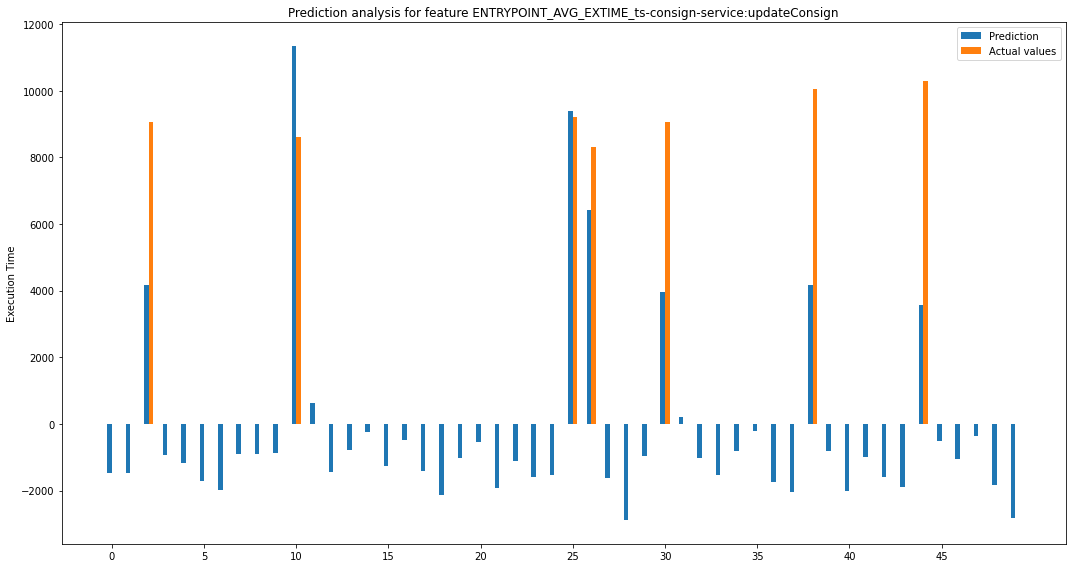

MAE:  1637.684849243164
MAPE:  98.61  %
MSE:  4544941.466048917
ENTRY ENTRYPOINT_AVG_EXTIME_ts-travel-plan-service:getByCheapest
PRED [-4029309.0, -4758533.0, -17064058.0, -5979558.5, -14492717.0, 3983195.0, -7072244.5, -10881490.0, 1407755.0, -21804980.0, -4757314.5, -5115879.5, -10388064.0, -20136430.0, -9418932.0, -5383479.0, -23577624.0, 9131533.0, -4270835.5, -2356709.2, -2547840.5, -7594702.5, -3982664.8, -25541500.0, 15298544.0, -8612441.0, -13810255.0, 6073747.0, -10557922.0, -11907583.0, -10857678.0, 5239840.0, -40911536.0, 7530304.5, -3263093.2, -19827308.0, -3869263.8, -1156252.8, -15860590.0, -10051309.0, -13180272.0, -15579505.0, 654984.8, -2635267.8, -8691078.0, -8023621.5, -2632965.5, -18714124.0, -3247299.0, -9047361.0]
VALS [40085.333333333336, 44399.333333333336, 2760259.6666666665, 0.0, 8911395.333333334, 0.0, 35183.0, 1363169.5, 5479339.0, 42212.0, 44440.2, 10459955.4, 0.0, 52157.0, 3451363.6666666665, 8710909.0, 9603947.0, 7154098.5, 0.0, 0.0, 8522911.0, 0.0, 0.0, 

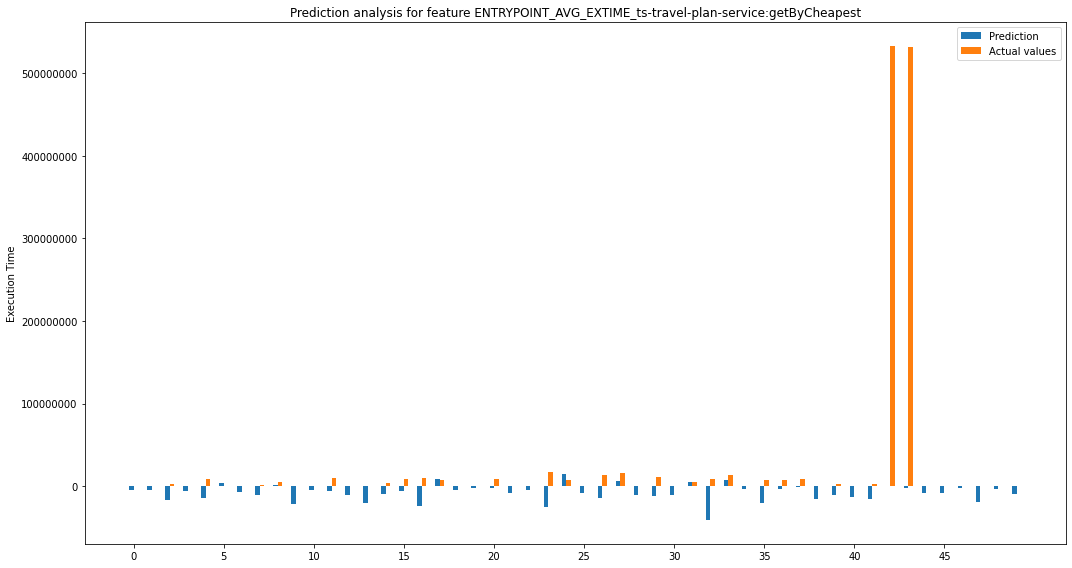

MAE:  33478586.084083337
MAPE:  2169.79  %
MSE:  1.1614869289618514e+16
ENTRY ENTRYPOINT_AVG_EXTIME_ts-preserve-service:preserve
PRED [4612458.5, 1590873.1, 9092747.0, 9392499.0, 13929603.0, -3672133.2, -3699334.8, 19246984.0, 13760596.0, 14614929.0, 12954303.0, 16535407.0, -5451497.5, 23304748.0, 9451374.0, 7204083.5, 7227504.0, -3477956.5, -5058036.5, 3376261.8, -850340.2, 1477016.6, 14427256.0, 19890746.0, -10819500.0, 5536671.0, 18665244.0, -13032549.0, 12729270.0, 9382171.0, 11368565.0, 3635112.2, 28557216.0, -3174296.8, 2584599.2, 13429481.0, -3125086.0, 9443304.0, 6422805.0, -1848439.9, 9543898.0, 6500600.0, 9704440.0, 5184718.0, 8838242.0, 11036646.0, 5857529.5, 216327.36, 1055042.1, -6750872.5]
VALS [0.0, 0.0, 21314541.0, 0.0, 22226563.5, 0.0, 0.0, 0.0, 0.0, 0.0, 19705647.0, 23757149.0, 0.0, 25664345.5, 33719265.0, 0.0, 30123849.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25191240.0, 0.0, 27583589.0, 0.0, 0.0, 0.0, 25418013.0, 0.0, 0.0, 283820847.6666667, 0.0, 0.0, 473406485.5, 0.0, 4057

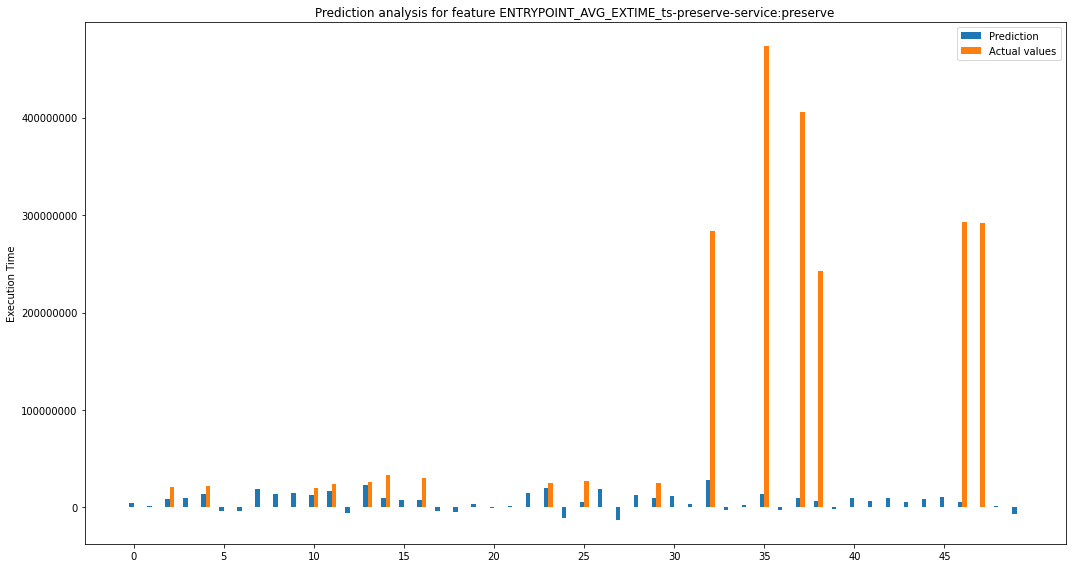

MAE:  46116294.16489584
MAPE:  3137.77  %
MSE:  1.32446904011571e+16
ENTRY ENTRYPOINT_AVG_EXTIME_ts-contacts-service:findContactsByAccountId
PRED [1600.5148, 1655.2241, 1879.775, 1511.7877, 2117.651, 1574.4269, 2006.8859, 1482.595, 1588.2651, 1578.9646, 1855.7426, 1944.8086, 1722.8842, 1900.9441, 1945.1534, 1449.4603, 1631.9528, 1785.6328, 1828.8633, 1743.8973, 1834.0215, 1586.2051, 1544.2793, 1717.1066, 1884.547, 1914.9286, 1718.4806, 1919.4733, 1748.8549, 1579.2614, 1789.3107, 2006.9425, 1341.7732, 1756.5148, 1821.8574, 1792.9438, 1894.0582, 1654.2319, 1679.2578, 1719.4236, 1721.9275, 1521.872, 1633.2024, 1622.8926, 1643.239, 1826.767, 1938.4862, 1635.505, 1654.4636, 1858.0342]
VALS [0.0, 0.0, 2559.0, 0.0, 2346.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2508.0, 2285.0, 0.0, 2396.5, 1727.0, 0.0, 2722.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2655.0, 0.0, 2724.0, 0.0, 0.0, 0.0, 1759.0000000000002, 0.0, 0.0, 2234.0, 0.0, 0.0, 1964.4999999999998, 0.0, 1633.0, 1739.0, 0.0, 0.0, 2302.0, 0.0, 0.0, 0.0, 0.0, 2696.0

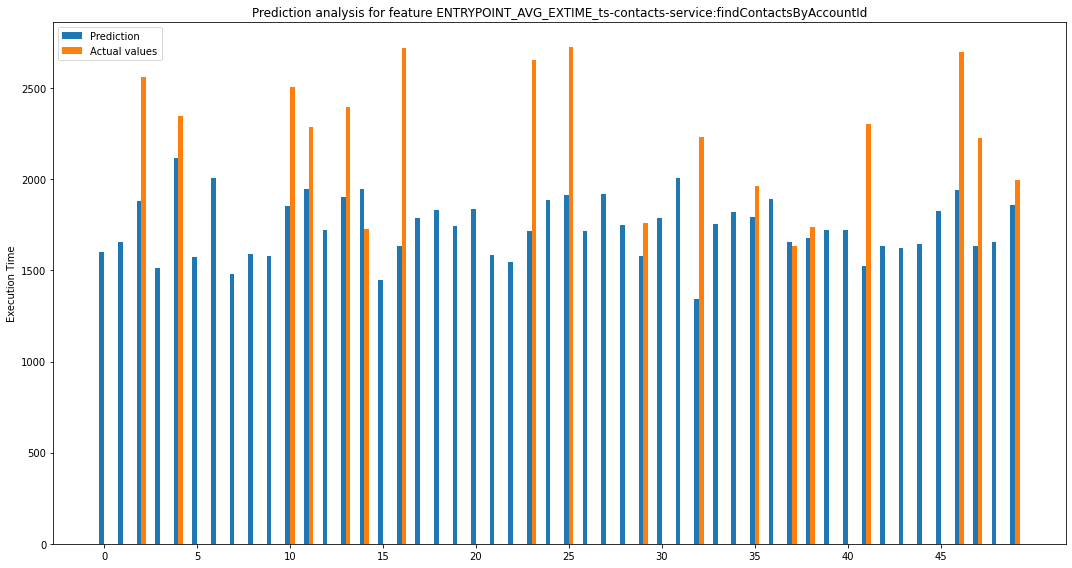

MAE:  1277.954111328125
MAPE:  74.53  %
MSE:  2023321.114288661
ENTRY ENTRYPOINT_AVG_EXTIME_ts-food-service:getAllFood
PRED [19652.281, 19390.31, 24531.205, 21239.205, 24714.906, 19742.549, 22813.553, 20269.172, 17063.932, 24392.188, 23351.77, 21112.703, 17066.506, 30223.055, 20646.057, 16395.402, 22403.166, 16928.04, 17263.781, 18918.299, 17798.615, 18375.734, 20988.65, 25604.521, 16580.713, 21058.256, 24341.637, 16361.167, 22040.215, 20645.451, 20461.305, 17763.562, 25867.826, 16648.96, 19653.16, 25044.346, 18926.508, 21067.55, 22167.193, 18368.24, 22903.785, 26203.795, 16801.59, 16495.71, 19516.395, 20184.371, 23185.822, 22623.371, 17448.242, 18906.973]
VALS [0.0, 0.0, 21439.0, 0.0, 16761.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17437.0, 15345.0, 0.0, 16645.5, 13866.0, 0.0, 22674.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21840.0, 0.0, 28137.0, 0.0, 0.0, 0.0, 20210.0, 0.0, 0.0, 17926.666666666668, 0.0, 0.0, 16972.5, 0.0, 15039.0, 16085.0, 0.0, 0.0, 29205.0, 0.0, 0.0, 0.0, 0.0, 23623.0, 17158.0, 0.0, 21118

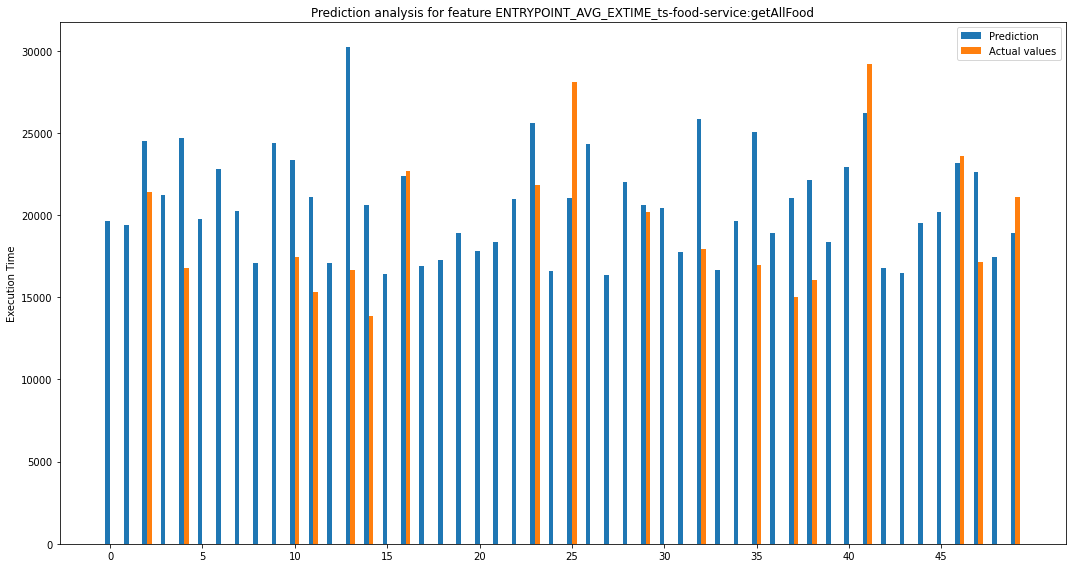

MAE:  14133.361100260416
MAPE:  71.9  %
MSE:  251707912.87392035
ENTRY ENTRYPOINT_AVG_EXTIME_ts-order-service:queryOrdersForRefresh
PRED [18636848.0, 14060039.0, 27890036.0, 17905380.0, 27773436.0, 21199544.0, 22395852.0, 15332025.0, 7945955.0, 20989910.0, 13767185.0, 11850721.0, 11786156.0, 26688824.0, 5906491.5, 14889361.0, 30138924.0, 5269339.0, 8145867.5, 4981933.0, 5049264.5, 11645188.0, 6693234.5, 47161744.0, 2122807.0, 1752835.8, 13409516.0, 11665405.0, 26980608.0, 20717470.0, 7558062.5, -9930231.0, 48147228.0, 4881595.5, 1875205.8, 33775856.0, 12803985.0, 8558269.0, 30080284.0, 15877023.0, 19210552.0, 50790068.0, 3358549.2, 686405.56, 13653234.0, 8602877.0, 14204779.0, 30345612.0, 7469649.0, 34980972.0]
VALS [0.0, 0.0, 0.0, 0.0, 4269723.5, 0.0, 0.0, 3269402.0, 4151308.0000000005, 3267119.0, 0.0, 0.0, 0.0, 6612926.5, 0.0, 0.0, 10330764.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2798409.0, 5582607.5, 0.0, 0.0, 0.0, 5299996.0, 0.0, 11956707.5, 0.0, 0.0, 8959568.5, 0.0, 0.0, 4390031.0, 0.0, 0.0, 

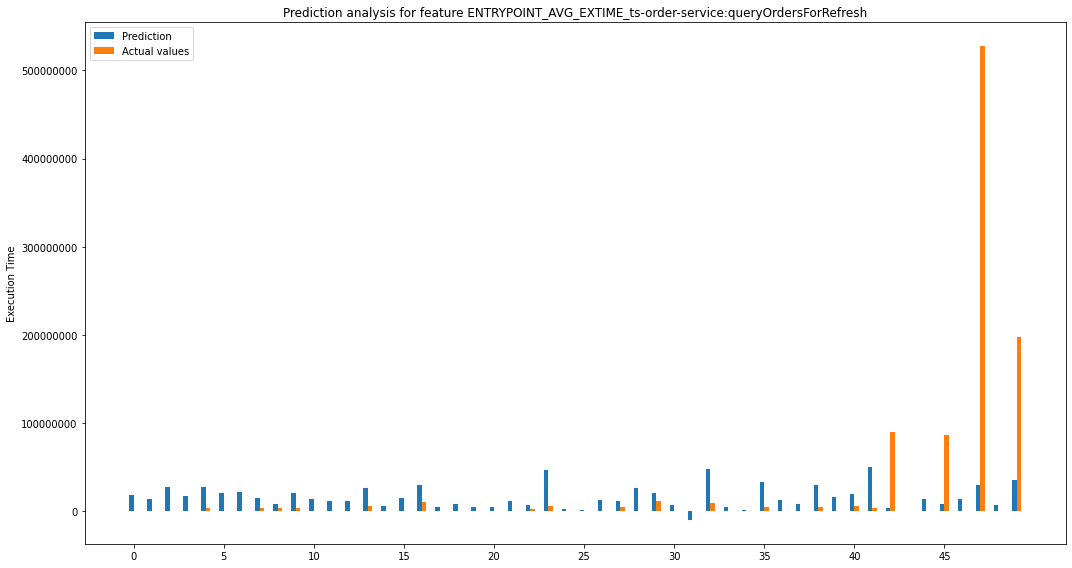

MAE:  29862902.50625
MAPE:  195.8  %
MSE:  6039479058031679.0
ENTRY ENTRYPOINT_AVG_EXTIME_ts-cancel-service:cancelTicket
PRED [925.34784, 2223.6313, 10859.105, 7616.582, 1785.7825, 1285.7339, 1650.1748, -79.13911, 1062.4093, 3668.6387, -10035.162, -2451.3333, 5086.254, 3643.3066, -1656.8102, 10360.864, 5704.5977, 8525.211, -1036.4442, 3448.4268, 7914.415, 3667.7507, 9391.168, -9537.947, 14412.592, -3283.9626, -2675.6375, 12710.379, -3115.1377, 3304.7576, 7123.5293, 11578.594, -16481.393, 9183.651, 3181.2302, 4786.2905, -8966.463, 4706.31, 1805.4031, 3278.443, 474.374, -2605.7708, 7563.935, 7836.1777, -1739.9698, 9388.712, -5391.5117, 3178.8848, 3971.4502, 2075.4238]
VALS [0.0, 0.0, 7613.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5798.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 219228.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6210.0, 0.0, 0.0, 0.0, 0.0]


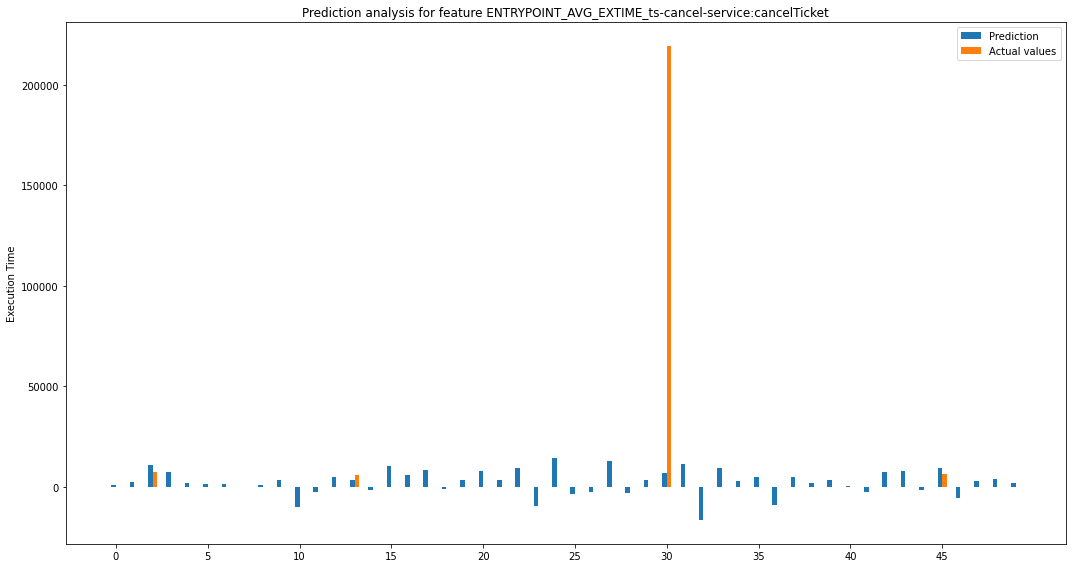

MAE:  9162.11093460083
MAPE:  154.01  %
MSE:  939021328.5458322
ENTRY ENTRYPOINT_AVG_EXTIME_ts-inside-payment-service:pay
PRED [19102.273, 25949.07, 38197.965, 44390.1, 61583.38, 28860.688, 48970.875, 29105.205, 25736.635, 50208.48, 18643.092, 43528.973, 29600.39, 63717.93, 43426.18, 30645.92, 33672.637, 29092.129, 37209.047, 38582.453, 40241.273, 33144.29, 29395.598, 52298.332, 32822.52, 17712.623, 49673.99, 40448.76, 58160.105, 23867.42, 34830.492, 35682.227, 43437.61, 31480.365, 43208.84, 56704.074, 29825.074, 45028.65, 33658.773, 30972.258, 45489.055, 20629.627, 37896.008, 34353.617, 29949.496, 40691.34, 72906.9, 29386.902, 33233.84, 43175.746]
VALS [0.0, 0.0, 143893.5, 0.0, 0.0, 0.0, 90188.0, 0.0, 129138.00000000001, 86489.0, 54824.5, 0.0, 137327.0, 90087.5, 0.0, 0.0, 0.0, 0.0, 0.0, 160057.5, 0.0, 0.0, 0.0, 0.0, 0.0, 89728.0, 0.0, 0.0, 0.0, 0.0, 123489.50000000001, 0.0, 0.0, 0.0, 143260.0, 0.0, 0.0, 0.0, 100375.0, 0.0, 133742.0, 0.0, 0.0, 0.0, 175575.0, 186204.0, 14129.0, 0.0, 0.0

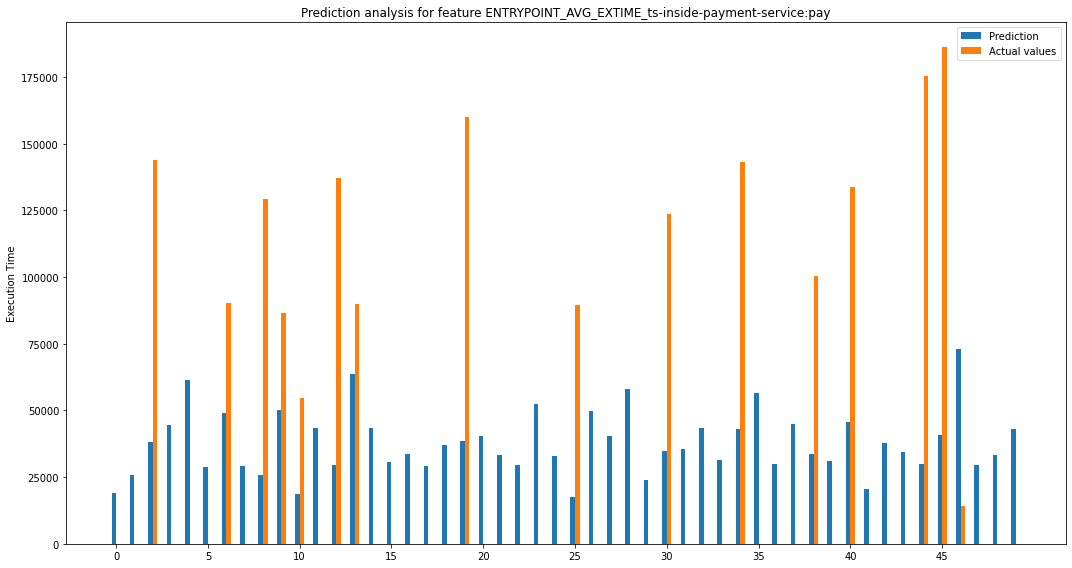

MAE:  52047.636875
MAPE:  147.17  %
MSE:  3690184335.584047
ENTRY ENTRYPOINT_AVG_EXTIME_ts-travel-service:queryInfo
PRED [-2701365.5, -9891998.0, -19218270.0, -6308546.5, -34286104.0, -4759299.5, -29089928.0, 10910072.0, 10365559.0, -7926549.5, -6333968.5, -11186789.0, -4099591.8, -19615804.0, -12260349.0, 4177045.8, -13247464.0, -5946964.5, -7114828.5, -6349364.0, -5529602.5, -8349714.5, -5207383.0, -32973848.0, -2464766.8, -7041611.5, -3796404.0, -13074238.0, -21419184.0, -4604965.0, -9703921.0, 1841289.8, -20942224.0, -3370204.8, -7849683.0, 1474533.6, -27388222.0, -13036385.0, -20640772.0, -12291840.0, -19172894.0, 2805891.2, 8008660.0, 1577297.5, -13524992.0, -2048299.6, -20064992.0, -10570360.0, -10434105.0, -18220976.0]
VALS [1843401.0, 17932.0, 7758706.0, 25779.0, 20058.0, 3942623.0, 0.0, 14296.0, 9425474.5, 0.0, 16962.0, 5681760.0, 0.0, 0.0, 20898.0, 0.0, 12734.0, 7152510.5, 0.0, 4211725.0, 3384378.0, 0.0, 0.0, 20520.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12719.0, 7444869.

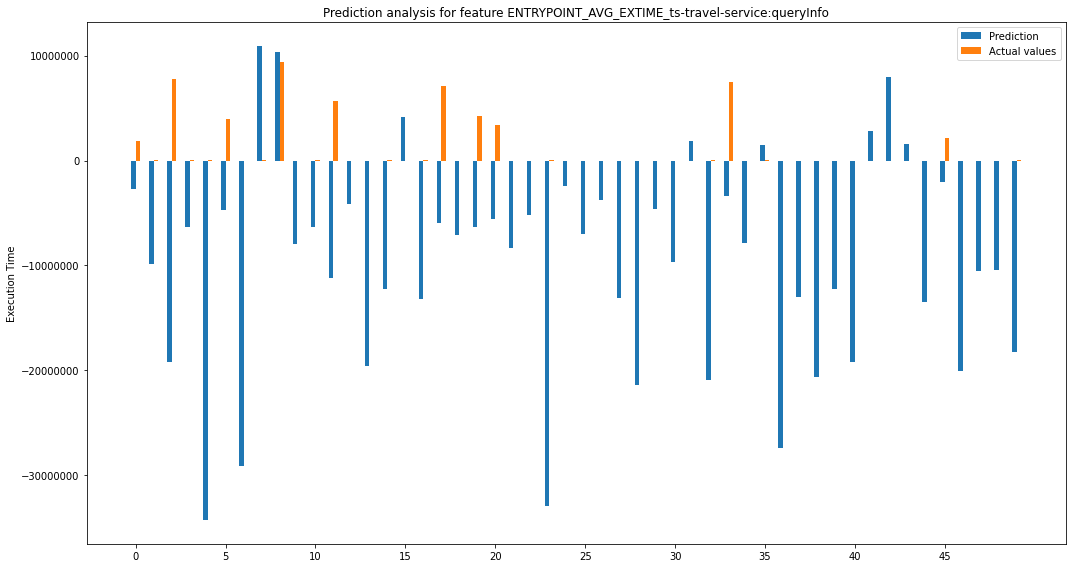

MAE:  11790514.435
MAPE:  114.52  %
MSE:  207437126452875.38
ENTRY ENTRYPOINT_AVG_EXTIME_ts-assurance-service:getAllAssuranceType
PRED [909.2047, 830.3571, 862.92725, 1141.7787, 736.0423, 801.795, 612.0457, 1460.4801, 1192.3843, 1002.09656, 1718.6133, 1153.484, 917.49646, 1138.8334, 1087.4425, 977.0789, 981.40845, 841.33276, 861.01953, 1013.0379, 1052.9302, 821.12164, 974.1735, 928.4901, 732.40155, 1147.6827, 1533.3873, 729.81793, 907.5073, 1012.4603, 1032.1226, 1189.4518, 1083.6749, 834.31934, 1057.3536, 1306.2784, 902.4158, 819.89355, 890.9374, 979.4281, 752.1641, 796.19403, 1068.5356, 988.25476, 994.0882, 1107.8264, 1034.1722, 819.2581, 854.76904, 537.0436]
VALS [0.0, 0.0, 1168.0, 0.0, 1460.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1244.5, 1445.0, 0.0, 1195.0, 1424.0, 0.0, 1907.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1468.5, 0.0, 1760.0, 0.0, 0.0, 0.0, 1719.0, 0.0, 0.0, 1369.3333333333333, 0.0, 0.0, 1485.0, 0.0, 1518.0, 1543.0, 0.0, 0.0, 1673.5, 0.0, 0.0, 0.0, 0.0, 1383.0, 1535.5, 0.0, 1483.0]


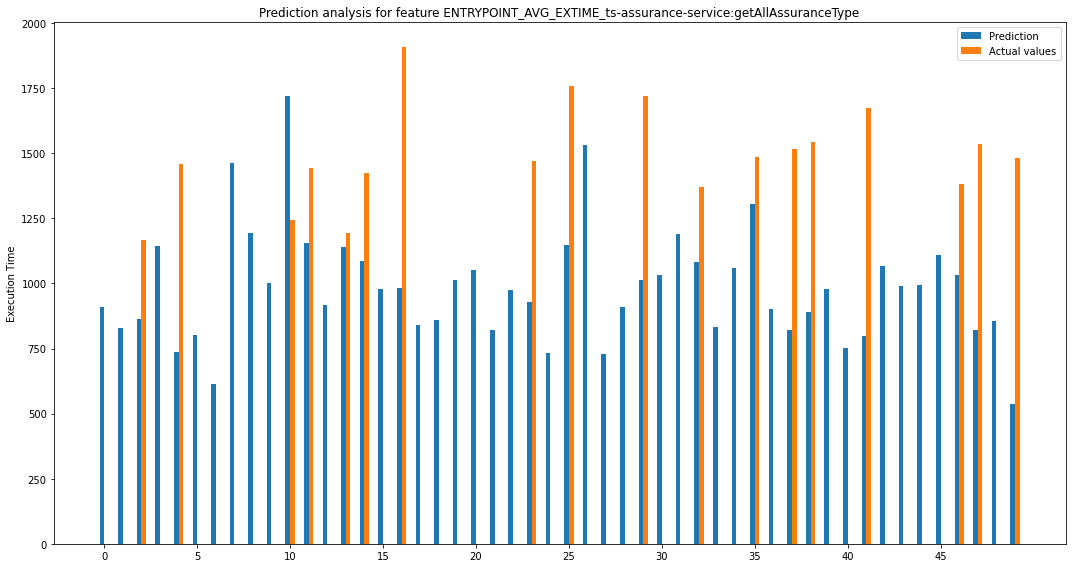

MAE:  814.9379972330728
MAPE:  86.08  %
MSE:  754663.425672339
ENTRY ENTRYPOINT_AVG_EXTIME_ts-auth-service:getToken
PRED [106517.25, 106173.914, 105717.234, 104548.375, 100400.445, 105712.96, 101902.14, 109257.46, 110944.08, 106088.84, 103848.88, 105365.03, 107718.53, 104087.34, 103058.07, 107826.53, 109063.06, 105310.586, 104207.01, 105128.39, 104835.77, 105063.27, 102512.4, 103507.37, 106773.21, 105337.78, 101923.03, 106849.375, 101420.77, 109216.72, 102616.17, 102253.98, 106148.9, 105462.29, 105066.68, 109753.85, 101280.51, 102746.25, 103966.99, 104166.414, 104051.664, 110843.88, 106127.39, 106572.13, 102435.98, 103446.93, 101174.04, 108895.56, 103672.39, 106801.75]
VALS [0.0, 0.0, 0.0, 115681.0, 0.0, 0.0, 0.0, 116975.0, 0.0, 0.0, 117736.0, 115765.0, 0.0, 115733.0, 117305.0, 0.0, 125752.0, 0.0, 0.0, 0.0, 118840.5, 0.0, 0.0, 0.0, 0.0, 0.0, 114422.0, 121345.0, 0.0, 0.0, 0.0, 115303.5, 0.0, 0.0, 0.0, 115853.66666666669, 0.0, 0.0, 0.0, 114098.0, 0.0, 116198.0, 0.0, 0.0, 0.0, 117688.0, 1

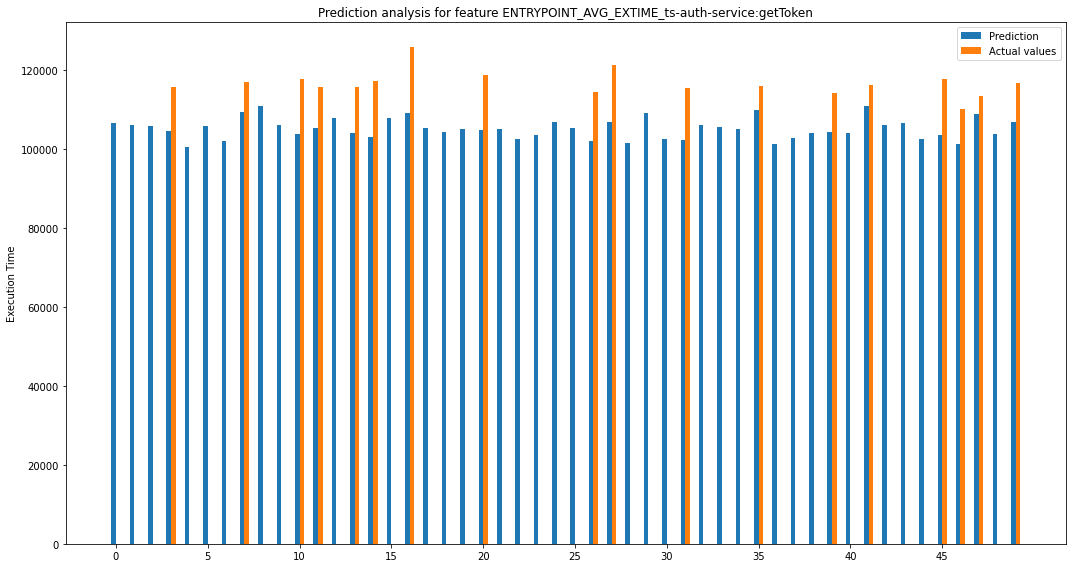

MAE:  71125.19270833334
MAPE:  67.78  %
MSE:  7097423300.447397
ENTRY ENTRYPOINT_AVG_EXTIME_ts-order-service:POST
PRED [308780.62, -1095.891, -55499.203, 263690.25, -263195.06, -2856.459, -381908.4, 286746.06, 111618.84, -39399.31, 529286.06, 203790.95, -19829.443, -551932.25, -125635.164, 543025.7, -163921.52, -140045.38, -180651.98, 36447.438, -94487.555, -67182.49, -64958.19, 501568.94, -499212.47, -460412.8, 243425.86, -375464.2, 251574.67, -73427.9, -12608.609, -235056.89, 936017.75, -82505.77, -106468.266, 88145.13, -200542.72, -237938.94, 255711.98, 267396.34, -446561.72, 267338.25, 203010.08, -70479.76, 157816.83, 115334.53, -89671.71, -529597.06, -29486.184, -258430.92]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


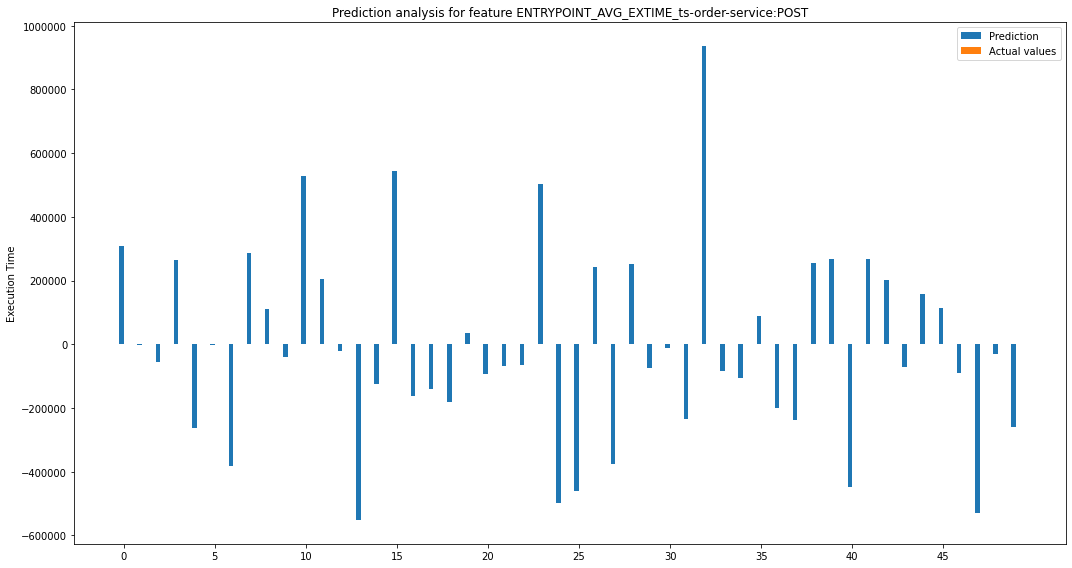

MAE:  228623.8101635742
MAPE:  100.0  %
MSE:  87981765603.33417
MAE:  652.2279091632728
MAPE:  1.01
MSE:  578039.4360720997
MAE:  1747.1060305200442
MAPE:  1.0
MSE:  3587932.7555230926
MAE:  8556950.691795034
MAPE:  3.21
MSE:  1356119442985559.2
MAE:  7076335.911258418
MAPE:  4.07
MSE:  1443410012701643.2
MAE:  1277.2979593296243
MAPE:  0.76
MSE:  1864636.0301917964
MAE:  13090.893323534827
MAPE:  0.72
MSE:  212357236.13271376
MAE:  15032301.3864899
MAPE:  1.2
MSE:  1644172236582262.5
MAE:  4118.592380546801
MAPE:  1.05
MSE:  117845813.59487954
MAE:  39762.6539318971
MAPE:  1.1
MSE:  3455038983.8140144
MAE:  9758177.672306398
MAPE:  1.96
MSE:  1238644797122002.8
MAE:  958.5759826762909
MAPE:  1.16
MSE:  1035083.1505323646
MAE:  61691.7740898569
MAPE:  0.59
MSE:  6253027376.813486
MAE:  221793.99472237017
MAPE:  1.04
MSE:  673208614598.6274
Loading datasource from avv_dataset_DT_5000.csv
Datasource loaded: len = 480
Entrypoints size: 13
Entrypoint list
[   'ENTRYPOINT_N_INVOC_API_ts-con

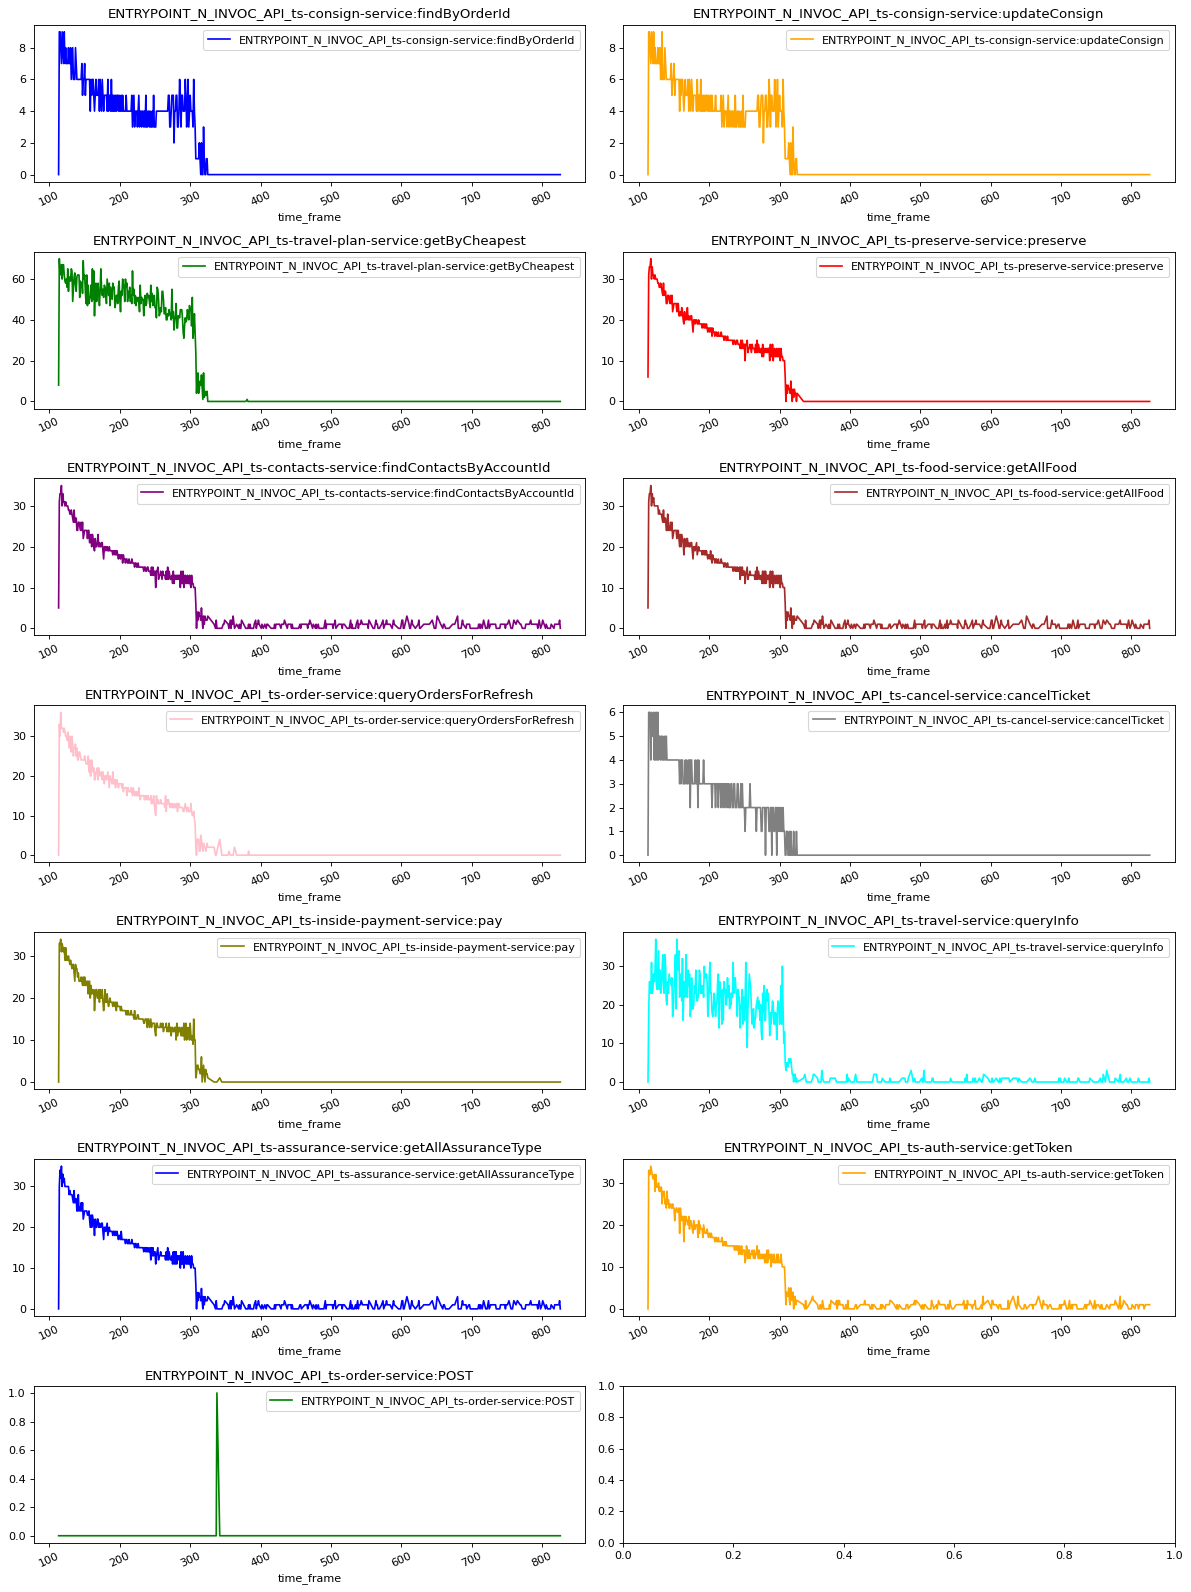

Data normalized
Input size 45 Output size 13
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                2944      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 13)                429       
                                                                 
Total params: 5,453
Trainable params: 5,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 0s 19ms/step - loss: 302.2784 - val_loss: 0.3175
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 106.1780 - val_loss: 0.8565
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 2

Epoch 76/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0415 - val_loss: 0.0263
Epoch 77/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0615 - val_loss: 0.0263
Epoch 78/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0597 - val_loss: 0.0257
Epoch 79/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0780 - val_loss: 0.0254
Epoch 80/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0410 - val_loss: 0.0276
Epoch 81/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0254 - val_loss: 0.0259
Epoch 82/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0538 - val_loss: 0.0268
Epoch 83/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0686 - val_loss: 0.0252
Epoch 84/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0471 - val_loss: 0.0254
Epoch 85/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0269 - val_loss: 0.0310
Epoch 86/100
8/8 [==

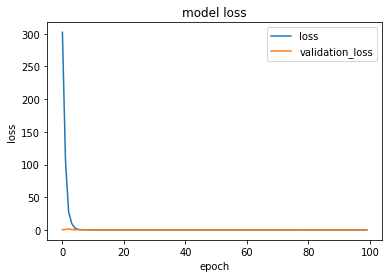

5/5 [==============================] - 0s 1ms/step
TOTAL MSE:  0.023747364009933988
TOTAL MAE:  0.10128004948019226
TOTAL MAPE:  0.94
FIRST 50 predictions
ENTRY ENTRYPOINT_AVG_EXTIME_ts-consign-service:findByOrderId
PRED [357.2755, 493.51038, 335.84854, 469.4983, 357.2755, 390.16464, 436.6085, 343.71945, 449.59302, 436.6085, 476.17545, 390.16464, 390.16464, 357.2755, 462.6198, 392.7506, 310.83032, 476.17545, 414.11835, 390.16464, 422.8302, 346.30542, 392.7506, 357.2755, 390.16464, 469.4983, 387.90594, 390.16464, 370.25894, 469.4983, 436.60873, 436.60873, 427.6744, 357.2755, 436.6085, 321.22864, 415.95172, 376.9361, 357.2755, 469.4983, 407.23965, 346.30542, 357.2755, 447.0077, 436.6085, 357.2755, 348.3399, 425.63907, 469.4983, 427.6744]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

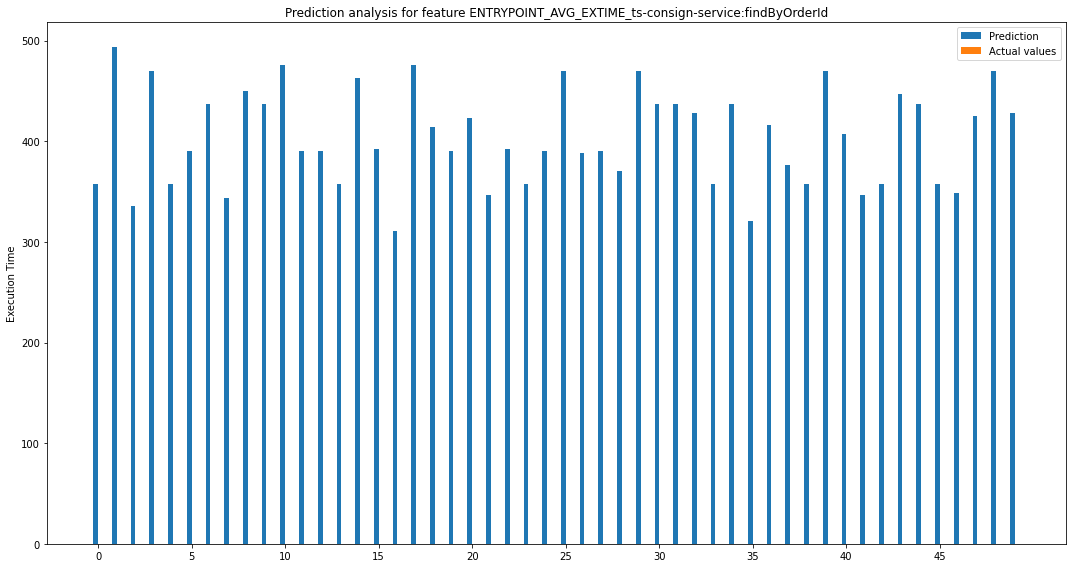

MAE:  403.71448669433596
MAPE:  100.0  %
MSE:  165193.05109510268
ENTRY ENTRYPOINT_AVG_EXTIME_ts-consign-service:updateConsign
PRED [1120.4407, 880.5537, 1231.7328, 1033.6626, 1120.4407, 1110.8872, 1043.2158, 1178.5549, 1055.579, 1043.2158, 989.711, 1110.8872, 1110.8872, 1120.4407, 1047.8257, 1069.0696, 1188.1096, 989.711, 1106.9493, 1110.8872, 1052.3159, 1136.7389, 1069.0696, 1120.4407, 1110.8872, 1033.6626, 1072.5516, 1110.8872, 1132.8024, 1033.6626, 1043.2162, 1043.2162, 1048.834, 1120.4407, 1043.2158, 1242.2886, 1066.4802, 1088.8503, 1120.4407, 1033.6626, 1121.1125, 1136.7389, 1120.4407, 1097.395, 1043.2158, 1120.4407, 1126.0575, 1059.516, 1033.6626, 1048.834]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


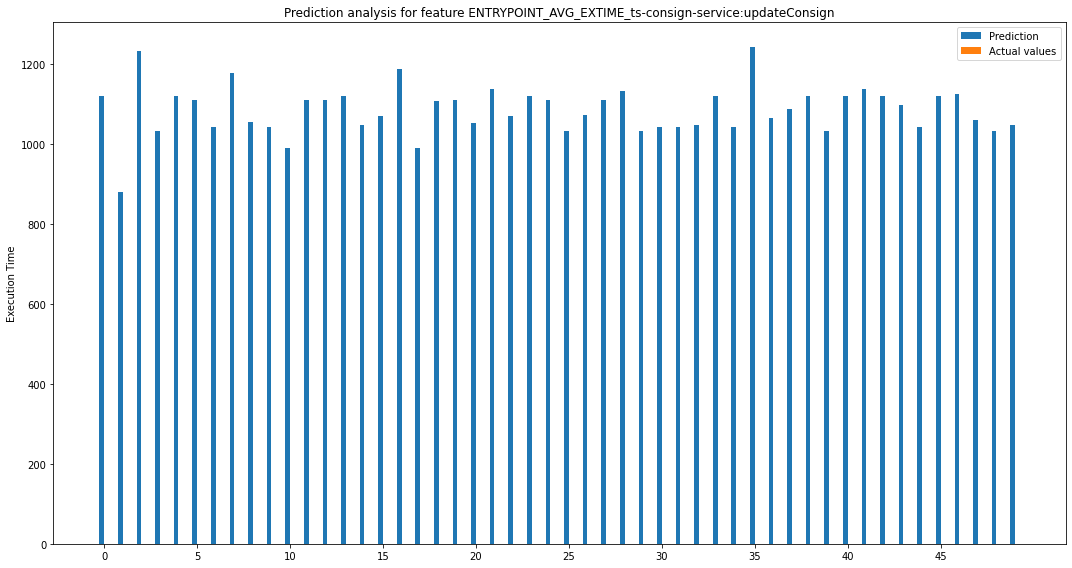

MAE:  1085.876787109375
MAPE:  100.0  %
MSE:  1182771.6387609767
ENTRY ENTRYPOINT_AVG_EXTIME_ts-travel-plan-service:getByCheapest
PRED [12357154.0, 11702499.0, 8709810.0, 3064279.0, 12357154.0, 7098251.5, 8323215.0, 5873361.5, 1357136.6, 8323215.0, 8246096.0, 7098251.5, 7098251.5, 12357154.0, 1762310.2, 12089109.0, 11132279.0, 8246096.0, 1625221.9, 7098251.5, 8085836.0, 10864205.0, 12089109.0, 12357154.0, 7098251.5, 3064279.0, 12065956.0, 7098251.5, 5391134.5, 3064279.0, 8323207.5, 8323207.5, 8109004.0, 12357154.0, 8323215.0, -824613.25, 6783863.5, 10572970.0, 12357154.0, 3064279.0, 323223.84, 10864205.0, 12357154.0, -3633717.5, 8323215.0, 12357154.0, 12143009.0, 6830228.5, 3064279.0, 8109004.0]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


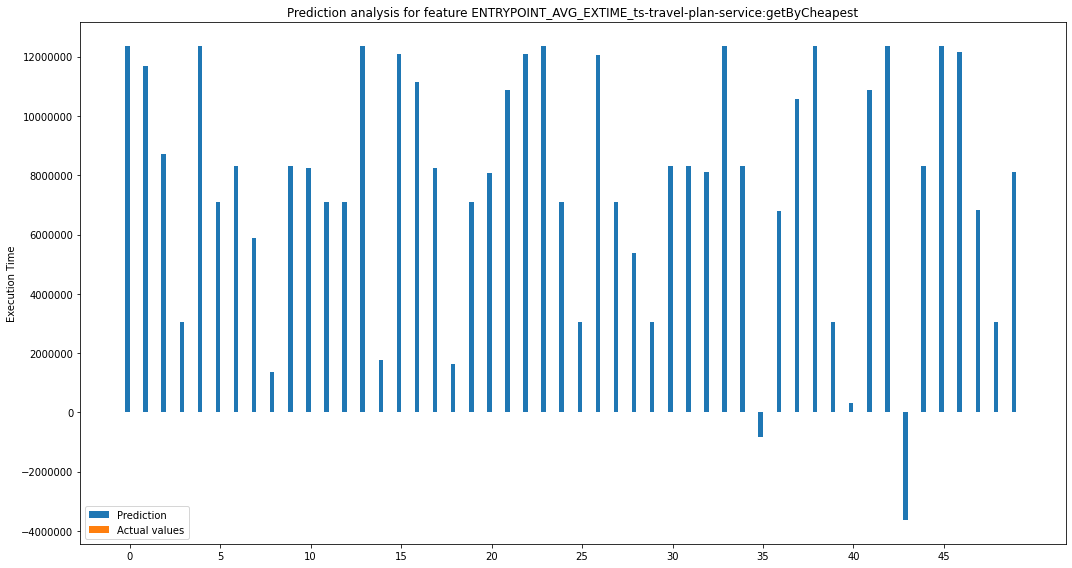

MAE:  7882828.186875
MAPE:  100.0  %
MSE:  75342570485246.14
ENTRY ENTRYPOINT_AVG_EXTIME_ts-preserve-service:preserve
PRED [17838150.0, 20559764.0, 22708054.0, 26934448.0, 17838150.0, 21026858.0, 23745732.0, 18307980.0, 25760816.0, 23745732.0, 25461418.0, 21026858.0, 21026858.0, 17838150.0, 25931198.0, 19522090.0, 15119271.0, 25461418.0, 24076854.0, 21026858.0, 23500140.0, 16803212.0, 19522090.0, 17838150.0, 21026858.0, 26934448.0, 19415160.0, 21026858.0, 19853264.0, 26934448.0, 23745740.0, 23745740.0, 23607070.0, 17838150.0, 23745732.0, 18639130.0, 22496962.0, 18380234.0, 17838150.0, 26934448.0, 23073690.0, 16803212.0, 17838150.0, 27265570.0, 23745732.0, 17838150.0, 17699476.0, 22710802.0, 26934448.0, 23607070.0]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


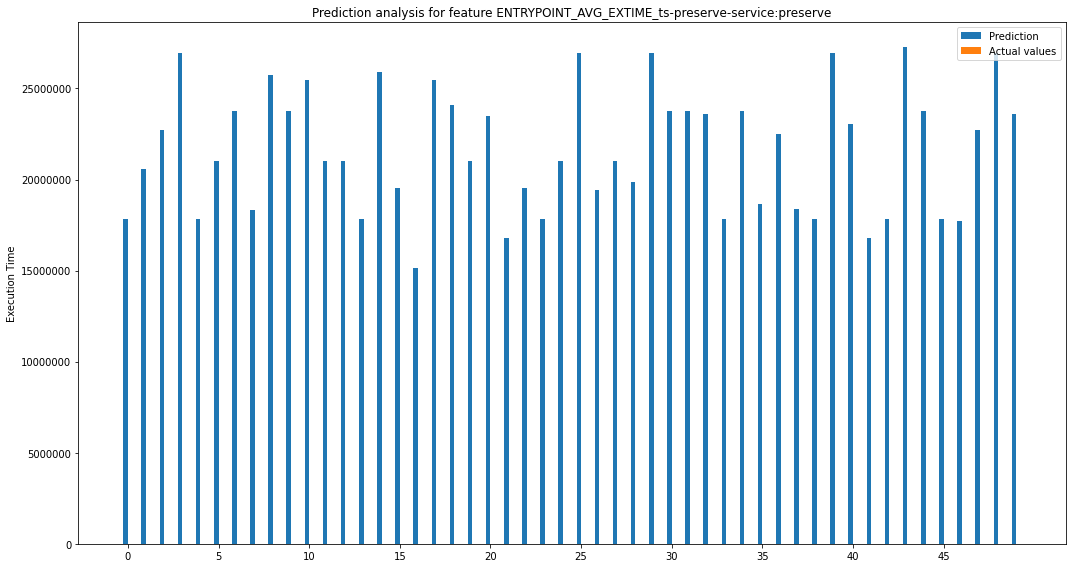

MAE:  21645978.82
MAPE:  100.0  %
MSE:  479687618562558.8
ENTRY ENTRYPOINT_AVG_EXTIME_ts-contacts-service:findContactsByAccountId
PRED [1583.6017, 1639.8142, 1630.3281, 1781.2211, 1583.6017, 1648.8878, 1715.9357, 1581.841, 1666.8384, 1715.9357, 1697.11, 1648.8878, 1648.8878, 1583.6017, 1695.3492, 1554.2069, 1516.555, 1697.11, 1696.2339, 1648.8878, 1690.6244, 1487.1593, 1554.2069, 1583.6017, 1648.8878, 1781.2211, 1546.8372, 1648.8878, 1534.5054, 1781.2211, 1715.9358, 1715.9358, 1697.9949, 1583.6017, 1715.9357, 1562.1401, 1604.752, 1450.3937, 1583.6017, 1781.2211, 1610.3616, 1487.1593, 1583.6017, 1761.5201, 1715.9357, 1583.6017, 1565.6611, 1619.4923, 1781.2211, 1697.9949]
VALS [0.0, 0.0, 2283.0, 2721.0, 0.0, 2651.0, 2567.0, 2612.0, 2663.5, 2577.0, 2379.0, 2568.0, 2604.0, 0.0, 2708.0, 0.0, 0.0, 2569.0, 2457.5, 2418.0, 2218.0, 0.0, 0.0, 0.0, 2320.0, 2671.5, 0.0, 2568.0, 2904.0, 2489.0, 2790.0, 2589.0, 2579.0, 0.0, 2526.0, 2641.5, 2608.0, 0.0, 0.0, 2565.5, 2585.0, 0.0, 0.0, 2623.33333333333

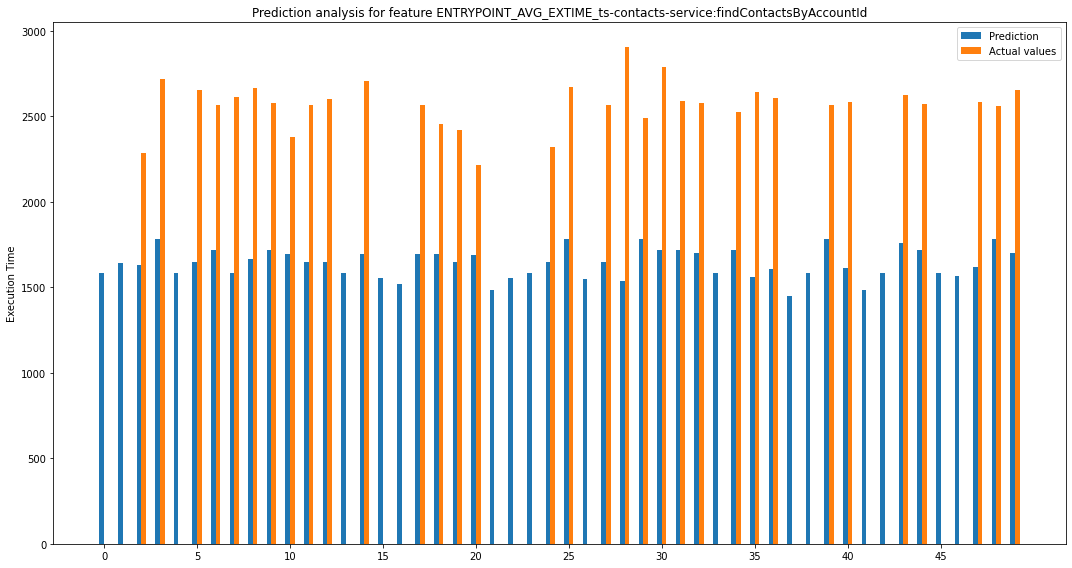

MAE:  1115.1179557291666
MAPE:  68.97  %
MSE:  1360307.3342803316
ENTRY ENTRYPOINT_AVG_EXTIME_ts-food-service:getAllFood
PRED [13436.162, 13121.159, 13886.443, 14362.756, 13436.162, 14115.2, 13683.711, 14546.686, 14801.925, 13683.711, 13558.943, 14115.2, 14115.2, 13436.162, 14669.467, 13323.892, 13867.642, 13558.943, 14914.1875, 14115.2, 13911.092, 13755.382, 13323.892, 13436.162, 14115.2, 14362.756, 13431.323, 14115.2, 14554.366, 14362.756, 13683.714, 13683.714, 13803.664, 13436.162, 13683.711, 15777.159, 14217.809, 13750.55, 13436.162, 14362.756, 15220.898, 13755.382, 13436.162, 15593.232, 13683.711, 13436.162, 13556.099, 14002.938, 14362.756, 13803.664]
VALS [0.0, 25787.0, 0.0, 28330.0, 0.0, 26314.0, 26380.999999999996, 25899.0, 22849.5, 25984.000000000004, 21380.0, 26392.0, 24985.999999999996, 0.0, 24482.5, 0.0, 0.0, 27150.0, 21504.5, 21316.0, 23692.0, 0.0, 0.0, 0.0, 29578.0, 30913.0, 0.0, 27989.999999999996, 23083.0, 20934.0, 26056.0, 32627.999999999996, 25415.0, 0.0, 23410.0, 228

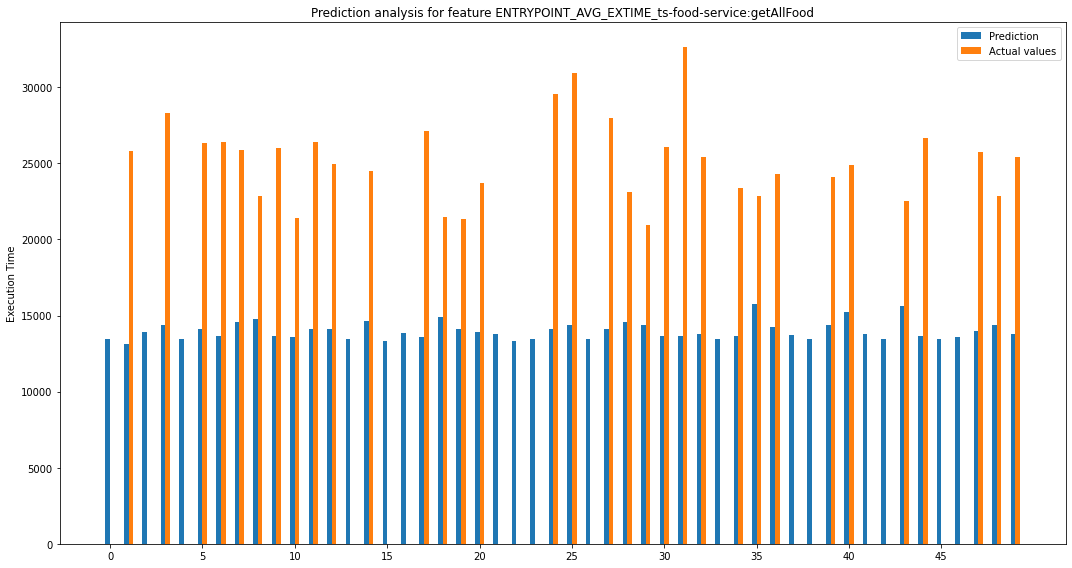

MAE:  11865.576959635415
MAPE:  85.49  %
MSE:  147860327.45176485
ENTRY ENTRYPOINT_AVG_EXTIME_ts-order-service:queryOrdersForRefresh
PRED [35301230.0, 29938590.0, 43300520.0, 42318856.0, 35301230.0, 36961950.0, 40658144.0, 33265784.0, 34065584.0, 40658144.0, 37900956.0, 36961950.0, 36961950.0, 35301230.0, 35865490.0, 32581006.0, 31605072.0, 37900956.0, 36785904.0, 36961950.0, 36947652.0, 28884776.0, 32581006.0, 35301230.0, 36961950.0, 42318856.0, 30707340.0, 36961950.0, 28708752.0, 42318856.0, 40658196.0, 40658196.0, 38821370.0, 35301230.0, 40658144.0, 29393546.0, 30494294.0, 24290814.0, 35301230.0, 42318856.0, 30332496.0, 28884776.0, 35301230.0, 38446590.0, 40658144.0, 35301230.0, 33464470.0, 34241640.0, 42318856.0, 38821370.0]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


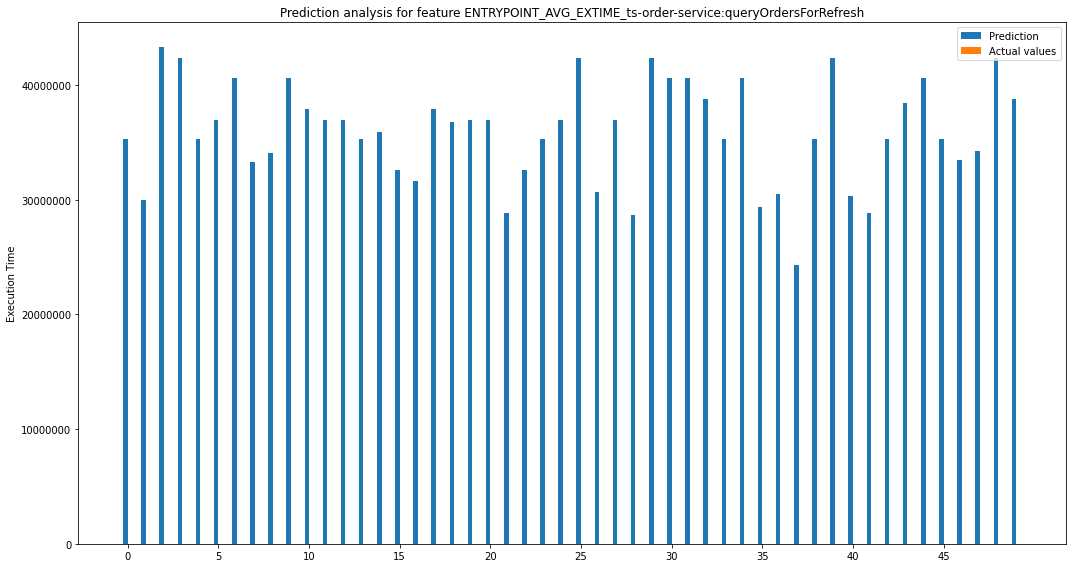

MAE:  35959111.32
MAPE:  100.0  %
MSE:  1312036781698842.2
ENTRY ENTRYPOINT_AVG_EXTIME_ts-cancel-service:cancelTicket
PRED [3481.482, 3923.8196, 515.95074, 1213.7747, 3481.482, 3503.2908, 1191.9658, 5814.6353, 4281.2744, 1191.9658, 820.4251, 3503.2908, 3503.2908, 3481.482, 3153.5393, 3247.811, 5792.8525, 820.4251, 4514.945, 3503.2908, 3033.7866, 5559.1426, 3247.811, 3481.482, 3503.2908, 1213.7747, 4099.8193, 3503.2908, 6570.797, 1213.7747, 1191.9789, 1191.9789, 2181.8179, 3481.482, 1191.9658, 9137.614, 4973.584, 6177.48, 3481.482, 1213.7747, 6454.729, 5559.1426, 3481.482, 4536.7275, 1191.9658, 3481.482, 4471.3403, 3269.6199, 1213.7747, 2181.8179]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


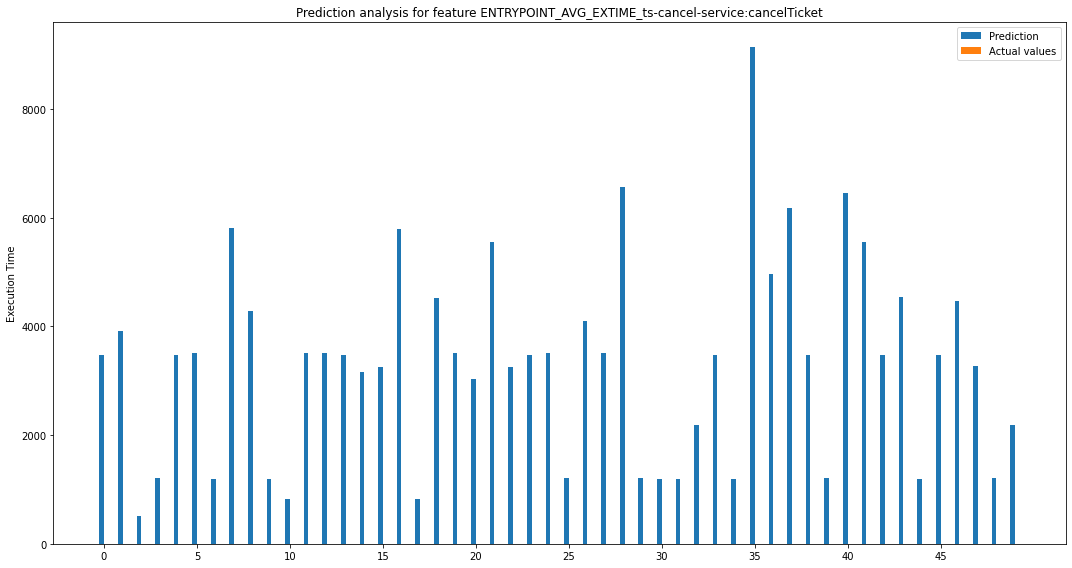

MAE:  3328.6640417480467
MAPE:  100.0  %
MSE:  14409307.00286314
ENTRY ENTRYPOINT_AVG_EXTIME_ts-inside-payment-service:pay
PRED [52913.457, 47107.754, 68279.49, 58139.53, 52913.457, 49674.445, 61378.543, 37970.492, 44316.434, 61378.543, 62882.812, 49674.445, 49674.445, 52913.457, 47939.82, 54008.645, 41209.508, 62882.812, 43221.3, 49674.445, 55359.48, 42304.605, 54008.645, 52913.457, 49674.445, 58139.53, 51203.773, 49674.445, 35851.55, 58139.53, 61378.6, 61378.6, 58164.414, 52913.457, 61378.543, 19813.428, 45159.71, 40594.832, 52913.457, 58139.53, 33021.68, 42304.605, 52913.457, 39982.23, 61378.543, 52913.457, 49699.387, 50769.633, 58139.53, 58164.414]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


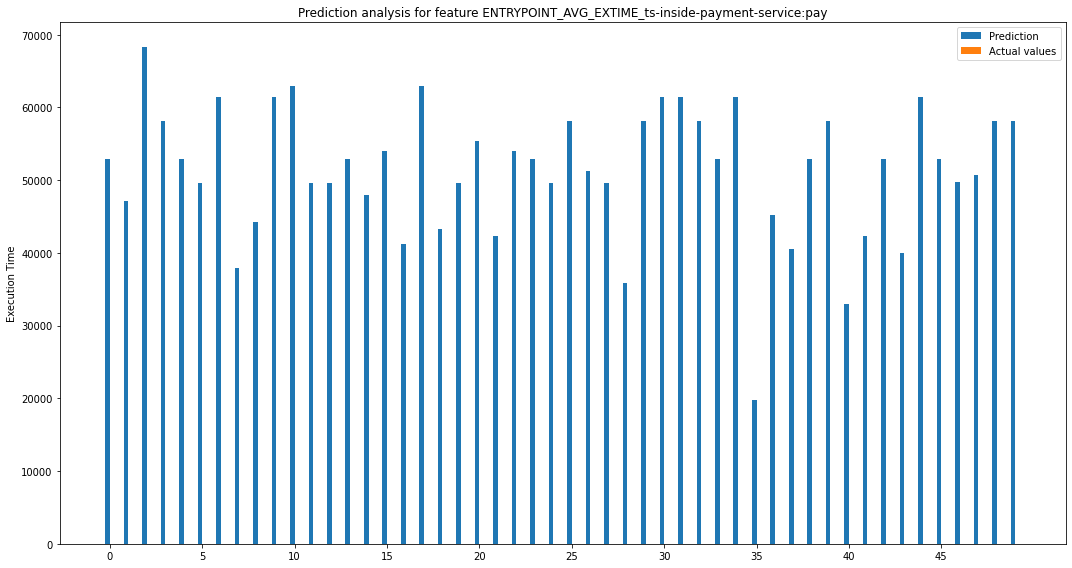

MAE:  51330.8963671875
MAPE:  100.0  %
MSE:  2714733844.447116
ENTRY ENTRYPOINT_AVG_EXTIME_ts-travel-service:queryInfo
PRED [9916140.0, 16044588.0, 17638092.0, 30804158.0, 9916140.0, 18288354.0, 22431868.0, 14144840.0, 26391492.0, 22431868.0, 23936968.0, 18288354.0, 18288354.0, 9916140.0, 28165712.0, 11250784.0, 5772584.5, 23936968.0, 25056786.0, 18288354.0, 19394712.0, 7107256.5, 11250784.0, 9916140.0, 18288354.0, 30804158.0, 9817403.0, 18288354.0, 13875716.0, 30804158.0, 22431882.0, 22431882.0, 20828106.0, 9916140.0, 22431868.0, 16769787.0, 16756265.0, 7008540.5, 9916140.0, 30804158.0, 22418366.0, 7107256.5, 9916140.0, 33429034.0, 22431868.0, 9916140.0, 8312302.0, 19623068.0, 30804158.0, 20828106.0]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29381.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29332.0, 0.0, 22164.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29973.999999999996, 0.0, 25834.0, 0.0, 0.0, 0.0, 30075.000000000004, 0.0, 0.0, 28826.0, 22362.0, 28233.0, 0.0, 0.0, 30182.0, 0.0, 0.0, 28538.

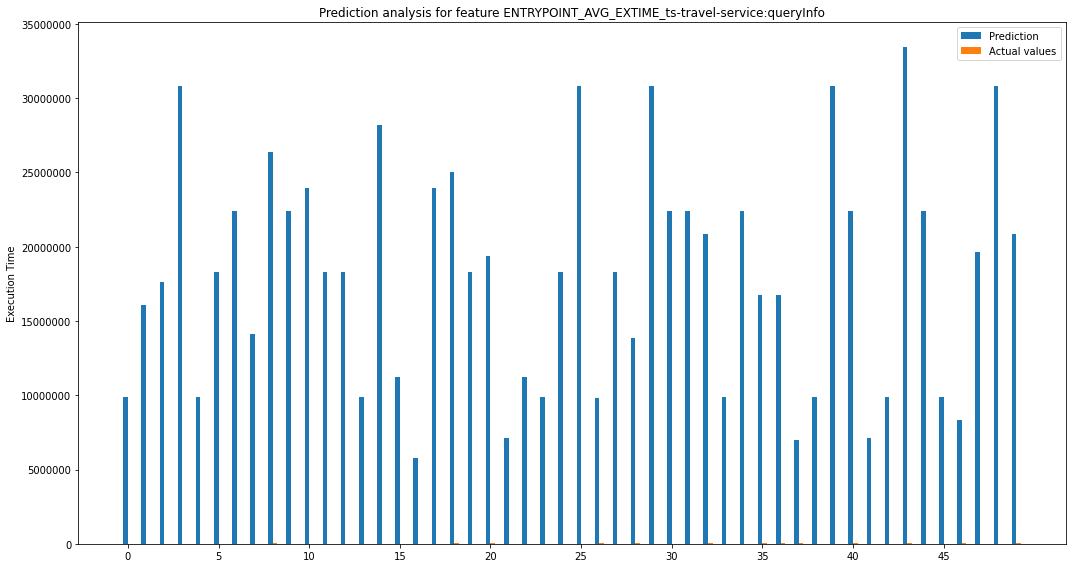

MAE:  18083415.18
MAPE:  99.95  %
MSE:  383624808211343.4
ENTRY ENTRYPOINT_AVG_EXTIME_ts-assurance-service:getAllAssuranceType
PRED [961.213, 869.33875, 984.5998, 987.80426, 961.213, 990.17664, 958.8416, 1021.5122, 953.3805, 958.8416, 882.6879, 990.17664, 990.17664, 961.213, 942.98615, 895.0965, 992.54956, 882.6879, 1019.4985, 990.17664, 949.5189, 926.432, 895.0965, 961.213, 990.17664, 987.80426, 885.41705, 990.17664, 955.75287, 987.80426, 958.8421, 958.8421, 959.1993, 961.213, 958.8416, 1082.1681, 904.6998, 850.6351, 961.213, 987.80426, 974.6784, 926.432, 961.213, 1048.4612, 958.8416, 961.213, 961.57025, 924.05963, 987.80426, 959.1993]
VALS [0.0, 1747.0, 0.0, 1810.0, 0.0, 1815.0, 1735.0, 1782.0, 1754.0, 2008.9999999999998, 2242.0, 1778.0, 1821.0, 0.0, 1700.5, 0.0, 0.0, 1723.0, 2049.0, 1707.0, 1738.0, 0.0, 0.0, 0.0, 1764.0, 1863.0, 0.0, 1761.0, 1937.0, 1812.0, 1946.0, 1731.0, 1774.0, 0.0, 1302.0, 1744.0, 1799.0, 0.0, 0.0, 1913.5, 1875.0, 0.0, 0.0, 1846.0, 1723.0, 0.0, 0.0, 2017.0, 1838

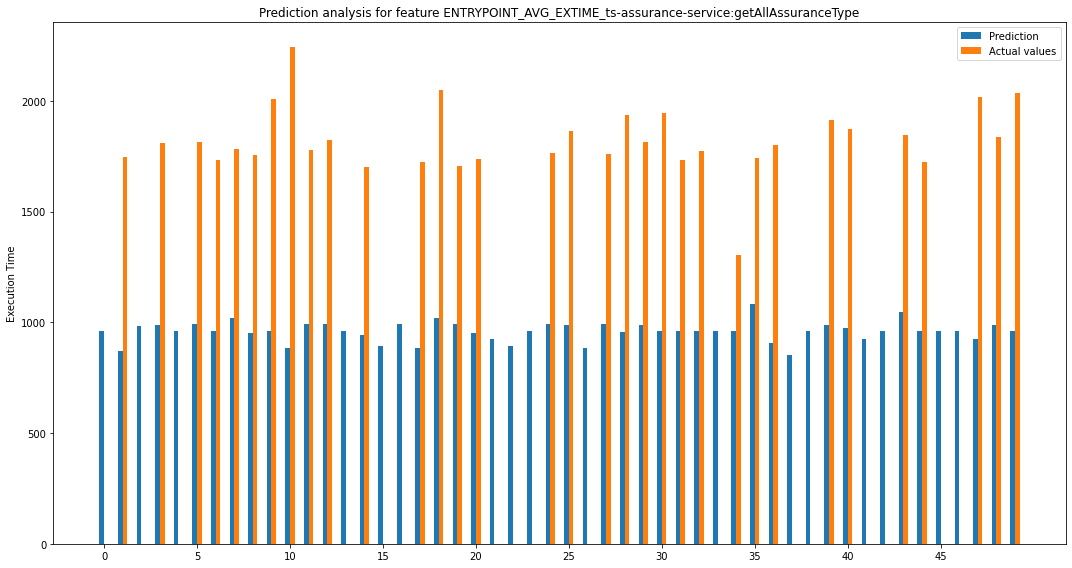

MAE:  882.7314331054688
MAPE:  92.38  %
MSE:  798759.5780895099
ENTRY ENTRYPOINT_AVG_EXTIME_ts-auth-service:getToken
PRED [72272.11, 69558.54, 73211.87, 70653.14, 72272.11, 71890.375, 71034.85, 72745.89, 71399.695, 71034.85, 70549.055, 71890.375, 71890.375, 72272.11, 71022.836, 71735.555, 73127.625, 70549.055, 71936.234, 71890.375, 71940.81, 72591.07, 71735.555, 72272.11, 71890.375, 70653.14, 72213.91, 71890.375, 72636.95, 70653.14, 71034.85, 71034.85, 71462.46, 72272.11, 71034.85, 73647.26, 72310.55, 72532.89, 72272.11, 70653.14, 72305.95, 72591.07, 72272.11, 71554.49, 71034.85, 72272.11, 72699.7, 71353.82, 70653.14, 71462.46]
VALS [107908.0, 109571.0, 0.0, 0.0, 103019.0, 109706.0, 0.0, 105450.0, 109130.0, 0.0, 0.0, 105662.0, 106429.0, 105647.0, 110394.0, 105003.0, 108106.0, 0.0, 110143.0, 101001.0, 0.0, 103485.0, 107264.0, 108314.0, 104256.0, 0.0, 109350.0, 106554.0, 106148.0, 0.0, 0.0, 0.0, 0.0, 104995.0, 0.0, 105636.66666666669, 104126.0, 107604.5, 105005.0, 0.0, 106528.5, 102488.0

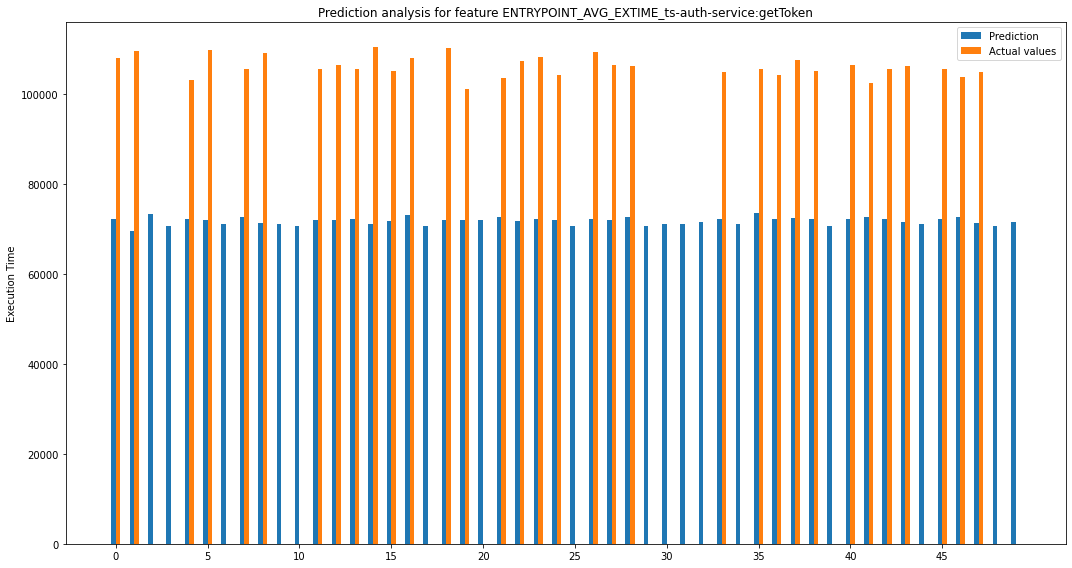

MAE:  46684.36942708334
MAPE:  65.24  %
MSE:  2491034816.8325276
ENTRY ENTRYPOINT_AVG_EXTIME_ts-order-service:POST
PRED [-628.43164, 152349.64, 6003.4146, 182688.39, -628.43164, 115735.9, 66324.86, 165142.94, 328752.66, 66324.86, 163197.67, 115735.9, 115735.9, -628.43164, 328969.06, 92025.53, 48781.008, 163197.67, 236096.81, 115735.9, 78542.234, 141435.77, 92025.53, -628.43164, 115735.9, 182688.39, 100243.11, 115735.9, 261797.48, 182688.39, 66324.86, 66324.86, 70324.65, -628.43164, 66324.86, 334916.5, 224823.16, 242306.78, -628.43164, 182688.39, 382378.28, 141435.77, -628.43164, 352460.62, 66324.86, -628.43164, 3371.3572, 208391.19, 182688.39, 70324.65]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


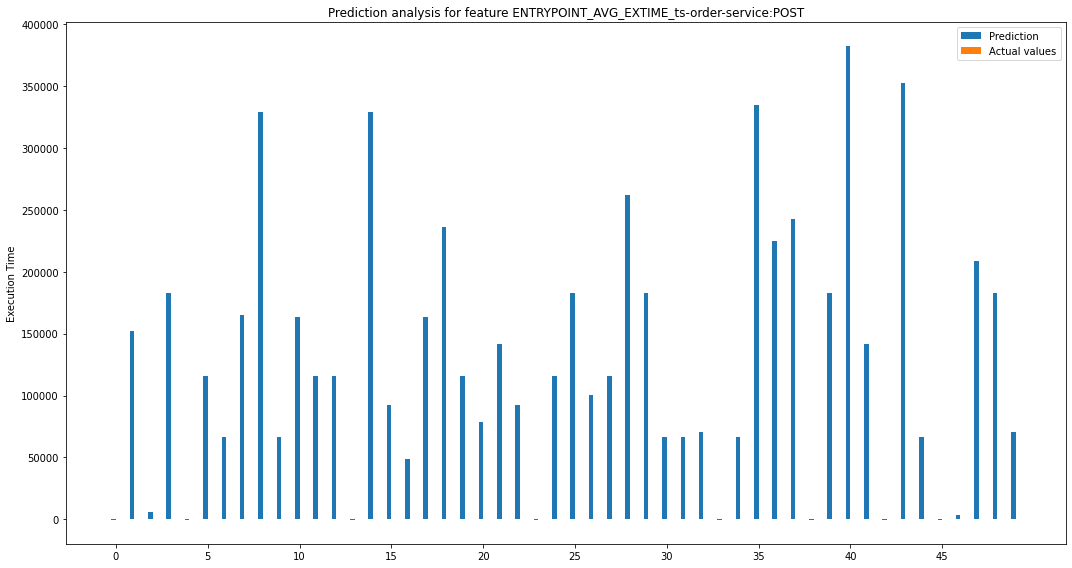

MAE:  128002.54871582032
MAPE:  100.0  %
MSE:  26774921830.748
MAE:  405.3601417781422
MAPE:  1.0
MSE:  166383.3226357411
MAE:  1078.809392965065
MAPE:  1.0
MSE:  1167409.3639392164
MAE:  8627207.230542453
MAPE:  1.0
MSE:  87853688693272.16
MAE:  21525794.13207547
MAPE:  1.0
MSE:  473252523328235.7
MAE:  1197.2690826352036
MAPE:  0.74
MSE:  1565466.3079244704
MAE:  12339.507376424921
MAPE:  0.9
MSE:  159547775.361604
MAE:  35822506.0754717
MAPE:  1.0
MSE:  1299813844078174.5
MAE:  3129.244893775796
MAPE:  1.0
MSE:  13237737.003244428
MAE:  52698.50257959906
MAPE:  1.0
MSE:  2863979731.022222
MAE:  17380757.333857443
MAPE:  1.0
MSE:  351593080531140.5
MAE:  898.9555010205794
MAPE:  0.95
MSE:  823948.9304622209
MAE:  48026.25461871069
MAPE:  0.67
MSE:  2646098502.3049574
MAE:  117737.3206779432
MAPE:  1.0
MSE:  23570266167.725685
Loading datasource from avv_dataset_DT_10000.csv
Datasource loaded: len = 292
Entrypoints size: 13
Entrypoint list
[   'ENTRYPOINT_N_INVOC_API_ts-consign-servic

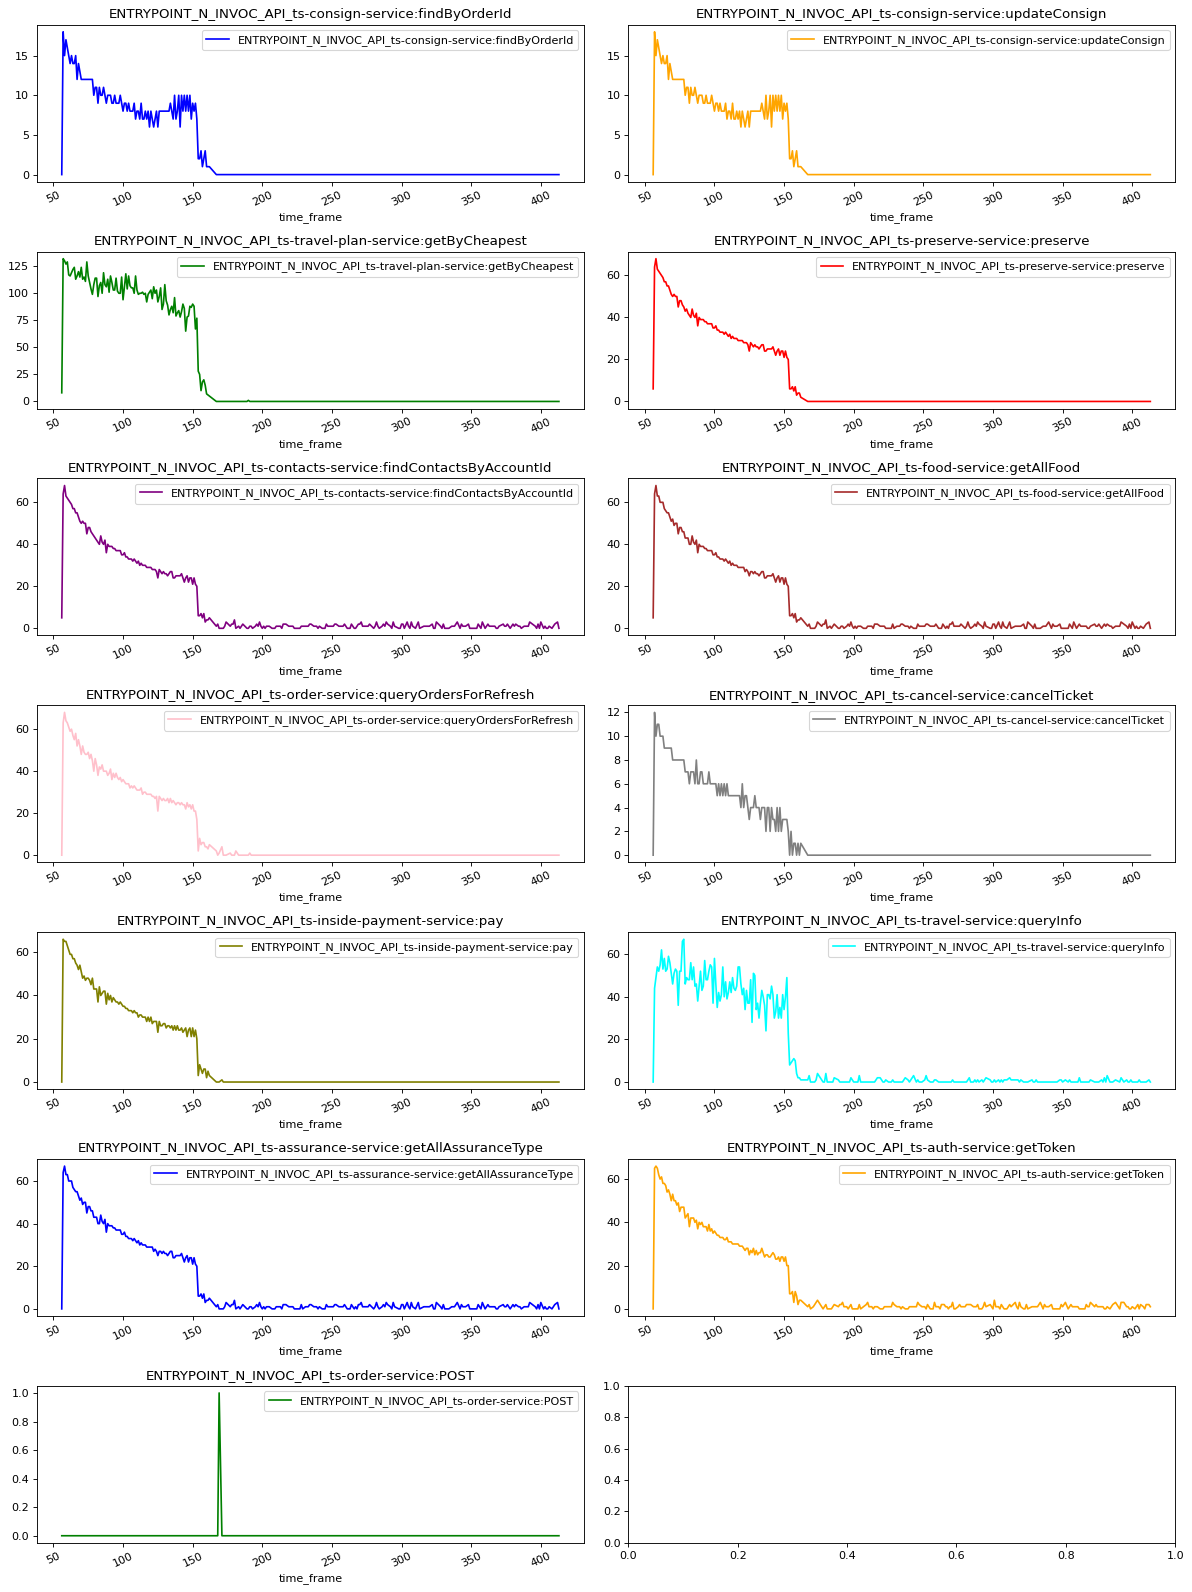

Data normalized
Input size 45 Output size 13
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                2944      
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 13)                429       
                                                                 
Total params: 5,453
Trainable params: 5,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 0s 39ms/step - loss: 171.7771 - val_loss: 0.5261
Epoch 2/100
5/5 [==============================] - 0s 9ms/step - loss: 104.4476 - val_loss: 0.2695
Epoch 3/100
5/5 [==============================] - 0s 8ms/step - loss: 1

Epoch 76/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0173 - val_loss: 0.0258
Epoch 77/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0195 - val_loss: 0.0259
Epoch 78/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0154 - val_loss: 0.0260
Epoch 79/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0180 - val_loss: 0.0260
Epoch 80/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0174 - val_loss: 0.0259
Epoch 81/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0158 - val_loss: 0.0258
Epoch 82/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0167 - val_loss: 0.0259
Epoch 83/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0161 - val_loss: 0.0259
Epoch 84/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0215 - val_loss: 0.0259
Epoch 85/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0239 - val_loss: 0.0257
Epoch 86/100
5/5 [=

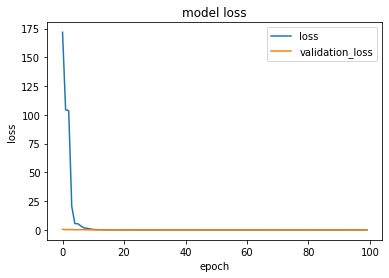

4/4 [==============================] - 0s 1ms/step
TOTAL MSE:  0.027213918237146143
TOTAL MAE:  0.09805086350278894
TOTAL MAPE:  0.89
FIRST 50 predictions
ENTRY ENTRYPOINT_AVG_EXTIME_ts-consign-service:findByOrderId
PRED [207.19244, 85.78625, 221.88788, 337.72412, 221.88788, 459.05972, 351.54034, 225.94594, 97.17111, 460.56967, 210.57599, 76.90808, 97.17111, 351.54034, 316.4667, 97.17111, 470.44302, 226.82436, 91.3566, 464.87305, 225.94594, 91.67294, 456.6268, 80.288475, 203.1352, 214.56343, 224.39104, 205.56694, 213.00893, 351.54034, 94.1047, 92.23502, 476.25595, 221.00986, 97.17111, 340.15668, 96.295044, 97.17111, 80.850555, 218.82304, 210.50342, 221.88788, 464.87305, 92.234634, 351.54034, 226.82436, 226.82436, 349.10898, 82.96636, 92.66695]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

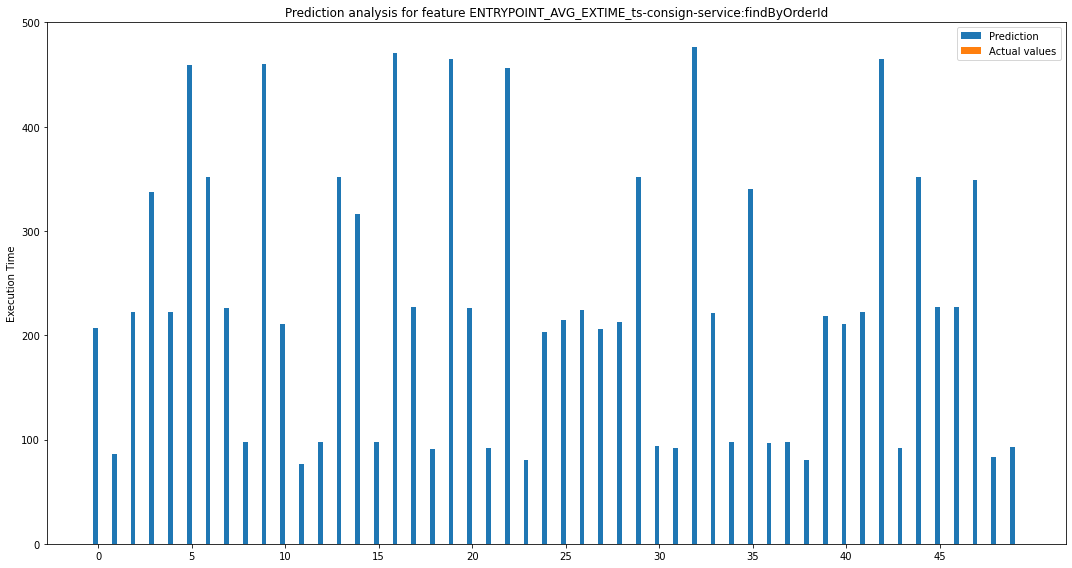

MAE:  229.44678298950194
MAPE:  100.0  %
MSE:  69128.27423417632
ENTRY ENTRYPOINT_AVG_EXTIME_ts-consign-service:updateConsign
PRED [1499.8351, 1318.207, 1378.017, 1539.4185, 1378.017, 1740.1504, 1446.7523, 1344.9741, 1247.0868, 1793.4198, 1430.033, 1348.679, 1247.0868, 1446.7523, 1734.9281, 1247.0868, 1669.0295, 1315.8213, 1338.4341, 1648.8021, 1344.9741, 1207.7549, 1761.695, 1278.8756, 1532.8777, 1416.0951, 1337.3678, 1511.3329, 1408.4872, 1446.7523, 1186.21, 1309.2819, 1577.6823, 1407.169, 1247.0868, 1517.8726, 1276.2393, 1247.0868, 1380.4019, 1317.1404, 1449.1375, 1378.017, 1648.8021, 1309.2816, 1446.7523, 1315.8213, 1315.8213, 1468.2975, 1337.8516, 1265.5228]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


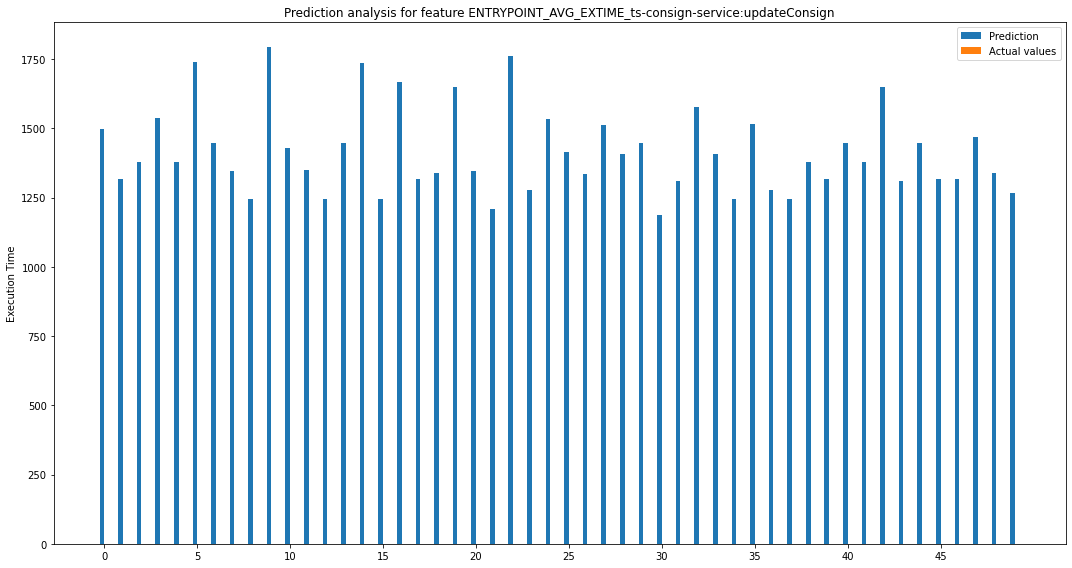

MAE:  1415.2043798828124
MAPE:  100.0  %
MSE:  2025626.5050671804
ENTRY ENTRYPOINT_AVG_EXTIME_ts-travel-plan-service:getByCheapest
PRED [11815422.0, 14651780.0, 11860303.0, 8434840.0, 11860303.0, 5278694.0, 8592579.0, 11867400.0, 15022282.0, 5860728.5, 11809597.0, 14388281.0, 15022282.0, 8592579.0, 8275837.5, 15022282.0, 5649200.0, 11754550.0, 15240893.0, 5060083.5, 11867400.0, 14752943.0, 5491465.0, 14382441.0, 11808340.0, 11496898.0, 11967329.0, 11595566.0, 11596815.0, 8592579.0, 14540180.0, 15128035.0, 5430597.0, 11973168.0, 15022282.0, 8222058.5, 15135139.0, 15022282.0, 14757533.0, 11378205.0, 11489805.0, 11860303.0, 5060083.5, 15128050.0, 8592579.0, 11754550.0, 11754550.0, 8805361.0, 14889531.0, 14421110.0]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


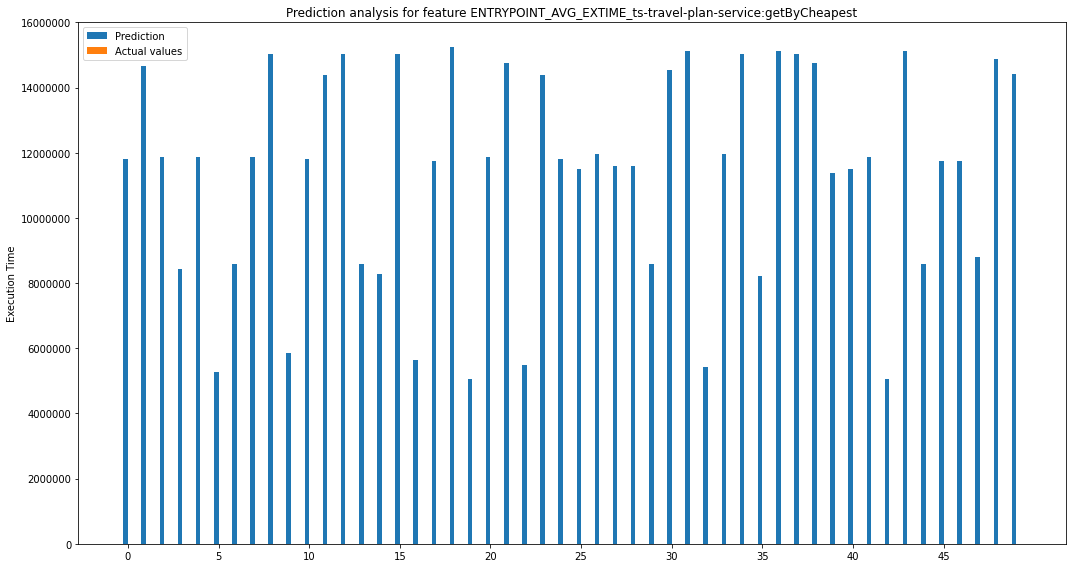

MAE:  11399541.89
MAPE:  100.0  %
MSE:  140468665577318.31
ENTRY ENTRYPOINT_AVG_EXTIME_ts-preserve-service:preserve
PRED [3021265.2, 7153983.0, 5000885.0, 248529.84, 5000885.0, -4155611.5, 1943528.4, 5333978.5, 8675890.0, -3869225.8, 3750409.0, 6076709.5, 8675890.0, 1943528.4, -2508775.2, 8675890.0, -2633764.5, 5618558.5, 7773582.0, -3253300.2, 5333978.5, 8327766.5, -4328782.5, 6805865.5, 2688124.0, 3812079.0, 5445462.5, 2861220.0, 3923525.8, 1943528.4, 8500919.0, 8058118.5, -1731420.0, 4716214.5, 8675890.0, 421676.28, 8391227.0, 8675890.0, 6536266.5, 4825872.5, 3478958.8, 5000885.0, -3253300.2, 8058169.0, 1943528.4, 5618558.5, 5618558.5, 1770426.5, 7008713.5, 7632392.0]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


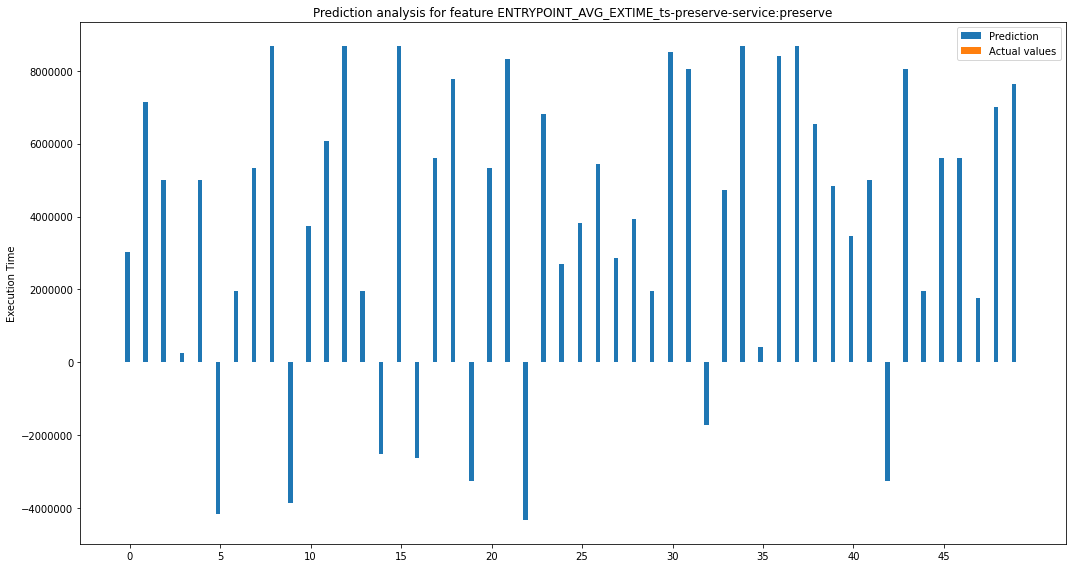

MAE:  5014030.1375
MAPE:  100.0  %
MSE:  31050342803473.746
ENTRY ENTRYPOINT_AVG_EXTIME_ts-contacts-service:findContactsByAccountId
PRED [1940.1426, 1821.6226, 1900.5939, 2021.7238, 1900.5939, 2183.178, 1985.4894, 1869.3906, 1781.1804, 2211.7727, 1898.1025, 1823.3386, 1781.1804, 1985.4894, 2131.2021, 1781.1804, 2142.7358, 1866.0762, 1819.0134, 2145.3445, 1869.3906, 1740.8553, 2178.97, 1781.2976, 1971.3466, 1909.8331, 1861.868, 1975.5547, 1902.31, 1985.4894, 1745.0629, 1815.6987, 2104.9028, 1903.9092, 1781.1804, 2025.9313, 1784.4956, 1781.1804, 1856.1406, 1864.477, 1941.0359, 1900.5939, 2145.3445, 1815.6984, 1985.4894, 1866.0762, 1866.0762, 1981.2815, 1815.5342, 1796.5073]
VALS [2218.0, 0.0, 2320.0, 2671.5, 2568.0, 2627.333333333333, 2689.5, 2579.0, 0.0, 2603.0, 2608.0, 0.0, 0.0, 2565.5, 2585.0, 0.0, 2623.333333333333, 2572.0, 0.0, 2569.333333333333, 2651.0, 0.0, 2657.333333333333, 0.0, 2669.0, 2633.0, 2567.0, 2451.0, 2576.0, 2528.0, 0.0, 0.0, 2586.6666666666665, 2512.0, 0.0, 2678.0, 0.

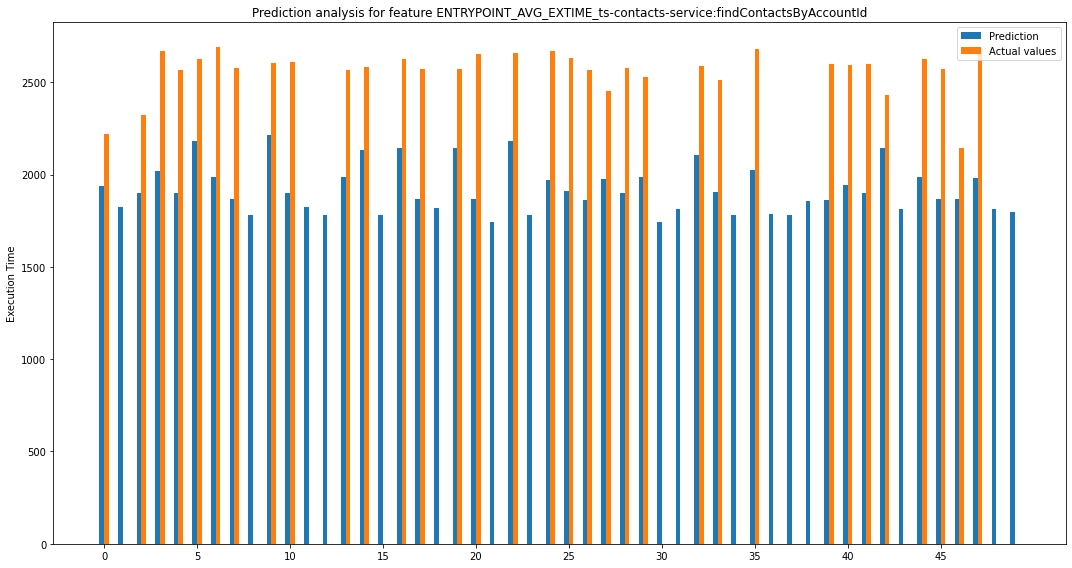

MAE:  993.0557023111978
MAPE:  53.5  %
MSE:  1331849.5614744662
ENTRY ENTRYPOINT_AVG_EXTIME_ts-food-service:getAllFood
PRED [15628.399, 15025.69, 15745.185, 16270.63, 15745.185, 16691.389, 16426.627, 15923.677, 15203.022, 16590.164, 15749.805, 15008.975, 15203.022, 16426.627, 15814.739, 15203.022, 16868.723, 15884.464, 15102.955, 16791.453, 15923.677, 15307.708, 16712.725, 15130.377, 15449.909, 15746.341, 15905.799, 15428.574, 15728.469, 16426.627, 15286.372, 15063.744, 16968.787, 15784.396, 15203.022, 16249.292, 15242.235, 15203.022, 14886.41, 15828.537, 15567.852, 15745.185, 16791.453, 15063.744, 16426.627, 15884.464, 15884.464, 16447.96, 15042.559, 15187.3125]
VALS [23692.0, 0.0, 29578.0, 30913.0, 27990.0, 21650.33333333333, 29342.0, 25415.0, 0.0, 23060.0, 24291.0, 0.0, 0.0, 24131.5, 24865.5, 0.0, 22494.33333333333, 26681.0, 0.0, 23799.33333333333, 25434.0, 0.0, 26248.666666666668, 0.0, 24962.0, 24196.0, 25061.0, 26588.0, 23713.0, 30214.5, 0.0, 0.0, 25245.33333333333, 24318.0, 0.0, 

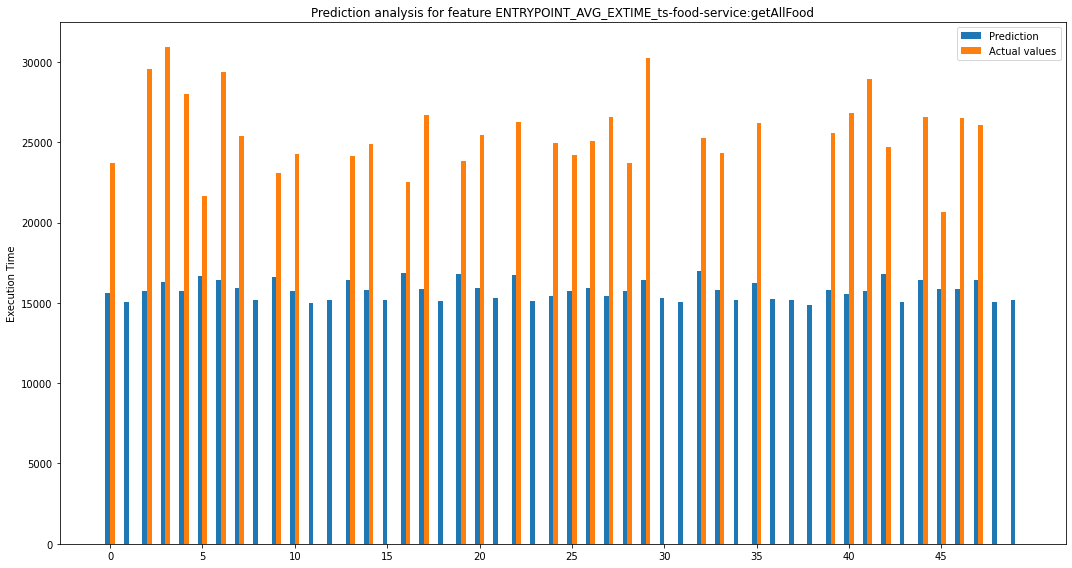

MAE:  11436.416490885415
MAPE:  73.16  %
MSE:  141739508.72025597
ENTRY ENTRYPOINT_AVG_EXTIME_ts-order-service:queryOrdersForRefresh
PRED [20937818.0, 19443812.0, 21319816.0, 22503382.0, 21319816.0, 23530304.0, 22989062.0, 21765068.0, 19992222.0, 23395520.0, 21238546.0, 19299812.0, 19992222.0, 22989062.0, 21271806.0, 19992222.0, 24078686.0, 21661386.0, 19754252.0, 23768246.0, 21765068.0, 20148810.0, 23593090.0, 19600430.0, 20492594.0, 21216686.0, 21724142.0, 20429808.0, 21175760.0, 22989062.0, 20086108.0, 19650624.0, 24316628.0, 21423470.0, 19992222.0, 22440626.0, 20095876.0, 19992222.0, 19102214.0, 21413702.0, 20771434.0, 21319816.0, 23768246.0, 19650596.0, 22989062.0, 21661386.0, 21661386.0, 23051764.0, 19496332.0, 19836572.0]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


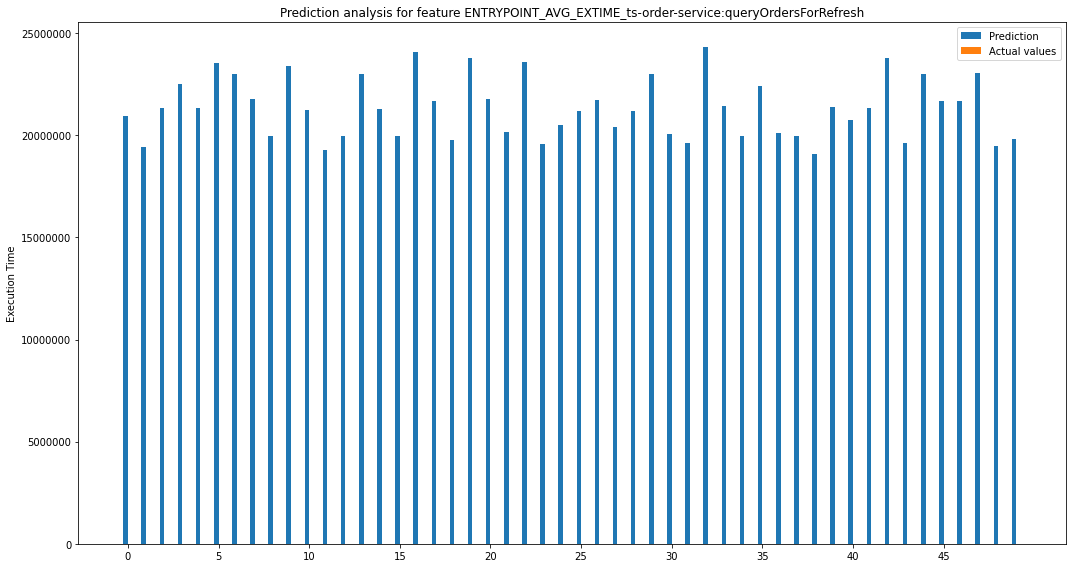

MAE:  21341975.92
MAPE:  100.0  %
MSE:  457576762267540.94
ENTRY ENTRYPOINT_AVG_EXTIME_ts-cancel-service:cancelTicket
PRED [1122.5016, 2268.5107, 2340.765, 1100.7516, 2340.765, -659.60944, 2202.7314, 3023.7317, 3278.0286, -1248.631, 1945.5597, 1965.7875, 3278.0286, 2202.7314, -1507.3185, 3278.0286, 349.90833, 3140.0215, 2362.5083, 255.94347, 3023.7317, 3798.396, -752.05853, 2788.852, 439.4892, 2014.2137, 3047.5657, 531.93823, 2038.0088, 2202.7314, 3890.8582, 2478.759, 1265.4612, 2224.4685, 3278.0286, 1193.2137, 3161.7322, 3278.0286, 1469.2346, 2953.5747, 1331.2406, 2340.765, 255.94347, 2478.7656, 2202.7314, 3140.0215, 3140.0215, 2110.276, 2181.9941, 3038.014]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


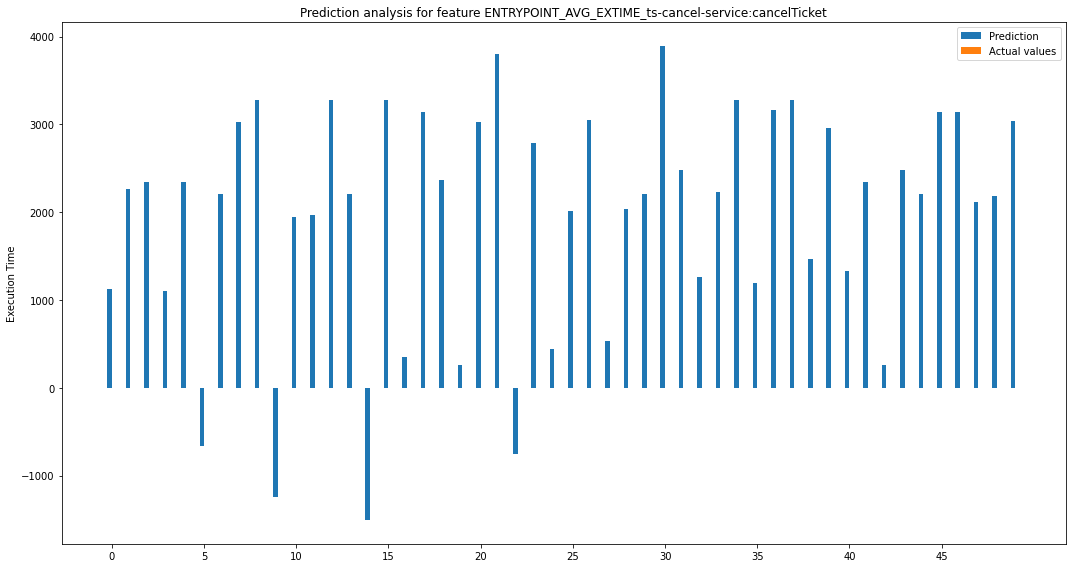

MAE:  2158.439583129883
MAPE:  100.0  %
MSE:  5600950.42388067
ENTRY ENTRYPOINT_AVG_EXTIME_ts-inside-payment-service:pay
PRED [65150.906, 72812.79, 57699.598, 52070.43, 57699.598, 52075.707, 44386.703, 50989.016, 64534.508, 56753.754, 58310.832, 74018.47, 64534.508, 44386.703, 73305.055, 64534.508, 43797.4, 51221.55, 70780.12, 45830.082, 50989.016, 58900.02, 51481.22, 67178.33, 71861.586, 59267.305, 50627.035, 72456.16, 58905.33, 44386.703, 59494.492, 71012.664, 37551.773, 57467.195, 64534.508, 52664.93, 64302.125, 64534.508, 79290.91, 52659.645, 65978.0, 57699.598, 45830.082, 71012.65, 44386.703, 51221.55, 51221.55, 43792.223, 72127.83, 66787.14]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


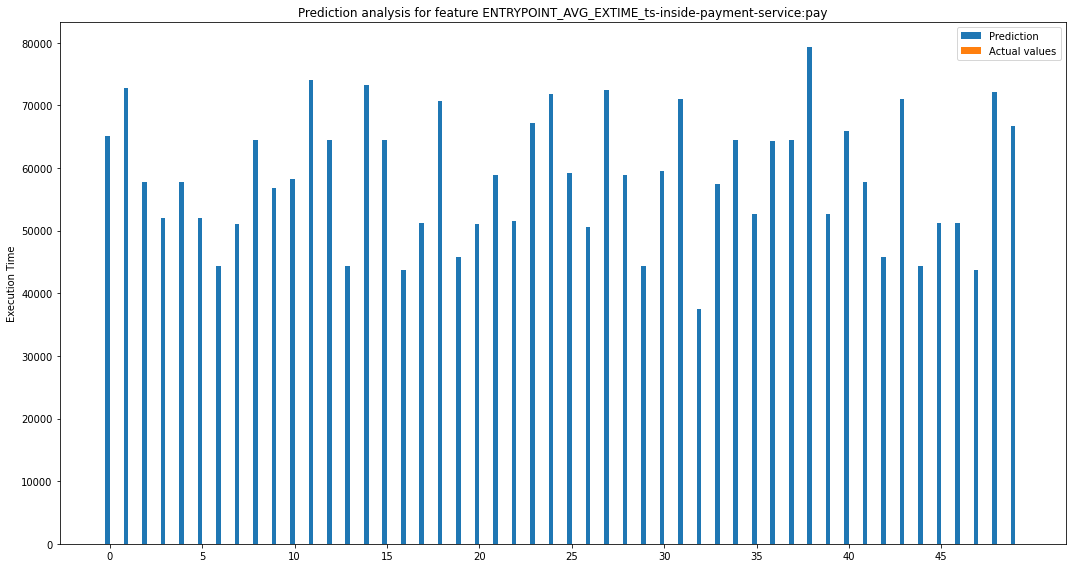

MAE:  58490.299921875
MAPE:  100.0  %
MSE:  3523331713.3676805
ENTRY ENTRYPOINT_AVG_EXTIME_ts-travel-service:queryInfo
PRED [16759396.0, 19550452.0, 15624307.0, 13330437.0, 15624307.0, 10368105.0, 12377092.0, 15680153.0, 18745648.0, 9814961.0, 16600296.0, 20377922.0, 18745648.0, 12377092.0, 14386922.0, 18745648.0, 9563256.0, 15498432.0, 19053222.0, 10060577.0, 15680153.0, 19414110.0, 10516555.0, 20218866.0, 16703437.0, 16484956.0, 15647042.0, 16554963.0, 16451777.0, 12377092.0, 19265614.0, 18871524.0, 9255728.0, 15806006.0, 18745648.0, 13181940.0, 18927392.0, 18745648.0, 19676304.0, 16144204.0, 16429111.0, 15624307.0, 10060577.0, 18871568.0, 12377092.0, 15498432.0, 15498432.0, 12525633.0, 19690692.0, 19466146.0]
VALS [22164.0, 0.0, 0.0, 29974.0, 0.0, 25834.000000000004, 0.0, 30075.0, 0.0, 28825.999999999996, 22362.0, 28233.0, 0.0, 0.0, 30182.0, 0.0, 28538.0, 0.0, 30582.0, 0.0, 30544.999999999996, 16443.0, 30219.0, 31299.000000000004, 41269.0, 36756.0, 21715.0, 0.0, 29677.0, 0.0, 0.0, 0

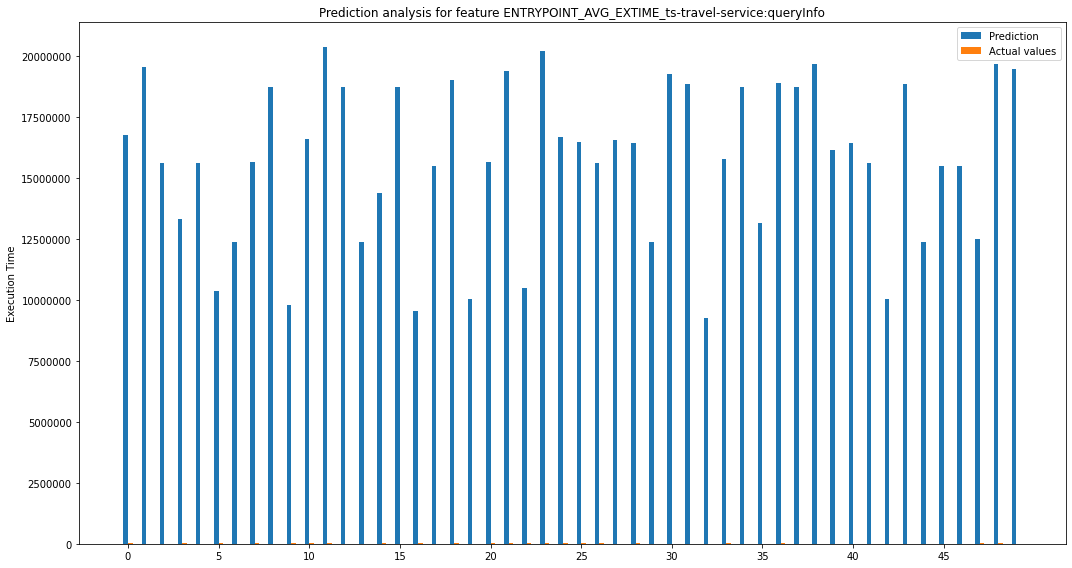

MAE:  15747337.78
MAPE:  99.92  %
MSE:  258459432020017.38
ENTRY ENTRYPOINT_AVG_EXTIME_ts-assurance-service:getAllAssuranceType
PRED [1222.6827, 1308.2968, 1201.4448, 1098.4459, 1201.4448, 998.4974, 1086.1934, 1201.4412, 1307.7069, 1015.8864, 1216.3699, 1311.5596, 1307.7069, 1086.1934, 1117.0157, 1307.7069, 997.9068, 1192.4554, 1325.6823, 980.5218, 1201.4412, 1304.6562, 1010.15967, 1305.2461, 1222.6873, 1202.0311, 1204.1178, 1211.0248, 1204.7079, 1086.1934, 1292.9939, 1316.6963, 979.9321, 1210.4305, 1307.7069, 1086.7837, 1316.6923, 1307.7069, 1317.2864, 1186.732, 1202.0352, 1201.4448, 980.5218, 1316.6963, 1086.1934, 1192.4554, 1192.4554, 1097.8556, 1320.6279, 1295.9619]
VALS [1738.0, 0.0, 1764.0, 1863.0, 1761.0, 1853.6666666666667, 1838.5, 1774.0, 0.0, 1596.6666666666667, 1799.0, 0.0, 0.0, 1913.5, 1875.0, 0.0, 1846.0, 1723.0, 0.0, 1897.6666666666667, 2035.9999999999998, 0.0, 1808.3333333333333, 0.0, 1939.0, 1939.0, 1763.0, 1714.0, 1945.0, 1833.0, 0.0, 0.0, 1854.3333333333333, 1605.0, 0

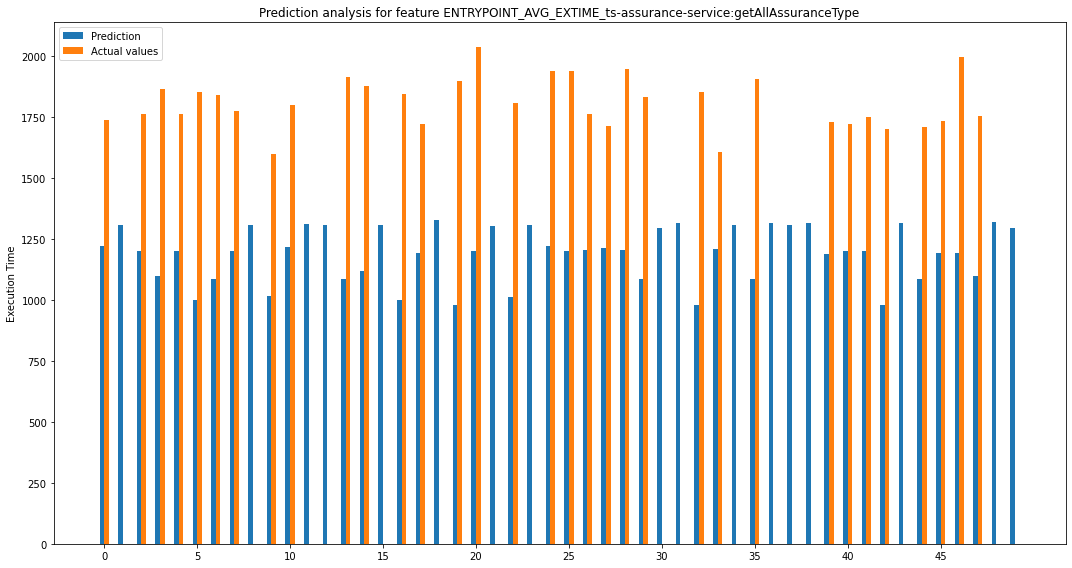

MAE:  891.5845544433594
MAPE:  74.04  %
MSE:  897154.4573960566
ENTRY ENTRYPOINT_AVG_EXTIME_ts-auth-service:getToken
PRED [84797.3, 81448.94, 83362.32, 86425.63, 83362.32, 89866.42, 85379.12, 83091.234, 80685.984, 90422.57, 84032.836, 81835.91, 80685.984, 85379.12, 88507.695, 80685.984, 89103.47, 82702.77, 81733.99, 88818.414, 83091.234, 80308.5, 90149.984, 81071.45, 85068.39, 83854.18, 82986.336, 84784.83, 83749.3, 85379.12, 80024.93, 81345.53, 88055.45, 83750.79, 80685.984, 86142.08, 81074.43, 80685.984, 82108.49, 82701.28, 84125.28, 83362.32, 88818.414, 81345.53, 85379.12, 82702.77, 82702.77, 85662.67, 81706.27, 80920.51]
VALS [103485.0, 107789.0, 104256.0, 109350.0, 106554.0, 106148.0, 0.0, 0.0, 104995.0, 105636.66666666669, 104126.0, 107604.5, 105005.0, 0.0, 104508.25, 105539.0, 106219.0, 0.0, 104653.5, 104798.0, 0.0, 0.0, 107743.5, 109966.0, 105515.66666666669, 104479.0, 0.0, 103229.33333333331, 104078.0, 0.0, 0.0, 106896.0, 0.0, 105184.0, 104888.0, 109425.0, 103539.0, 106571.0, 

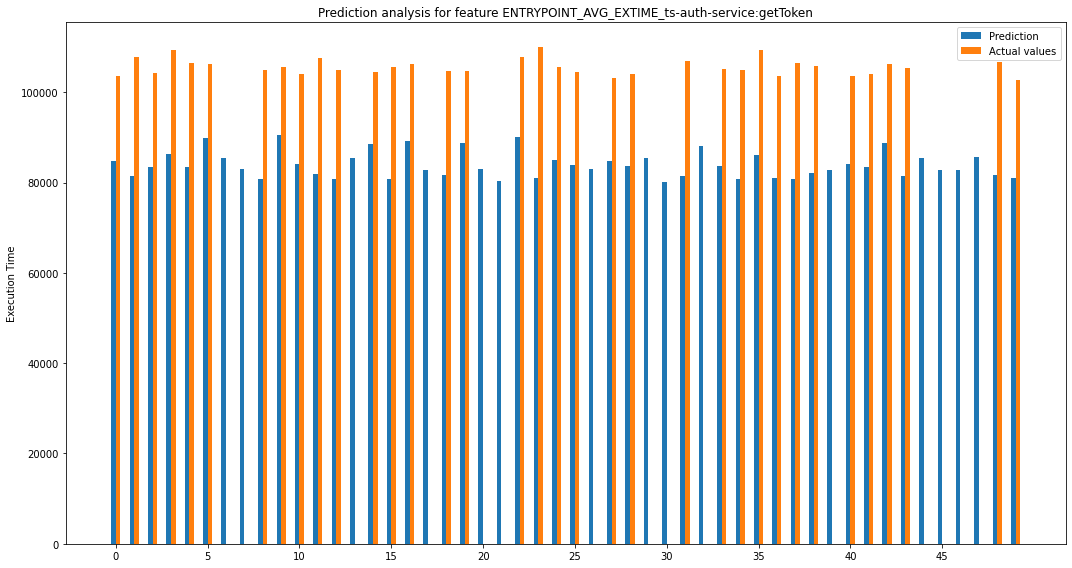

MAE:  40231.44328125
MAPE:  48.11  %
MSE:  2437899375.2537584
ENTRY ENTRYPOINT_AVG_EXTIME_ts-order-service:POST
PRED [180785.38, 93926.15, 163616.23, 310033.75, 163616.23, 497695.5, 271307.38, 107975.24, 21840.666, 493780.2, 134897.6, 98566.36, 21840.666, 271307.38, 450287.28, 21840.666, 425610.94, 129531.55, 34367.324, 485168.28, 107975.24, -19405.693, 464336.9, 52679.39, 236426.36, 180060.19, 96172.3, 269786.12, 168256.58, 271307.38, 13954.487, 55925.62, 413084.0, 142058.88, 21840.666, 343393.25, 283.56714, 21840.666, 128010.57, 155730.6, 235702.52, 163616.23, 485168.28, 55924.29, 271307.38, 129531.55, 129531.55, 237948.39, 57615.83, 74594.945]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


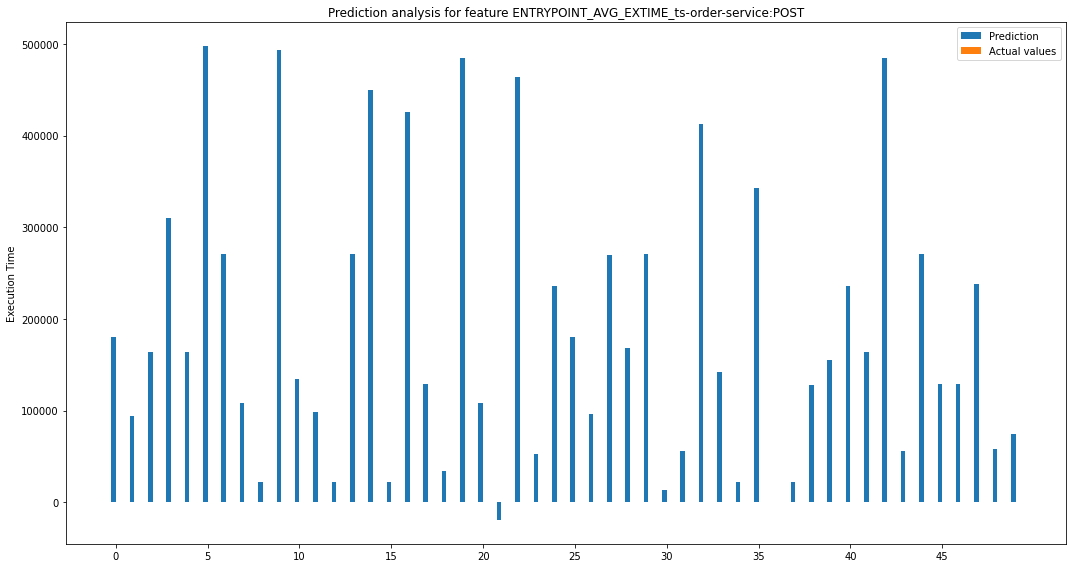

MAE:  187629.28296386718
MAPE:  100.0  %
MSE:  57160166216.13291
MAE:  225.67457234490777
MAPE:  1.0
MSE:  65882.86081258657
MAE:  1409.0518308029962
MAPE:  1.0
MSE:  2007967.8787266412
MAE:  11456211.231958764
MAPE:  1.0
MSE:  140550757420500.4
MAE:  4885524.345521907
MAPE:  1.0
MSE:  30416849415109.844
MAE:  1016.9839194386276
MAPE:  0.55
MSE:  1356461.8609618845
MAE:  11473.846887752361
MAPE:  0.73
MSE:  142167503.6455405
MAE:  21291366.94845361
MAPE:  1.0
MSE:  455207856098394.25
MAE:  2158.559708113523
MAPE:  1.0
MSE:  5711084.227227914
MAE:  58672.385107925256
MAPE:  1.0
MSE:  3530957997.6884966
MAE:  15861797.936426118
MAPE:  1.0
MSE:  261276500161254.84
MAE:  905.3926125228201
MAPE:  0.75
MSE:  913162.0143934665
MAE:  39980.801653780065
MAPE:  0.48
MSE:  2406491073.5543804
MAE:  187522.53631151337
MAPE:  1.0
MSE:  54524246049.71003
Loading datasource from avv_dataset_DT_60000.csv
Datasource loaded: len = 60
Entrypoints size: 13
Entrypoint list
[   'ENTRYPOINT_N_INVOC_API_ts-con

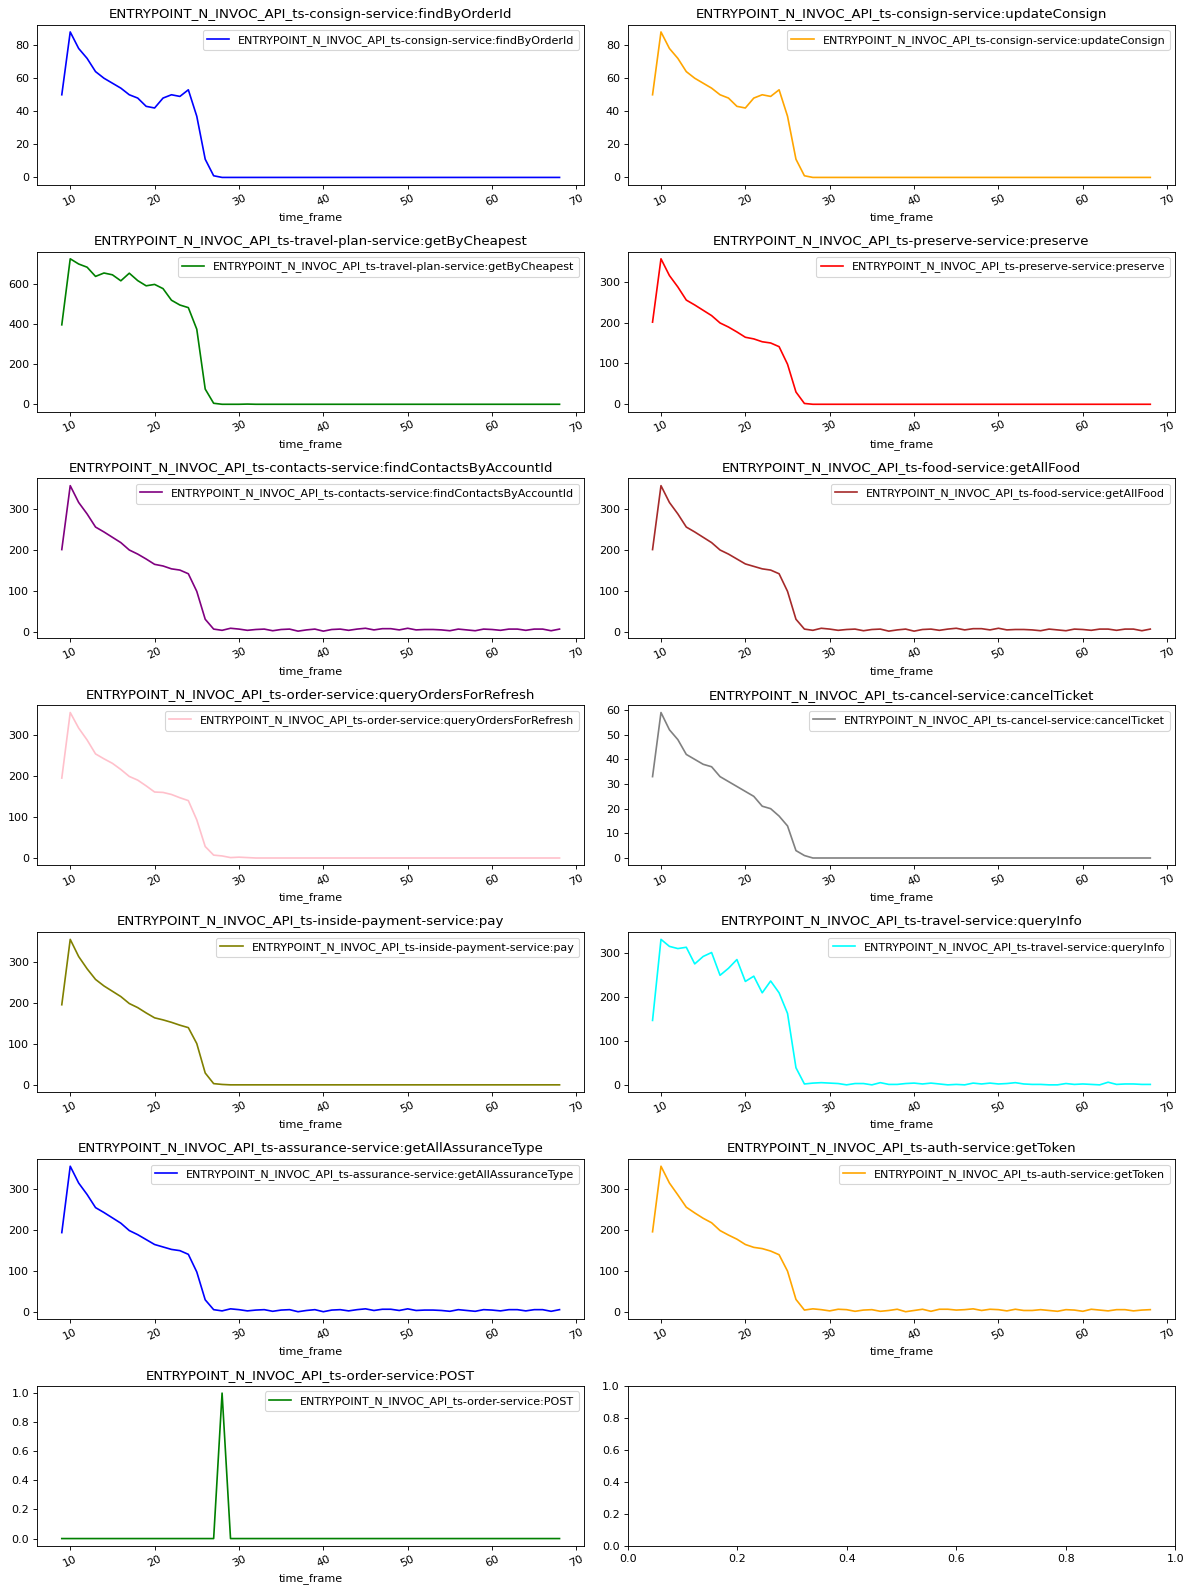

Data normalized
Input size 45 Output size 13
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 64)                2944      
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 13)                429       
                                                                 
Total params: 5,453
Trainable params: 5,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 419ms/step - loss: 0.5413 - val_loss: 0.0805
Epoch 2/100
1/1 [==============================] - 0s 27ms/step - loss: 18.9695 - val_loss: 1.7750
Epoch 3/100
1/1 [==============================] - 0s 28ms/step - loss: 5

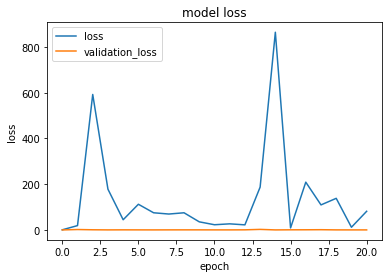

1/1 [==============================] - 0s 43ms/step
TOTAL MSE:  0.16417667481778642
TOTAL MAE:  0.2942451627282996
TOTAL MAPE:  1.88
FIRST 50 predictions
ENTRY ENTRYPOINT_AVG_EXTIME_ts-consign-service:findByOrderId
PRED [85.44471, -36.936947, 98.53875, 36.171097, 42.96361, 105.235374, 129.30843, -8.336381, 99.83959, 120.445595, -14.933594, 31.974813, 69.302444, 4.8185263, 56.841053, 99.78649, 22.107971, 29.766186, 133.79651, -2.9399846]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


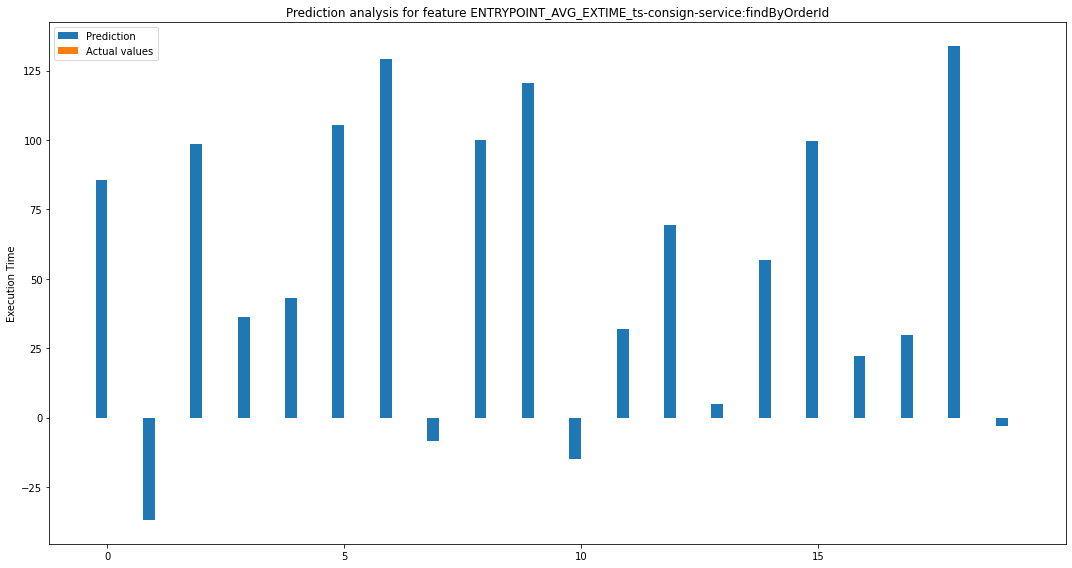

MAE:  61.47440277338028
MAPE:  100.0  %
MSE:  5620.680506258579
ENTRY ENTRYPOINT_AVG_EXTIME_ts-consign-service:updateConsign
PRED [-7667.45, -7779.634, -7666.935, -7612.8447, -7699.7334, -7770.984, -7724.286, -7761.9673, -7774.6377, -7631.917, -7727.4546, -7654.665, -7710.9023, -7795.364, -7598.423, -7737.5903, -7753.03, -7720.5444, -7717.6924, -7758.3135]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


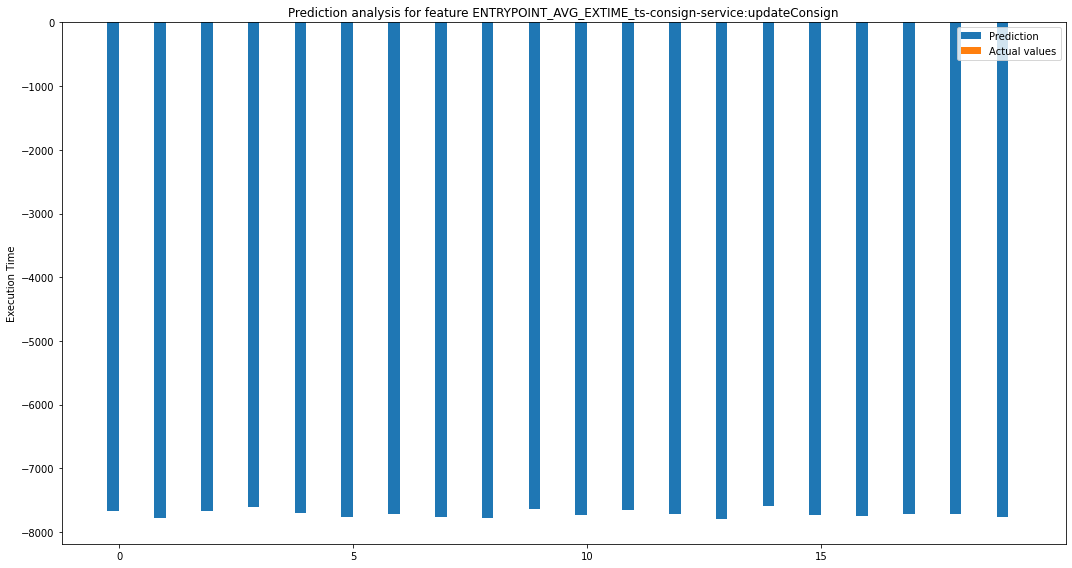

MAE:  7713.218408203125
MAPE:  100.0  %
MSE:  59496886.775049165
ENTRY ENTRYPOINT_AVG_EXTIME_ts-travel-plan-service:getByCheapest
PRED [-44725730.0, -49280564.0, -45581356.0, -43925628.0, -46611790.0, -47756544.0, -45421640.0, -48518480.0, -48303584.0, -43298036.0, -47508204.0, -46030096.0, -45390256.0, -49048652.0, -44833936.0, -46161956.0, -47799868.0, -47712212.0, -45504050.0, -47971428.0]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


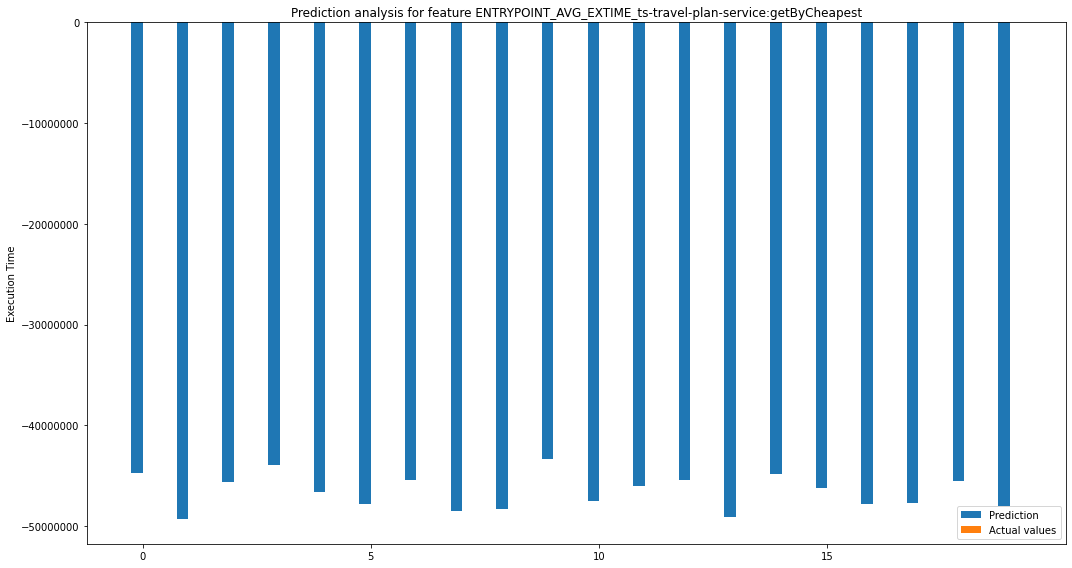

MAE:  46569200.4
MAPE:  100.0  %
MSE:  2171528412619505.5
ENTRY ENTRYPOINT_AVG_EXTIME_ts-preserve-service:preserve
PRED [43813828.0, 51105196.0, 45156372.0, 43380040.0, 46802024.0, 47617508.0, 43891236.0, 49582850.0, 48462164.0, 41405216.0, 48314936.0, 46337336.0, 44293964.0, 50072436.0, 45103780.0, 45215000.0, 48457700.0, 48598772.0, 44048960.0, 48738156.0]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


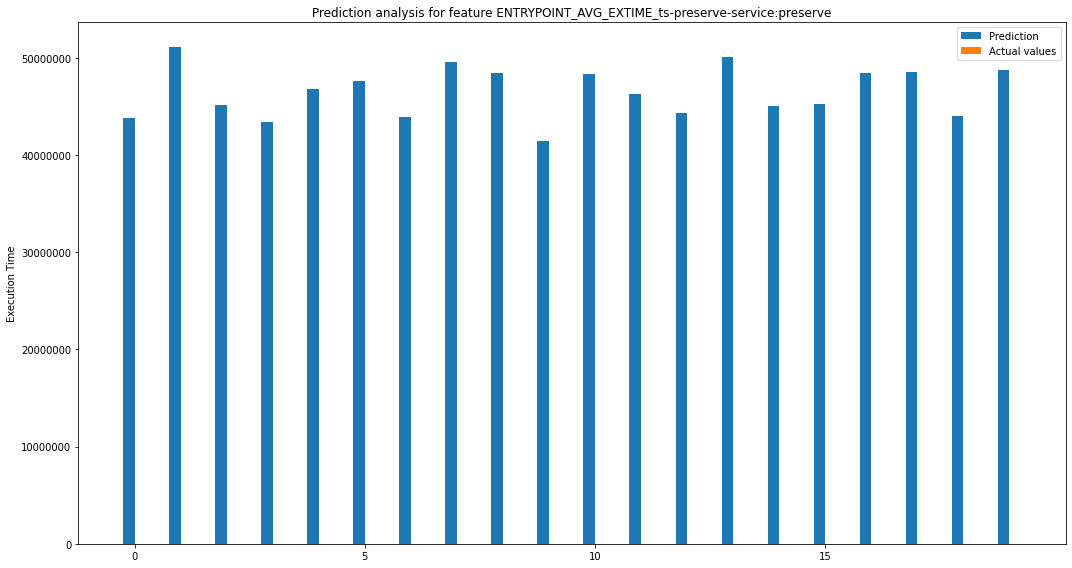

MAE:  46519873.6
MAPE:  100.0  %
MSE:  2170659433116384.0
ENTRY ENTRYPOINT_AVG_EXTIME_ts-contacts-service:findContactsByAccountId
PRED [2379.9912, 2378.6313, 2370.6484, 2391.501, 2369.2537, 2356.937, 2354.692, 2360.7183, 2349.7786, 2368.9558, 2368.4028, 2369.4993, 2360.4292, 2359.9197, 2395.3948, 2357.7183, 2372.5784, 2370.6482, 2353.5947, 2367.8765]
VALS [2604.25, 2592.875, 2589.75, 2654.8, 2530.0, 2568.0, 2678.0, 2514.5, 2492.0, 2684.5, 2550.0, 2671.0, 2748.6666666666665, 2584.1666666666665, 2707.333333333333, 2775.6666666666665, 3112.333333333333, 2575.5, 2461.0, 2585.1666666666665]


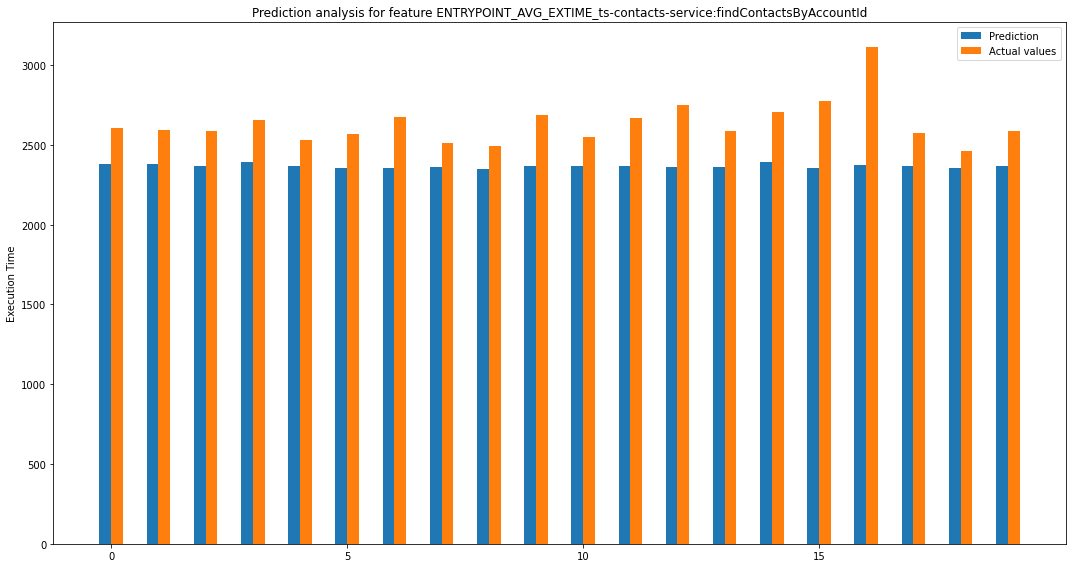

MAE:  266.11696940104156
MAPE:  11.23  %
MSE:  88835.88038159556
ENTRY ENTRYPOINT_AVG_EXTIME_ts-food-service:getAllFood
PRED [22112.7, 22344.941, 22120.441, 22112.559, 22179.104, 22191.053, 22078.473, 22260.537, 22197.562, 22013.986, 22234.418, 22151.697, 22104.89, 22281.816, 22148.543, 22125.732, 22250.422, 22233.72, 22075.691, 22254.027]
VALS [23367.75, 24019.75, 24208.0, 25580.8, 27158.2, 25013.5, 26175.0, 25903.666666666668, 25083.25, 26062.5, 25687.166666666668, 26528.2, 25850.33333333333, 26666.83333333333, 24477.666666666668, 25732.0, 25304.666666666668, 23787.5, 25006.5, 27738.666666666668]


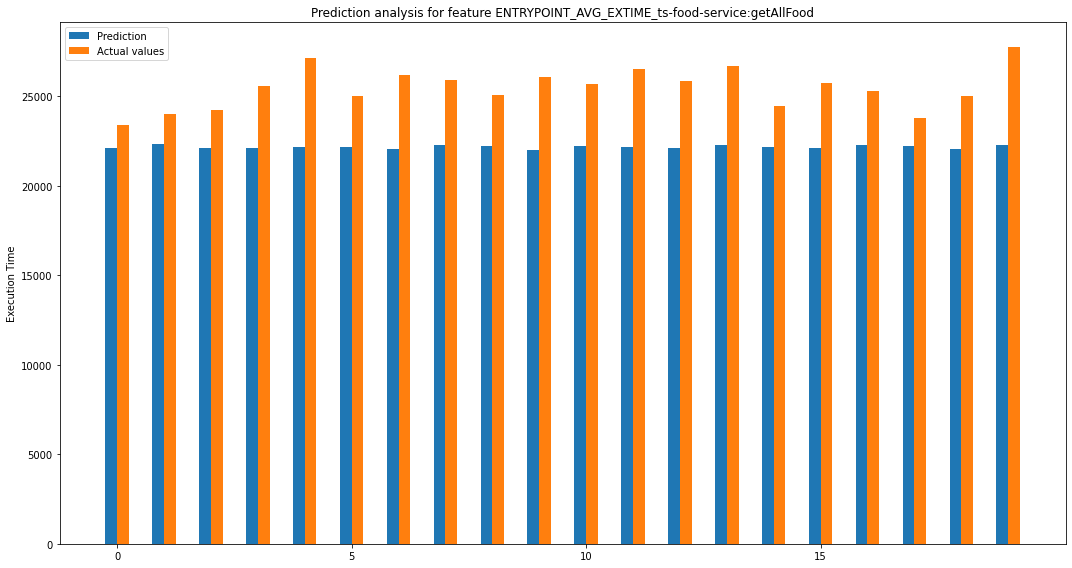

MAE:  3293.98177734375
MAPE:  14.86  %
MSE:  12073571.33693785
ENTRY ENTRYPOINT_AVG_EXTIME_ts-order-service:queryOrdersForRefresh
PRED [211606300.0, 219238670.0, 210116050.0, 214203100.0, 212621220.0, 209787200.0, 206592480.0, 214479260.0, 209103150.0, 207215980.0, 215085650.0, 212228510.0, 209409460.0, 214577340.0, 214835310.0, 208680980.0, 215061680.0, 214198180.0, 206338640.0, 215163360.0]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


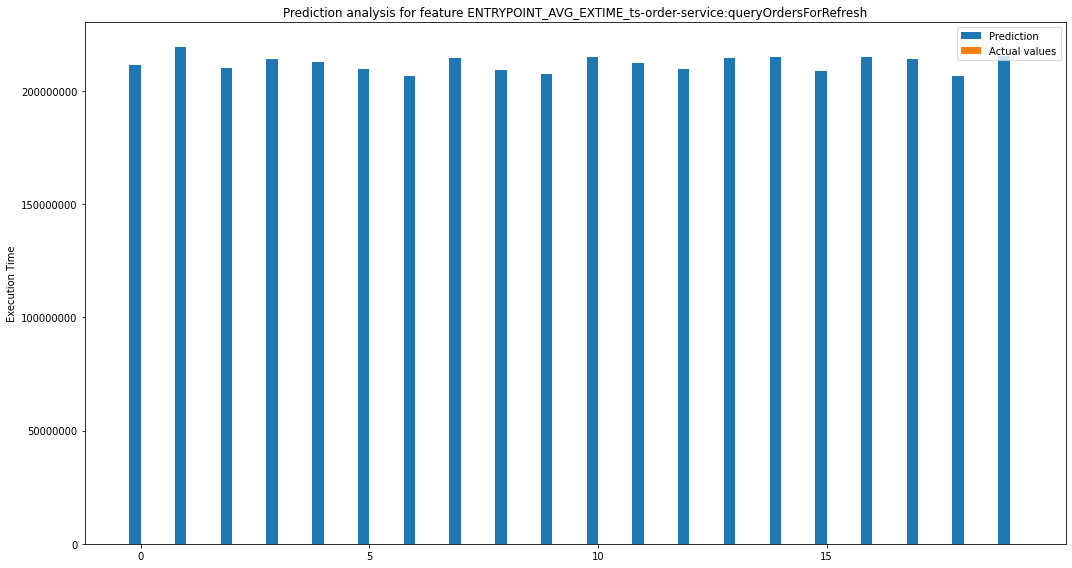

MAE:  212027126.4
MAPE:  100.0  %
MSE:  4.4967059140905704e+16
ENTRY ENTRYPOINT_AVG_EXTIME_ts-cancel-service:cancelTicket
PRED [-1980.5942, -2019.2444, -2509.7578, -1437.8115, -2371.293, -3017.3188, -2821.9937, -2534.2124, -3298.7483, -2253.237, -2188.6416, -2346.2583, -2399.1528, -2620.4531, -1729.5575, -2711.02, -2241.1743, -2446.861, -2927.3792, -2252.7852]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


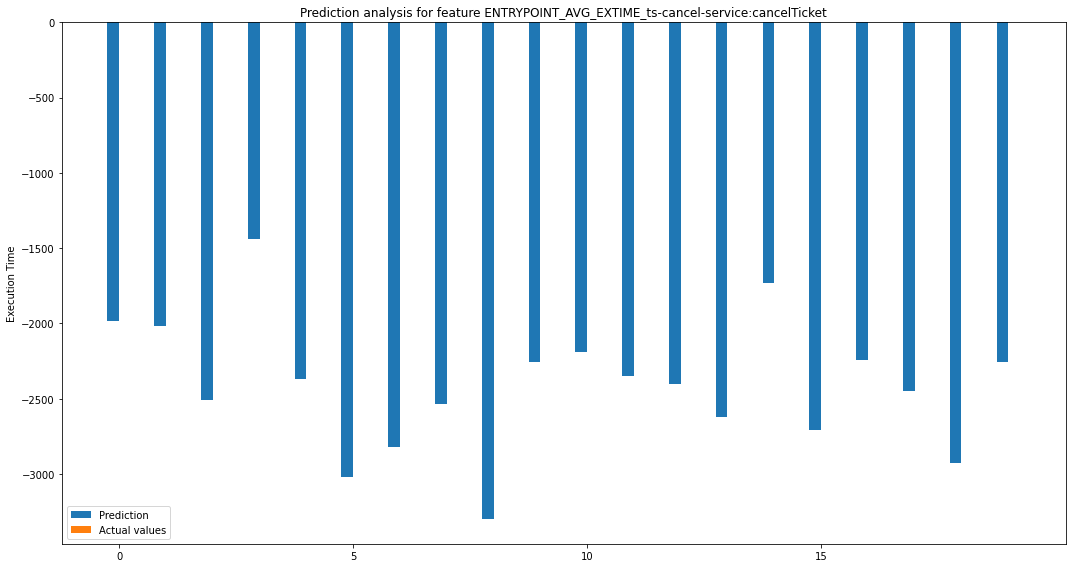

MAE:  2405.3747131347654
MAPE:  100.0  %
MSE:  5967579.901666788
ENTRY ENTRYPOINT_AVG_EXTIME_ts-inside-payment-service:pay
PRED [-315560.22, -336867.4, -317220.78, -314490.1, -323434.1, -325398.56, -316695.8, -332750.12, -327155.78, -309057.66, -329470.62, -321283.9, -319090.16, -334360.75, -315545.7, -320515.75, -329227.38, -327697.12, -316333.2, -330992.9]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


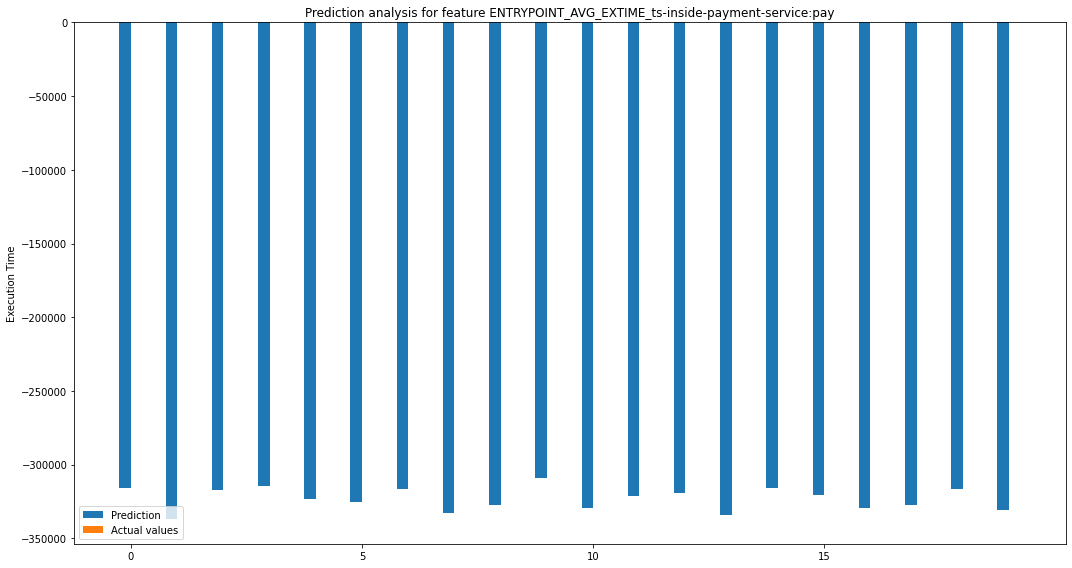

MAE:  323157.4
MAPE:  100.0  %
MSE:  104486978588.90479
ENTRY ENTRYPOINT_AVG_EXTIME_ts-travel-service:queryInfo
PRED [-16700802.0, -16506165.0, -16014048.0, -17400984.0, -16296870.0, -15373164.0, -15854061.0, -16162669.0, -15085485.0, -16576330.0, -16605226.0, -16383097.0, -16498003.0, -15995032.0, -16779376.0, -15944068.0, -16326160.0, -16069186.0, -15747099.0, -16450329.0]
VALS [25445.75, 29360.0, 25856.666666666668, 33952.4, 25696.0, 30514.0, 31058.0, 0.0, 0.0, 27794.999999999996, 21707.999999999996, 30614.499999999996, 29870.0, 0.0, 25155.666666666668, 34649.0, 27236.0, 23092.0, 21414.0, 29062.0]


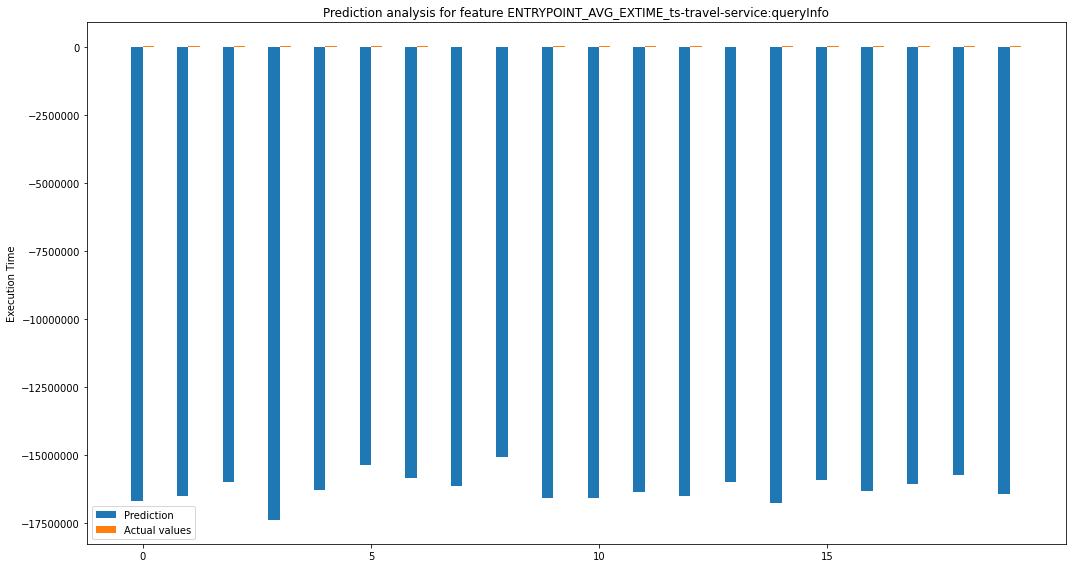

MAE:  16262031.649166668
MAPE:  100.14  %
MSE:  264709156678270.0
ENTRY ENTRYPOINT_AVG_EXTIME_ts-assurance-service:getAllAssuranceType
PRED [1355.7847, 1343.3605, 1363.8654, 1341.7555, 1360.5723, 1375.9006, 1382.8779, 1363.3661, 1381.4559, 1370.3842, 1356.6609, 1359.5717, 1373.338, 1364.8252, 1337.2306, 1377.0132, 1355.0898, 1356.7744, 1383.9548, 1357.8107]
VALS [1647.25, 1854.75, 1932.25, 1860.6, 1817.6, 1792.0, 1905.0, 1717.8333333333333, 1786.75, 1756.0, 1931.5, 1875.0, 1886.3333333333333, 1958.6666666666667, 1762.5, 1862.6666666666667, 1954.1666666666667, 1759.3333333333333, 1880.0, 1902.3333333333333]


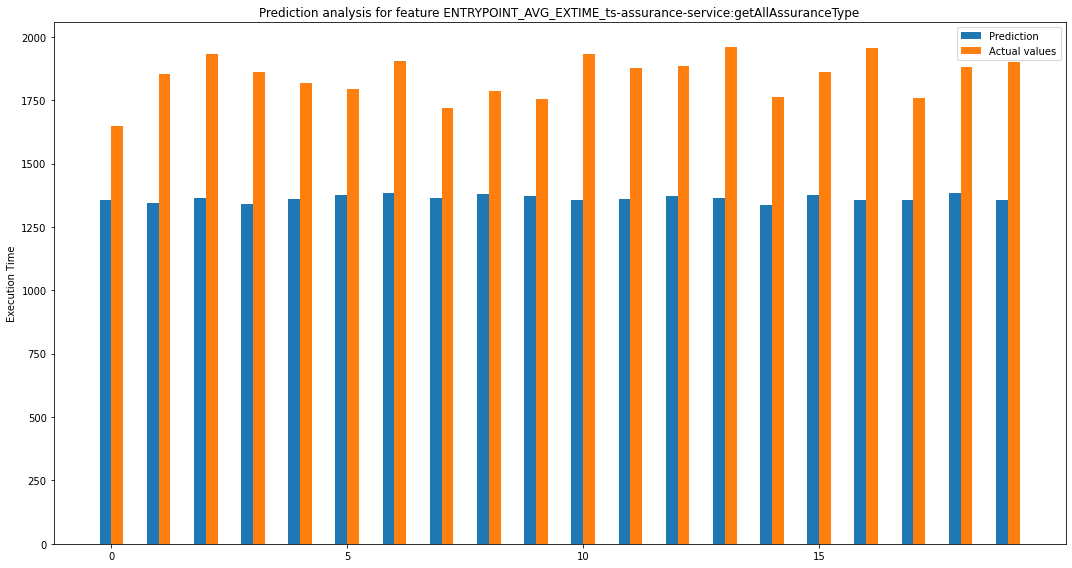

MAE:  479.04705240885426
MAPE:  35.15  %
MSE:  236205.52507607779
ENTRY ENTRYPOINT_AVG_EXTIME_ts-auth-service:getToken
PRED [108212.84, 108099.64, 108097.76, 108300.68, 108088.19, 107981.07, 108045.3, 108003.42, 107911.516, 108174.59, 108080.68, 108084.32, 108100.375, 107994.69, 108252.695, 108047.14, 108095.96, 108057.11, 108030.63, 108072.97]
VALS [105892.85714285714, 104965.16666666669, 104701.66666666669, 106639.85714285714, 103441.5, 105966.0, 106160.0, 104347.5, 105287.5, 106361.16666666669, 103795.8, 107475.0, 106196.42857142857, 104816.2, 105592.66666666669, 104892.16666666669, 105390.66666666669, 106574.0, 103443.8, 109103.33333333331]


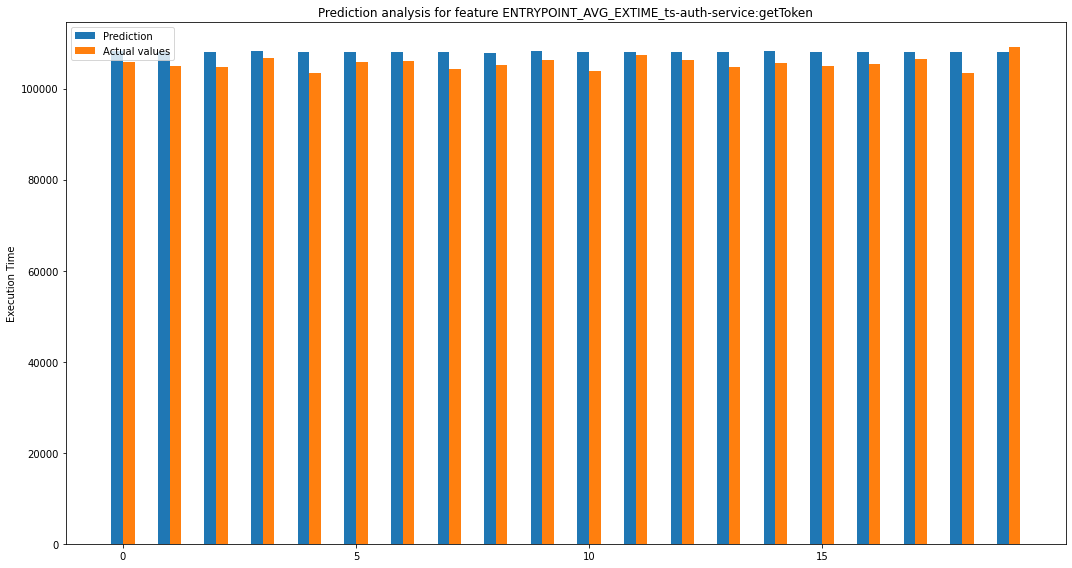

MAE:  2637.451555059517
MAPE:  2.44  %
MSE:  8167655.968205745
ENTRY ENTRYPOINT_AVG_EXTIME_ts-order-service:POST
PRED [19310832.0, 19719612.0, 19186768.0, 19493444.0, 19361688.0, 19146386.0, 19035068.0, 19485182.0, 19102868.0, 19098532.0, 19539994.0, 19351590.0, 19241722.0, 19472194.0, 19439446.0, 19149882.0, 19489982.0, 19419042.0, 19008598.0, 19528700.0]
VALS [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


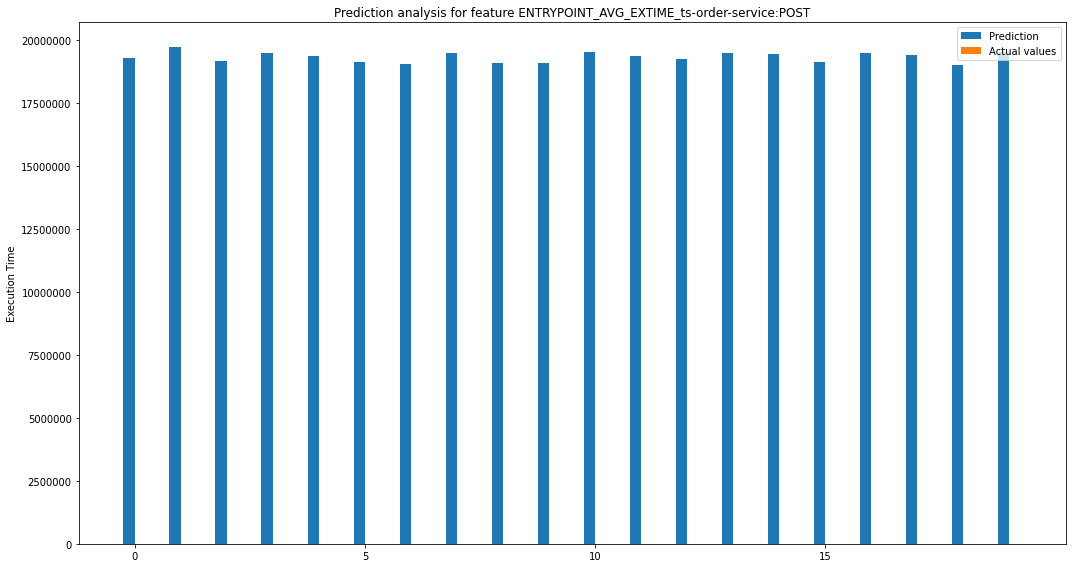

MAE:  19329076.5
MAPE:  100.0  %
MSE:  373650379766992.6
MAE:  61.47440277338028
MAPE:  1.0
MSE:  5620.680506258579
MAE:  7713.218408203125
MAPE:  1.0
MSE:  59496886.775049165
MAE:  46569200.4
MAPE:  1.0
MSE:  2171528412619505.5
MAE:  46519873.6
MAPE:  1.0
MSE:  2170659433116384.0
MAE:  266.11696940104156
MAPE:  0.11
MSE:  88835.88038159556
MAE:  3293.98177734375
MAPE:  0.15
MSE:  12073571.33693785
MAE:  212027126.4
MAPE:  1.0
MSE:  4.4967059140905704e+16
MAE:  2405.3747131347654
MAPE:  1.0
MSE:  5967579.901666788
MAE:  323157.4
MAPE:  1.0
MSE:  104486978588.90479
MAE:  16262031.649166668
MAPE:  1.0
MSE:  264709156678270.0
MAE:  479.04705240885426
MAPE:  0.35
MSE:  236205.52507607779
MAE:  2637.451555059517
MAPE:  0.02
MSE:  8167655.968205745
MAE:  19329076.5
MAPE:  1.0
MSE:  373650379766992.6
Loading datasource from avv_dataset_DT_300000.csv
Datasource loaded: len = 13
Entrypoints size: 13
Entrypoint list
[   'ENTRYPOINT_N_INVOC_API_ts-consign-service:findByOrderId',
    'ENTRYPOINT_N

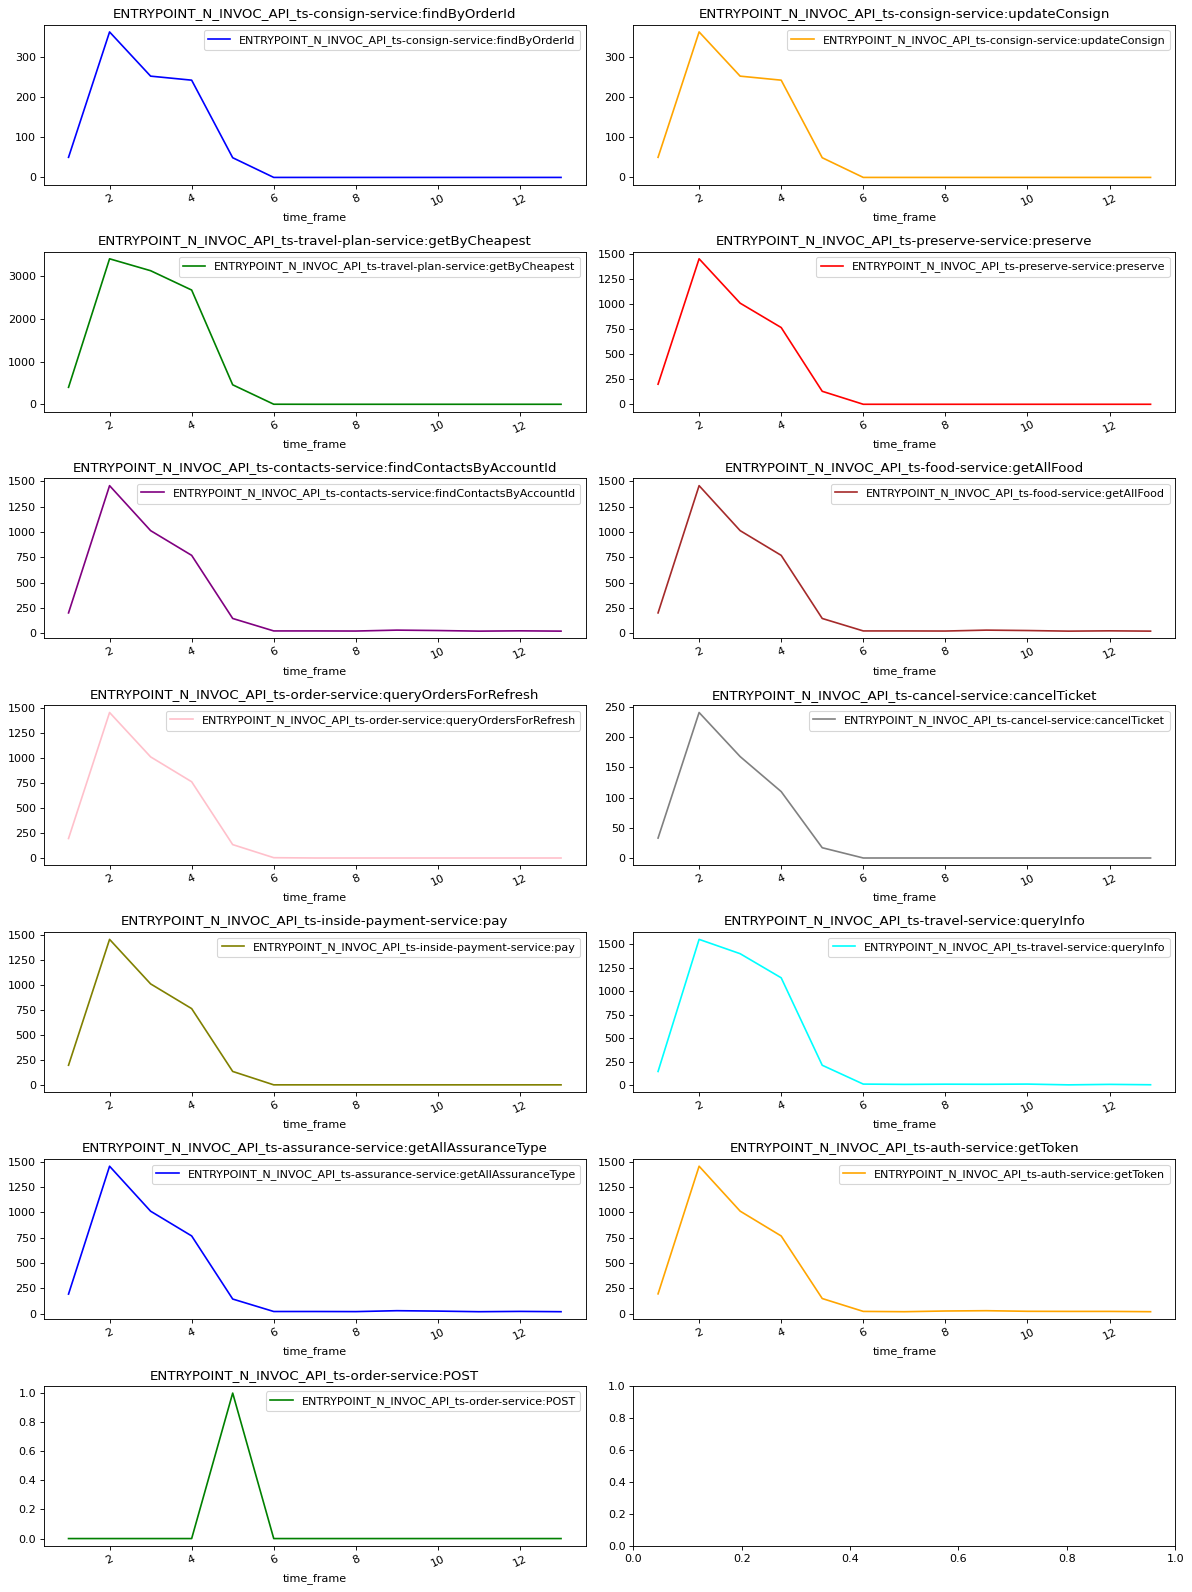

Data normalized
Input size 45 Output size 13
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                2944      
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 13)                429       
                                                                 
Total params: 5,453
Trainable params: 5,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 443ms/step - loss: 0.7711 - val_loss: 0.1195
Epoch 2/100
1/1 [==============================] - 0s 28ms/step - loss: 20.1963 - val_loss: 0.6232
Epoch 3/100
1/1 [==============================] - 0s 25ms/step - loss: 3

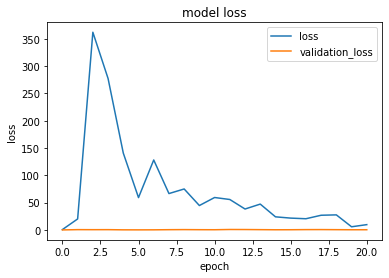

1/1 [==============================] - 0s 43ms/step
TOTAL MSE:  0.4542664896586613
TOTAL MAE:  0.5548455810938011
TOTAL MAPE:  1.03
FIRST 50 predictions
ENTRY ENTRYPOINT_AVG_EXTIME_ts-consign-service:findByOrderId
PRED [4309.0073, 4296.9165, 4254.226, 4275.4683, 4265.1353]
VALS [0.0, 0.0, 0.0, 0.0, 0.0]


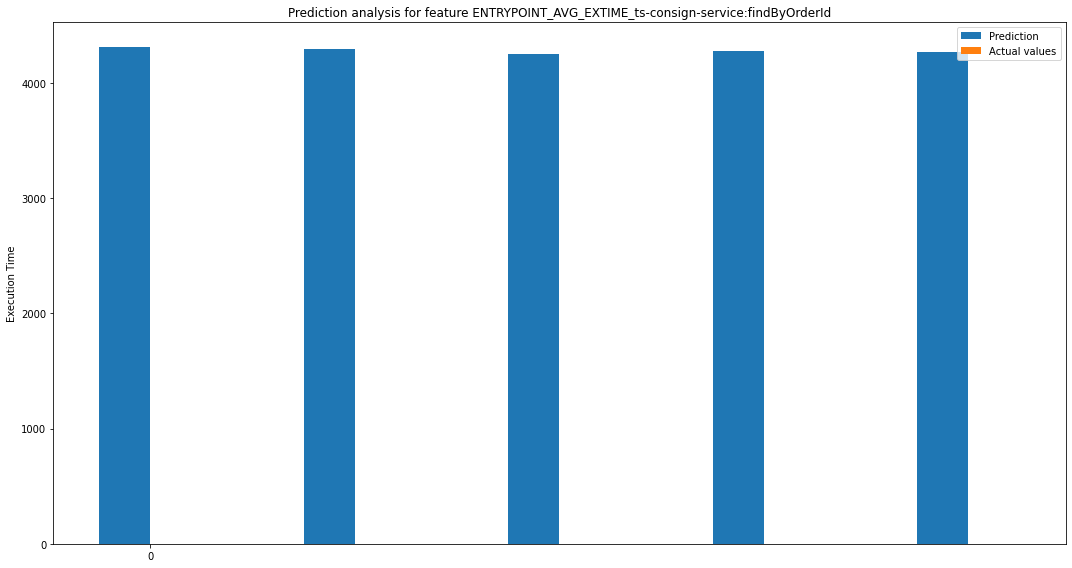

MAE:  4280.15068359375
MAPE:  100.0  %
MSE:  18320096.52867074
ENTRY ENTRYPOINT_AVG_EXTIME_ts-consign-service:updateConsign
PRED [7950.3755, 7800.412, 7575.5483, 7691.9917, 7546.729]
VALS [0.0, 0.0, 0.0, 0.0, 0.0]


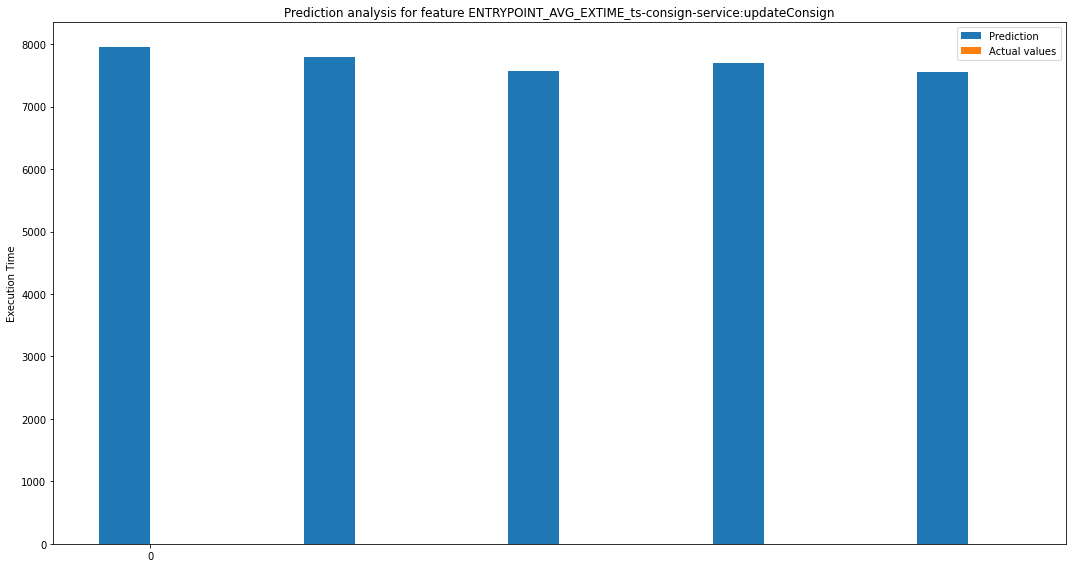

MAE:  7713.011328125
MAPE:  100.0  %
MSE:  59512737.417861365
ENTRY ENTRYPOINT_AVG_EXTIME_ts-travel-plan-service:getByCheapest
PRED [22250466.0, 24218152.0, 28413090.0, 26250810.0, 28322992.0]
VALS [0.0, 0.0, 0.0, 0.0, 0.0]


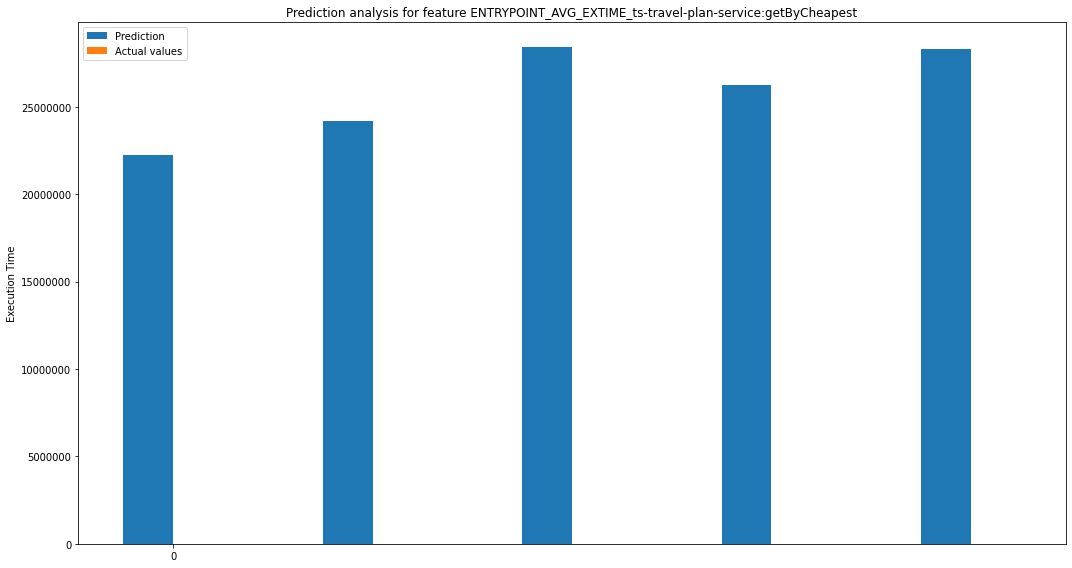

MAE:  25891102.0
MAPE:  100.0  %
MSE:  676040541669704.8
ENTRY ENTRYPOINT_AVG_EXTIME_ts-preserve-service:preserve
PRED [-46126624.0, -46070016.0, -45806780.0, -45940056.0, -45895870.0]
VALS [0.0, 0.0, 0.0, 0.0, 0.0]


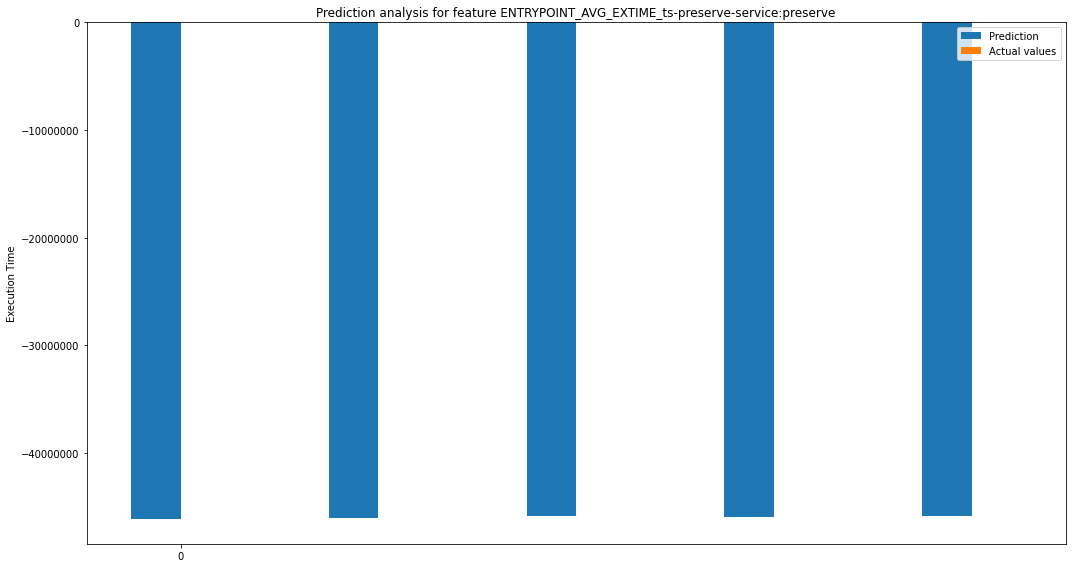

MAE:  45967869.6
MAPE:  100.0  %
MSE:  2113058544353910.5
ENTRY ENTRYPOINT_AVG_EXTIME_ts-contacts-service:findContactsByAccountId
PRED [1614.5814, 1628.0026, 1648.7249, 1638.2539, 1648.817]
VALS [2576.9666666666667, 2588.3846153846152, 2554.0, 2681.608695652174, 2728.0]


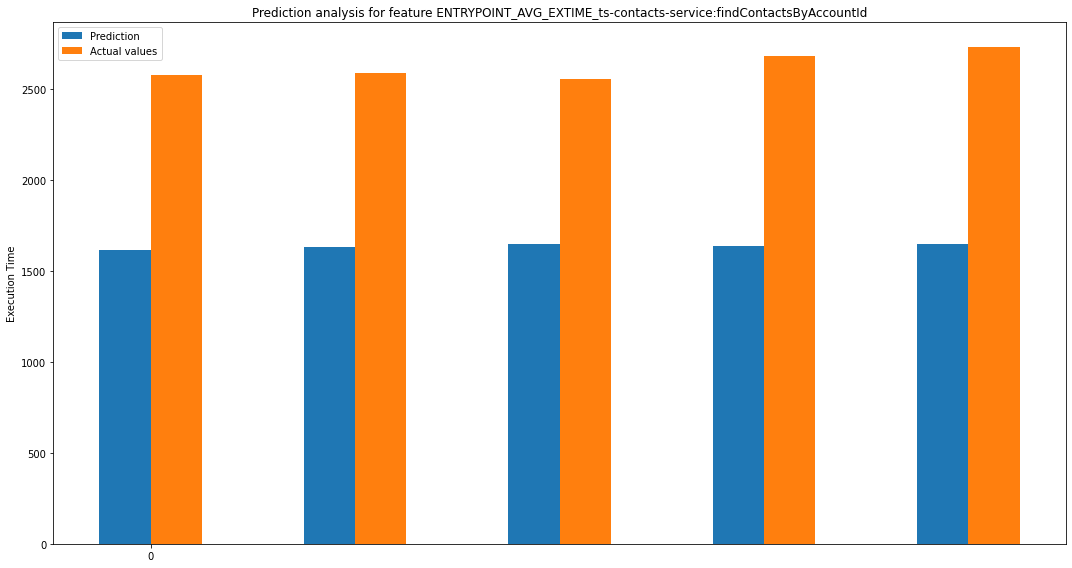

MAE:  990.1160433922538
MAPE:  60.53  %
MSE:  984253.4531934022
ENTRY ENTRYPOINT_AVG_EXTIME_ts-food-service:getAllFood
PRED [21773.828, 21738.71, 21669.314, 21703.893, 21668.008]
VALS [24969.4, 25105.346153846152, 25717.65, 25837.17391304348, 25549.9]


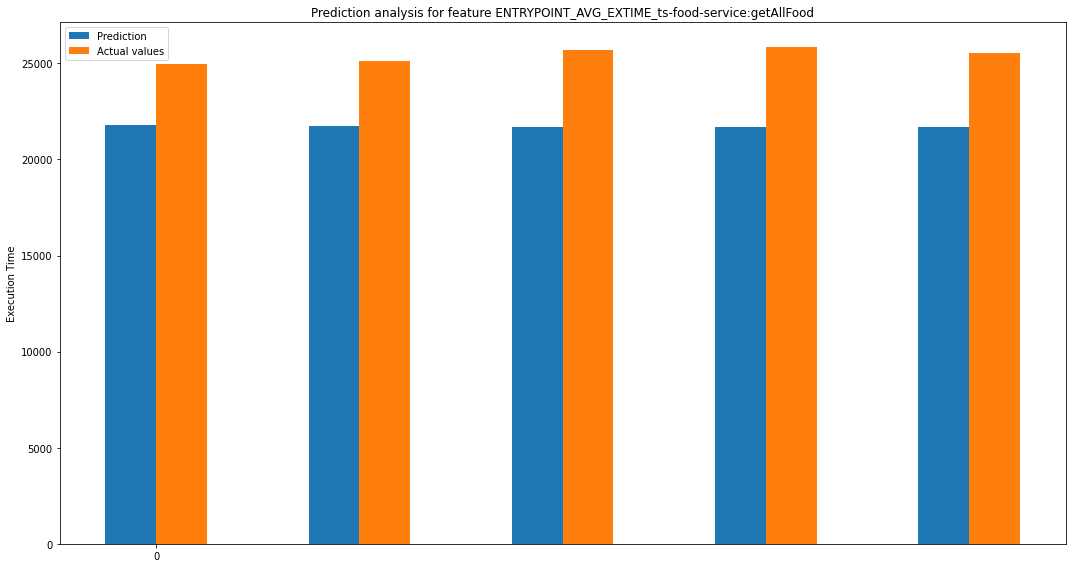

MAE:  3725.143232127927
MAPE:  17.16  %
MSE:  14017606.907456776
ENTRY ENTRYPOINT_AVG_EXTIME_ts-order-service:queryOrdersForRefresh
PRED [-122932024.0, -124749340.0, -128045490.0, -126268216.0, -128494270.0]
VALS [0.0, 0.0, 0.0, 0.0, 0.0]


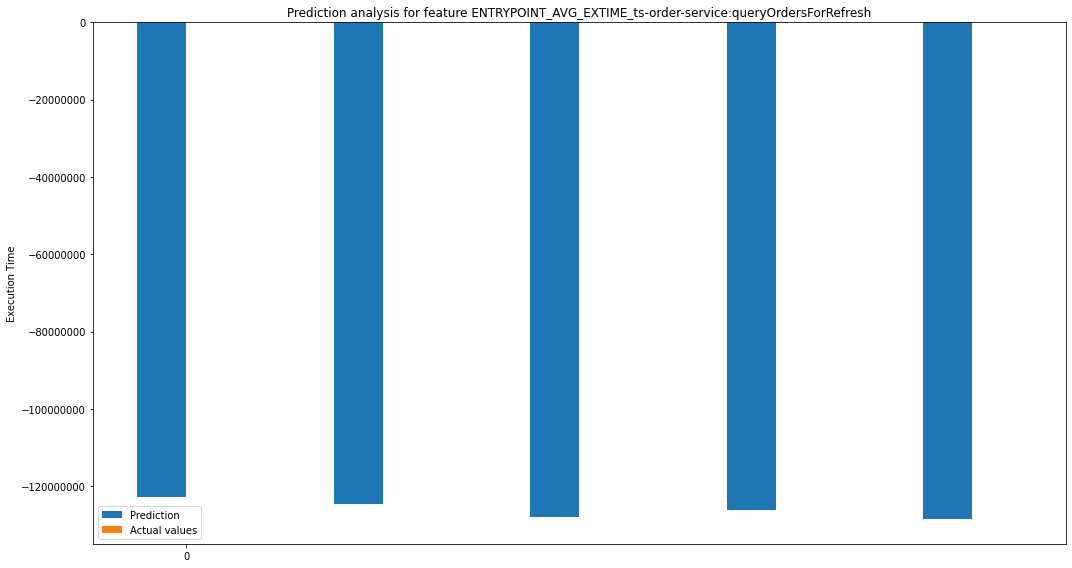

MAE:  126097868.8
MAPE:  100.0  %
MSE:  1.590495373179154e+16
ENTRY ENTRYPOINT_AVG_EXTIME_ts-cancel-service:cancelTicket
PRED [-5128.5176, -5085.5977, -4997.9023, -5031.2466, -5034.727]
VALS [0.0, 0.0, 0.0, 0.0, 0.0]


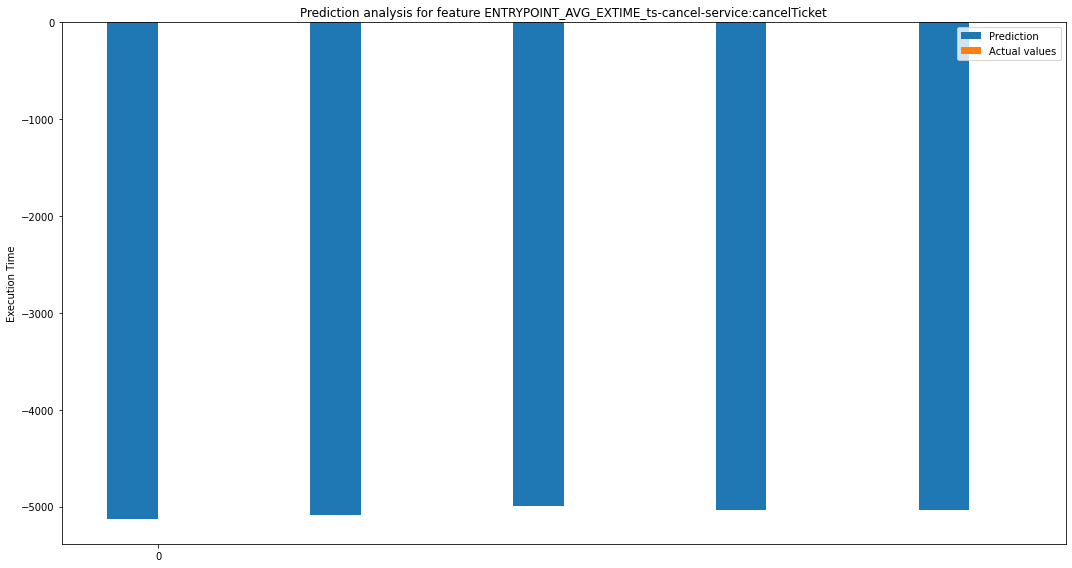

MAE:  5055.5982421875
MAPE:  100.0  %
MSE:  25561188.51062479
ENTRY ENTRYPOINT_AVG_EXTIME_ts-inside-payment-service:pay
PRED [-75662.1, -75725.47, -75750.96, -75689.06, -75956.7]
VALS [0.0, 0.0, 0.0, 0.0, 0.0]


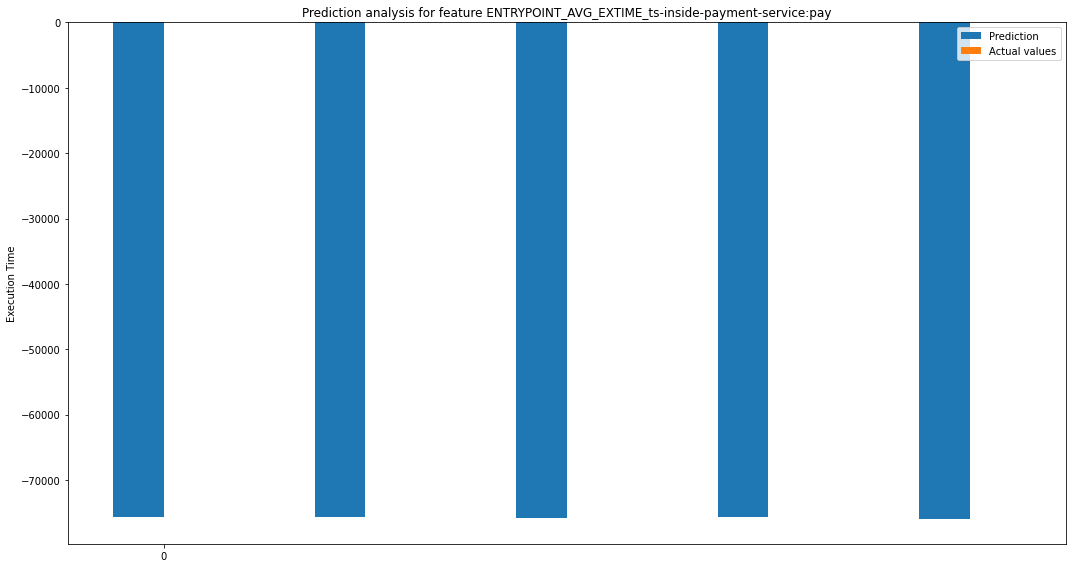

MAE:  75756.859375
MAPE:  100.0  %
MSE:  5739112648.9928465
ENTRY ENTRYPOINT_AVG_EXTIME_ts-travel-service:queryInfo
PRED [2082898.6, 2142357.8, 2266827.8, 2202913.2, 2260949.0]
VALS [26427.90909090909, 29842.92307692308, 27230.2, 27668.2, 25188.666666666668]


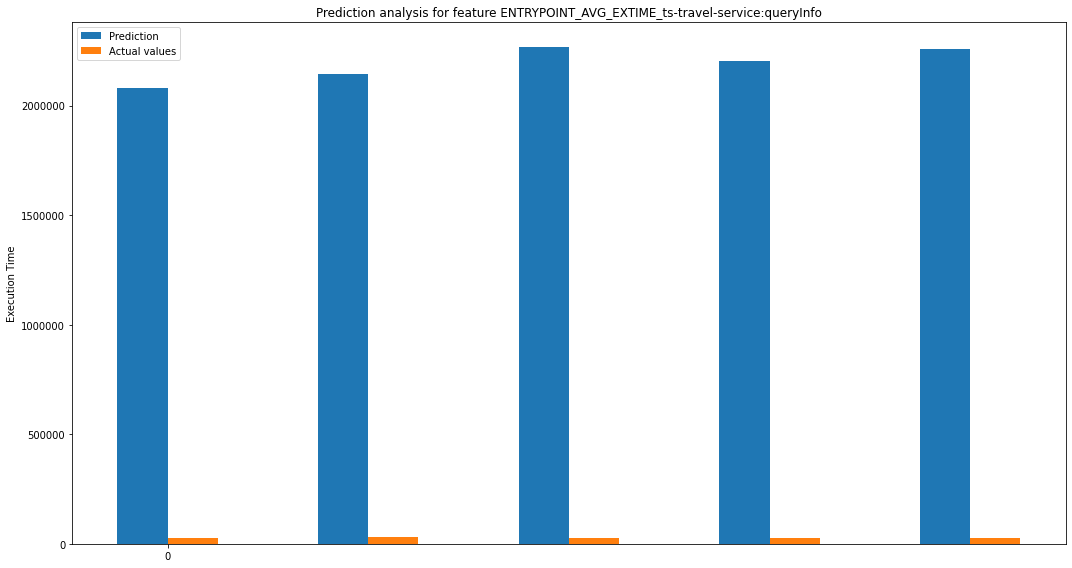

MAE:  2163917.6952331
MAPE:  98.75  %
MSE:  4687580636196.754
ENTRY ENTRYPOINT_AVG_EXTIME_ts-assurance-service:getAllAssuranceType
PRED [3224.332, 3211.2896, 3183.0315, 3197.6743, 3186.5295]
VALS [1806.9666666666667, 1851.0, 1818.25, 1867.3478260869565, 1872.75]


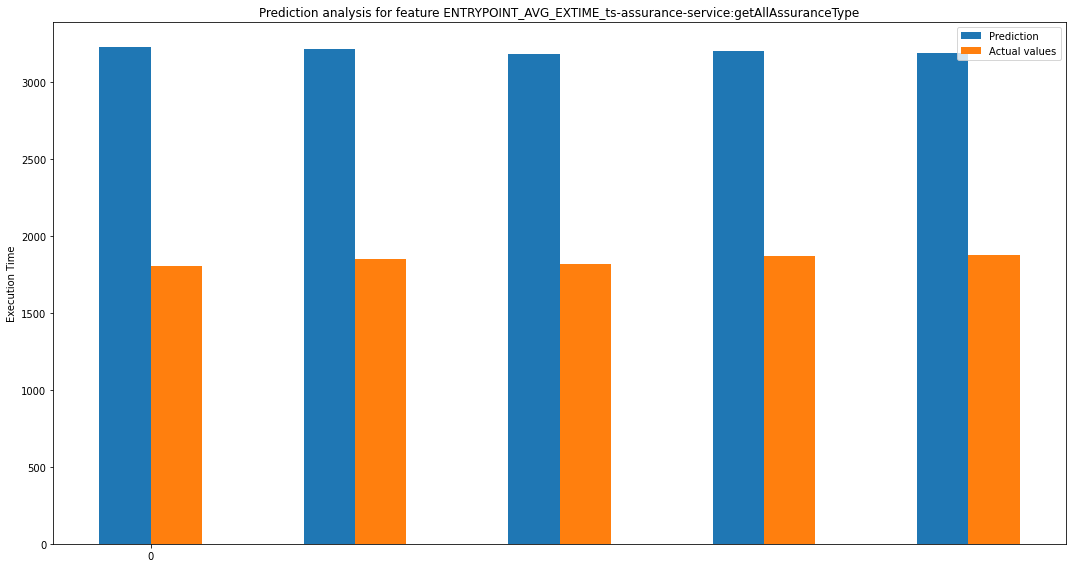

MAE:  1357.3084881680254
MAPE:  42.41  %
MSE:  1843545.2037340584
ENTRY ENTRYPOINT_AVG_EXTIME_ts-auth-service:getToken
PRED [108803.42, 108754.09, 108673.24, 108719.36, 108658.555]
VALS [106382.53333333334, 105333.54166666669, 105307.43478260867, 105588.56521739133, 106195.25]


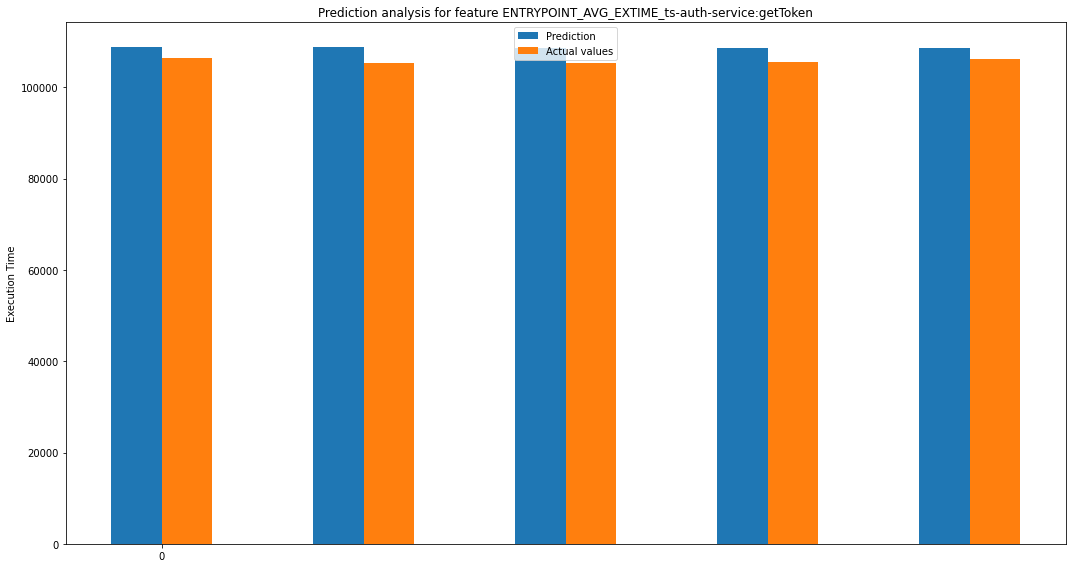

MAE:  2960.269374999995
MAPE:  2.72  %
MSE:  8951855.882713232
ENTRY ENTRYPOINT_AVG_EXTIME_ts-order-service:POST
PRED [3906298.5, 3806938.2, 3613423.5, 3718921.8, 3602284.2]
VALS [0.0, 0.0, 0.0, 0.0, 0.0]


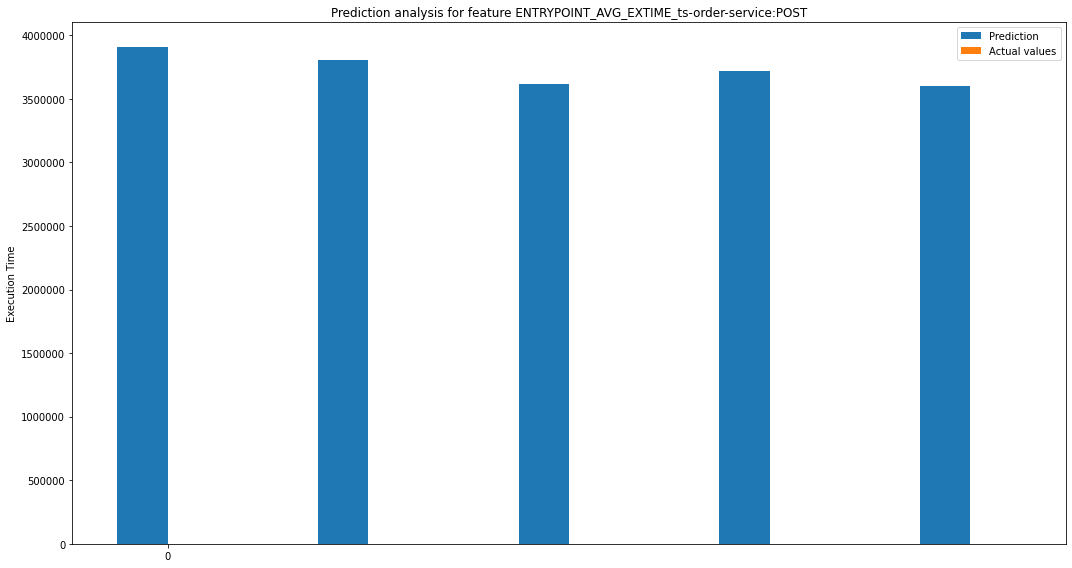

MAE:  3729573.25
MAPE:  100.0  %
MSE:  13923121400237.738
MAE:  4280.15068359375
MAPE:  1.0
MSE:  18320096.52867074
MAE:  7713.011328125
MAPE:  1.0
MSE:  59512737.417861365
MAE:  25891102.0
MAPE:  1.0
MSE:  676040541669704.8
MAE:  45967869.6
MAPE:  1.0
MSE:  2113058544353910.5
MAE:  990.1160433922538
MAPE:  0.61
MSE:  984253.4531934022
MAE:  3725.143232127927
MAPE:  0.17
MSE:  14017606.907456776
MAE:  126097868.8
MAPE:  1.0
MSE:  1.590495373179154e+16
MAE:  5055.5982421875
MAPE:  1.0
MSE:  25561188.51062479
MAE:  75756.859375
MAPE:  1.0
MSE:  5739112648.9928465
MAE:  2163917.6952331
MAPE:  0.99
MSE:  4687580636196.754
MAE:  1357.3084881680254
MAPE:  0.42
MSE:  1843545.2037340584
MAE:  2960.269374999995
MAPE:  0.03
MSE:  8951855.882713232
MAE:  3729573.25
MAPE:  1.0
MSE:  13923121400237.738
CPU times: user 3min 19s, sys: 46.9 s, total: 4min 6s
Wall time: 2min 2s


In [9]:
%%time

results[50] = MachineLearningAnalyzer("avv_dataset_DT_50.csv").perform_analysis()
results[100] = MachineLearningAnalyzer("avv_dataset_DT_100.csv").perform_analysis()
results[500] = MachineLearningAnalyzer("avv_dataset_DT_500.csv").perform_analysis()
results[1000] = MachineLearningAnalyzer("avv_dataset_DT_1000.csv").perform_analysis()
results[5000] = MachineLearningAnalyzer("avv_dataset_DT_5000.csv").perform_analysis()
results[10000] = MachineLearningAnalyzer("avv_dataset_DT_10000.csv").perform_analysis()
results[60000] = MachineLearningAnalyzer("avv_dataset_DT_60000.csv").perform_analysis()
results[300000] = MachineLearningAnalyzer("avv_dataset_DT_300000.csv").perform_analysis()

In [2]:
res_df = pd.DataFrame.from_dict(results, orient="index").sort_index()

res_df

NameError: name 'pd' is not defined

In [1]:
dict_doc = []

print("MAE")
for key in [key for key in res_df.keys() if "ENTRYPOINT_AVG_EXTIME" in key and "MAE" in key]:
    vals = {
        "entrypoint": key.lstrip("ENTRYPOINT_AVG_EXTIME").replace("MAE","")
    }
    
    for idx, row in res_df[key].items():
        vals[idx] = str(round(row * 100, 2))
    dict_doc.append(vals)
        
pd.DataFrame().from_records(dict_doc)

MAE


NameError: name 'res_df' is not defined

In [12]:
dict_doc = []

print("MAPE")
for key in [key for key in res_df.keys() if "ENTRYPOINT_AVG_EXTIME" in key and "MAPE" in key]:
    vals = {
        "entrypoint": key.lstrip("ENTRYPOINT_AVG_EXTIME").replace("MAPE","")
    }
    
    for idx, row in res_df[key].items():
        vals[idx] = str(round(row * 100, 2)) + " %"
    dict_doc.append(vals)
        
pd.DataFrame().from_records(dict_doc)

MAPE


entrypoint       50      100      500  \
0          ts-travel-plan-service:getByCheapest   101.0 %  105.0 %  152.0 %   
1        ts-order-service:queryOrdersForRefresh   100.0 %  119.0 %  137.0 %   
2              ts-consign-service:findByOrderId   101.0 %   96.0 %   93.0 %   
3                 ts-inside-payment-service:pay   101.0 %  272.0 %  157.0 %   
4              ts-consign-service:updateConsign   105.0 %   96.0 %   93.0 %   
5                  ts-preserve-service:preserve   100.0 %  117.0 %  224.0 %   
6                    ts-food-service:getAllFood   139.0 %   86.0 %   70.0 %   
7   ts-contacts-service:findContactsByAccountId   109.0 %   83.0 %   68.0 %   
8                ts-cancel-service:cancelTicket   100.0 %  100.0 %  102.0 %   
9                      ts-auth-service:getToken   144.0 %   91.0 %   64.0 %   
10     ts-assurance-service:getAllAssuranceType   109.0 %   86.0 %   72.0 %   
11                  ts-travel-service:queryInfo   100.0 %  109.0 %  261.0 %   
12                        ts-order-service:POST   100.0 %  100.0 %  105.0 %   

       1000     5000    10000    60000   300000  
0   321.0 %  100.0 %  100.0 %  100.0 %  100.0 %  
1   120.0 %  100.0 %  100.0 %  100.0 %  100.0 %  
2   101.0 %  100.0 %  100.0 %  100.0 %  100.0 %  
3   110.0 %  100.0 %  100.0 %  100.0 %  100.0 %  
4   100.0 %  100.0 %  100.0 %  100.0 %  100.0 %  
5   407.0 %  100.0 %  100.0 %  100.0 %  100.0 %  
6    72.0 %   90.0 %   73.0 %   15.0 %   17.0 %  
7    76.0 %   74.0 %   55.0 %   11.0 %   61.0 %  
8   105.0 %  100.0 %  100.0 %  100.0 %  100.0 %  
9    59.0 %   67.0 %   48.0 %    2.0 %    3.0 %  
10  116.0 %   95.0 %   75.0 %   35.0 %   42.0 %  
11  196.0 %  100.0 %  100.0 %  100.0 %   99.0 %  
12  104.0 %  100.0 %  100.0 %  100.0 %  100.0 %

In [13]:
dict_doc = []

print("MSE")
for key in [key for key in res_df.keys() if "ENTRYPOINT_AVG_EXTIME" in key and "MSE" in key]:
    vals = {
        "entrypoint": key.lstrip("ENTRYPOINT_AVG_EXTIME").replace("MSE","")
    }
    
    for idx, row in res_df[key].items():
        vals[idx] = round(row * 100, 2)
    dict_doc.append(vals)
        
pd.DataFrame().from_records(dict_doc)

MSE


entrypoint            50           100  \
0          ts-travel-plan-service:getByCheapest   7.667392e+18  3.534739e+16   
1        ts-order-service:queryOrdersForRefresh   2.163564e+19  3.168856e+16   
2              ts-consign-service:findByOrderId   8.383602e+09  2.692060e+07   
3                 ts-inside-payment-service:pay   5.319036e+13  9.451335e+10   
4              ts-consign-service:updateConsign   1.973049e+10  1.930807e+08   
5                  ts-preserve-service:preserve   1.709938e+19  4.680670e+16   
6                    ts-food-service:getAllFood   2.255739e+11  3.291259e+09   
7   ts-contacts-service:findContactsByAccountId   7.690775e+09  3.098323e+07   
8                ts-cancel-service:cancelTicket   4.861507e+11  2.729084e+09   
9                      ts-auth-service:getToken   1.529809e+12  4.731445e+10   
10     ts-assurance-service:getAllAssuranceType   1.474412e+09  1.303092e+07   
11                  ts-travel-service:queryInfo   6.693166e+18  1.849573e+16   
12                        ts-order-service:POST   6.191687e+15  2.247299e+13   

             500          1000          5000         10000         60000  \
0   7.758494e+16  1.356119e+17  8.785369e+15  1.405508e+16  2.171528e+17   
1   1.099966e+17  1.644172e+17  1.299814e+17  4.552079e+16  4.496706e+18   
2   5.541558e+07  5.780394e+07  1.663833e+07  6.588286e+06  5.620681e+05   
3   2.182341e+11  3.455039e+11  2.863980e+11  3.530958e+11  1.044870e+13   
4   2.928479e+08  3.587933e+08  1.167409e+08  2.007968e+08  5.949689e+09   
5   1.025312e+17  1.443410e+17  4.732525e+16  3.041685e+15  2.170659e+17   
6   1.636192e+10  2.123572e+10  1.595478e+10  1.421675e+10  1.207357e+09   
7   1.993783e+08  1.864636e+08  1.565466e+08  1.356462e+08  8.883588e+06   
8   5.792283e+09  1.178458e+10  1.323774e+09  5.711084e+08  5.967580e+08   
9   4.148797e+11  6.253027e+11  2.646099e+11  2.406491e+11  8.167656e+08   
10  8.347595e+07  1.035083e+08  8.239489e+07  9.131620e+07  2.362055e+07   
11  6.405456e+16  1.238645e+17  3.515931e+16  2.612765e+16  2.647092e+16   
12  3.942297e+13  6.732086e+13  2.357027e+12  5.452425e+12  3.736504e+16   

          300000  
0   6.760405e+16  
1   1.590495e+18  
2   1.832010e+09  
3   5.739113e+11  
4   5.951274e+09  
5   2.113059e+17  
6   1.401761e+09  
7   9.842535e+07  
8   2.556119e+09  
9   8.951856e+08  
10  1.843545e+08  
11  4.687581e+14  
12  1.392312e+15